# Analyze result of the spectra model
- run glm model to examine factors that differentiate ARI and ERA from CON2
- plot factor scores

In [1]:
quiet_library <- function(...) {
    suppressPackageStartupMessages(library(...))
}
quiet_library("Seurat")
quiet_library("tidyverse")
quiet_library("ggplot2")
quiet_library("dplyr")
quiet_library("viridis")
quiet_library("lmerTest")
quiet_library("broom.mixed")
quiet_library("data.table")
quiet_library("ggpubr")
quiet_library("rstatix")


Warning message:
“package ‘dplyr’ was built under R version 4.3.3”


In [ ]:
# define the color palette to be used
npg_color <- c(
    "#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF",
    "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"
)
nejm_color <- c("#BC3C29FF", "#0072B5FF", "#E18727FF", "#20854EFF", "#7876B1FF", "#6F99ADFF", "#FFDC91FF", "#EE4C97FF")
jama_color <- c("#374E55FF", "#DF8F44FF", "#00A1D5FF", "#B24745FF", "#79AF97FF", "#6A6599FF", "#80796BFF")
jco_color <- c("#0073C2FF", "#EFC000FF", "#868686FF", "#CD534CFF", "#7AA6DCFF", "#003C67FF", "#8F7700FF")
cluster_colors <- c(
    "#DC050C", "#FB8072", "#1965B0", "#7BAFDE", "#882E72", "#B17BA6", "#FF7F00", "#FDB462", "#E7298A",
    "#E78AC3", "#33A02C", "#B2DF8A", "#55A1B1", "#8DD3C7", "#A6761D", "#E6AB02", "#7570B3", "#BEAED4", "#666666", "#999999",
    "#aa8282", "#d4b7b7", "#8600bf", "#ba5ce3", "#808000", "#aeae5c", "#1e90ff", "#00bfff", "#56ff0d", "#ffff00"
)
ari_colors <- c("#4C8CBD", "#F59F00", "#840032")
cluster_colors_ext <- colorRampPalette(cluster_colors)(36)
options(repr.plot.width = 20, repr.plot.height = 15)


In [ ]:
# define working path
data_path <- "/home/jupyter/data/ra_longitudinal/output_results/Spectra"
fig_path <- "/home/jupyter/data/ra_longitudinal/figures/Spectra"
meta_path <- "/home/jupyter/github/ra-longitudinal/metadata"
output_path <- "/home/jupyter/data/ra_longitudinal/output_results/Spectra"

# define a project name
proj_name <- "ALTRA_Crox_scRNA_Spectra"


In [ ]:
source("/home/jupyter/github/ra-longitudinal/scRNA/ALTRA_scRNA_R_helper_functions.r")


## analyze average scores per sample from the single cell analysis

In [5]:
# load the scores
spec_scores <- read_tsv(file.path(data_path, "RA_Cross_sectional_scRNA_Spectra_sample_average_positive_scores.tsv"),
    show_col_types = FALSE
)


New names:
• `` -> `...1`


In [6]:
spec_scores %>% head()


...1 sample.sampleKitGuid AIFI_L1_5    
1 0    KT00052              CD4_T        
2 1    KT00052              CD8_T        
3 2    KT00052              DC           
4 3    KT00052              ILC          
5 4    KT00052              Memory B cell
6 5    KT00052              NK           
  Spectra_factor                                              mean_score  
1 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis 0.0001827638
2 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis 0.0001856450
3 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis 0.0001803807
4 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis 0.0000000000
5 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis 0.0001782096
6 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis 0.0002093238
  nonzero_percentage file.batchID Status_Xsec Status_Long BMI     
1 44.53024           B140         at_risk     pre         24.65716
2 47.79614           B140         at_risk     pre         24.65716
3 46.66667           B140         at_risk     pre         24.65716
4  0.00000           B140         at_risk     pre         24.65716
5 40.39735           B140         at_risk     pre         24.65716
6 55.80808           B140         at_risk     pre         24.65716
  subject.biologicalSex CMV_Status_Subj age status  anti_ccp3_finalCombined
1 Female                Negative        56  at_risk 88                     
2 Female                Negative        56  at_risk 88                     
3 Female                Negative        56  at_risk 88                     
4 Female                Negative        56  at_risk 88                     
5 Female                Negative        56  at_risk 88                     
6 Female                Negative        56  at_risk 88

In [7]:
samples_numbers <- spec_scores %>%
    distinct(sample.sampleKitGuid, .keep_all = TRUE) %>%
    group_by(Status_Xsec) %>%
    tally()
samples_numbers
# remove factor that more than half of the samples are 0
factor_keep <- spec_scores %>%
    filter(nonzero_percentage > 0) %>%
    group_by(Spectra_factor, AIFI_L1_5) %>%
    tally() %>%
    filter(n >= sum(samples_numbers$n) / 2) %>%
    pull(Spectra_factor) %>%
    unique()


Status_Xsec   n 
1 ALTRA_healthy 31
2 at_risk       45
3 early_RA      12

In [8]:
# filter the score dataframe
spec_scores_fl <- spec_scores %>%
    filter(AIFI_L1_5 != "ILC" & Spectra_factor %in% factor_keep) %>%
    mutate(
        Status_Xsec = factor(Status_Xsec, levels = c("ALTRA_healthy", "at_risk", "early_RA")),
        status = factor(recode(Status_Xsec, "ALTRA_healthy" = "Control1", "at_risk" = "ARI", "early_RA" = "ERA"),
            levels = c("Control1", "ARI", "ERA")
        )
    ) %>%
    mutate(batch_corr = if_else(file.batchID == "B182", "B182", "Other")) %>%
    filter(!str_detect(Spectra_factor, "-X-ILC-X-"))


In [9]:
spec_scores_fl %>%
    distinct(status) %>%
    pull(status)


[1] ARI      ERA      Control1
Levels: Control1 ARI ERA

In [10]:
spec_scores_fl %>%
    group_by(AIFI_L1_5, Spectra_factor) %>%
    tally() %>%
    arrange(n) %>%
    head()


AIFI_L1_5 Spectra_factor                                              n 
1 CD4_T     0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis 88
2 CD4_T     1-X-global-X-all_retinol_metabolism                         88
3 CD4_T     10-X-global-X-all_transmembrane-transport-ER                88
4 CD4_T     100-X-global-X-all_ascorbate-uptake                         88
5 CD4_T     101-X-global-X-all_ketone-body_metabolism                   88
6 CD4_T     102-X-global-X-all_keratan-sulfate_degradation              88

In [11]:
spec_scores_fl %>%
    filter(AIFI_L1_5 == "CD4_T" & Spectra_factor == "106-X-global-X-all_MHC-I-presentation") %>%
    rstatix::kruskal_test(mean_score ~ status)


.y.        n  statistic df p     method        
1 mean_score 88 0.5465916 2  0.761 Kruskal-Wallis

In [12]:
spec_scores_fl %>% head()


...1 sample.sampleKitGuid AIFI_L1_5    
1 0    KT00052              CD4_T        
2 1    KT00052              CD8_T        
3 2    KT00052              DC           
4 4    KT00052              Memory B cell
5 5    KT00052              NK           
6 6    KT00052              Naive B cell 
  Spectra_factor                                              mean_score  
1 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis 0.0001827638
2 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis 0.0001856450
3 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis 0.0001803807
4 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis 0.0001782096
5 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis 0.0002093238
6 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis 0.0001905790
  nonzero_percentage file.batchID Status_Xsec Status_Long BMI     
1 44.53024           B140         at_risk     pre         24.65716
2 47.79614           B140         at_risk     pre         24.65716
3 46.66667           B140         at_risk     pre         24.65716
4 40.39735           B140         at_risk     pre         24.65716
5 55.80808           B140         at_risk     pre         24.65716
6 42.30769           B140         at_risk     pre         24.65716
  subject.biologicalSex CMV_Status_Subj age status anti_ccp3_finalCombined
1 Female                Negative        56  ARI    88                     
2 Female                Negative        56  ARI    88                     
3 Female                Negative        56  ARI    88                     
4 Female                Negative        56  ARI    88                     
5 Female                Negative        56  ARI    88                     
6 Female                Negative        56  ARI    88                     
  batch_corr
1 Other     
2 Other     
3 Other     
4 Other     
5 Other     
6 Other

## get top10 genes for each factor

In [13]:
# load the gene weight for factor
gene_weight <- fread(file.path(output_path, "RA_Cross_sectional_scRNA_Spectra_gene_weight.csv")) %>% rename("gene" = "V1")
gene_weight %>% head()


gene     0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis
1 FAM41C   8.375776e-16                                               
2 ISG15    3.046103e-14                                               
3 TNFRSF18 3.366851e-16                                               
4 TNFRSF4  8.473794e-14                                               
5 B3GALT6  4.182406e-02                                               
6 UBE2J2   1.810953e-10                                               
  1-X-global-X-all_retinol_metabolism
1 3.779302e-15                       
2 8.249192e-14                       
3 4.110050e-16                       
4 1.388141e-13                       
5 1.694247e-13                       
6 5.127512e-11                       
  2-X-global-X-all_RIG-I-like-receptor_signaling
1 9.932433e-16                                  
2 4.493381e-03                                  
3 4.023495e-16                                  
4 6.277845e-14                                  
5 4.791173e-14                                  
6 5.740048e-06                                  
  3-X-global-X-all_propanoate_metabolism 4-X-global-X-all_p53-signaling
1 1.178150e-15                           9.086410e-16                  
2 9.817519e-14                           2.005391e-14                  
3 6.936347e-16                           4.552718e-16                  
4 1.056513e-13                           4.186695e-14                  
5 1.044946e-11                           9.508932e-12                  
6 4.043606e-07                           4.819979e-08                  
  5-X-global-X-all_macroautophagy 6-X-global-X-all_circadian-rhythm
1 5.330064e-16                    1.004214e-15                     
2 2.463410e-14                    5.960023e-14                     
3 2.465864e-16                    5.659576e-16                     
4 1.687665e-14                    1.642458e-13                     
5 3.650819e-14                    1.367095e-13                     
6 2.100249e-07                    1.017559e-07                     
  7-X-global-X-all_VAL-LEU-ILE_metabolism
1 8.322381e-16                           
2 6.037471e-14                           
3 3.870110e-16                           
4 1.133664e-13                           
5 1.084235e-10                           
6 3.062118e-08                           
  8-X-global-X-all_taurine-hypotaurine_metabolism ⋯
1 2.970326e-15                                    ⋯
2 1.157622e-15                                    ⋯
3 3.859068e-16                                    ⋯
4 2.064433e-14                                    ⋯
5 5.307352e-14                                    ⋯
6 1.214851e-05                                    ⋯
  213-X-Treg-X-TNK_IL2-STAT5-signaling 214-X-Treg-X-Treg_FoxP3-stabilization
1 1.212272e-03                         1.917657e-11                         
2 2.066785e-09                         3.615304e-12                         
3 1.050831e-02                         7.897715e-09                         
4 1.785871e-02                         5.211456e-04                         
5 4.750036e-14                         3.360701e-14                         
6 1.026852e-11                         5.071106e-04                         
  215-X-Treg-X-CD4-T_TH22_UP 216-X-Treg-X-216 217-X-Treg-X-217
1 1.151275e-08               1.057835e-03     3.764165e-02    
2 1.527407e-02               1.339112e-02     5.614168e-05    
3 3.012729e-02               6.896984e-03     9.769645e-05    
4 2.152280e-05               1.273061e-02     5.520095e-03    
5 5.484951e-14               1.437800e-14     1.270712e-03    
6 3.716377e-03               9.134931e-04     4.059168e-02    
  218-X-gdT-X-TNK_cytotoxicity-effectors
1 0.012487325                           
2 0.037229232                           
3 0.008664161                           
4 0.004205376                           
5 0.007500864                           
6 0.014592452                   

In [14]:
# get to 10 gene by weight
top10_gene_weight <- gene_weight %>%
    pivot_longer(cols = -gene, names_to = "Spectra_factor", values_to = "weight") %>%
    group_by(Spectra_factor) %>%
    slice_max(order_by = weight, n = 10) %>%
    ungroup()


In [15]:
top10_genes <- top10_gene_weight %>%
    group_by(Spectra_factor) %>%
    summarise(top10_genes = paste(gene, collapse = ", "))
top10_genes %>% head()


Spectra_factor                                             
1 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis
2 1-X-global-X-all_retinol_metabolism                        
3 10-X-global-X-all_transmembrane-transport-ER               
4 100-X-global-X-all_ascorbate-uptake                        
5 101-X-global-X-all_ketone-body_metabolism                  
6 102-X-global-X-all_keratan-sulfate_degradation             
  top10_genes                                                                     
1 CHST11, CSGALNACT2, B4GALT7, HS2ST1, EXT2, B3GAT2, CHPF2, CHSY1, XYLT2, HS3ST3B1
2 RDH14, PNPLA4, RDH13, RDH5, RDH10, RDH11, RDH16, MKRN1, LRAT, RDH12             
3 SLC33A1, XIST, SLC35D1, MAN1A2, SLC37A4, ITPR2, BRAF, HEXIM1, MAVS, POLR3A      
4 MTRNR2L8, SLC23A2, MT-ATP8, HBB, IGHM, XIST, EPG5, IGHA1, RUBCN, NBR1           
5 ACAT2, OXCT1, HMGCL, ACSS1, BDH1, SLC16A1, AACS, ACSS2, LDHB, ACAT1             
6 HEXA, AGA, NEU1, HEXB, FUCA1, GALNS, GLB1, FUCA2, GNS, NAGA

## run anova test

In [16]:
# run wilcox test for frequency pretreatment vs healthy
# anova_test <- spec_scores_fl %>%
#     group_by(AIFI_L1_5, Spectra_factor) %>%
#     rstatix::kruskal_test(mean_score ~ Status_Xsec) %>%
#     ungroup()%>%
#     rstatix::adjust_pvalue(method = "BH") %>%
#     rstatix::add_significance("p.adj") %>% arrange(p.adj)
# anova_test%>%head()

# check what AIFI_L1_5 are different in HCs between B182 and others
anova_test <- parallel::mclapply(unique(spec_scores_fl$Spectra_factor), function(x) {
    print(x)
    if (str_detect(x, "global")) {
        wilcox_test <- spec_scores_fl %>%
            filter(Spectra_factor == x) %>%
            group_by(AIFI_L1_5) %>%
            rstatix::kruskal_test(mean_score ~ status)
    } else {
        cell_type <- str_split(x, "-X-")[[1]][2]
        wilcox_test <- spec_scores_fl %>%
            filter(Spectra_factor == x & AIFI_L1_5 == cell_type) %>%
            group_by(AIFI_L1_5) %>%
            rstatix::kruskal_test(mean_score ~ status)
    }
    wilcox_test <- wilcox_test %>% mutate("Spectra_factor" = x)
    return(wilcox_test)
}, mc.cores = 15) %>%
    rbindlist() %>%
    rstatix::adjust_pvalue(method = "BH") %>%
    rstatix::add_significance("p.adj") %>%
    arrange(p.adj)


In [17]:
anova_test %>% filter(p.adj < 0.05)


AIFI_L1_5     .y.        n  statistic df p        method        
1   mono          mean_score 88 34.24347  2  3.67e-08 Kruskal-Wallis
2   Naive B cell  mean_score 88 34.55258  2  3.14e-08 Kruskal-Wallis
3   CD4_T         mean_score 88 32.49882  2  8.77e-08 Kruskal-Wallis
4   mono          mean_score 88 32.60574  2  8.31e-08 Kruskal-Wallis
5   CD8_T         mean_score 88 27.86324  2  8.90e-07 Kruskal-Wallis
6   DC            mean_score 88 28.03872  2  8.16e-07 Kruskal-Wallis
7   CD4_T         mean_score 88 26.79589  2  1.52e-06 Kruskal-Wallis
8   Memory B cell mean_score 88 25.66627  2  2.67e-06 Kruskal-Wallis
9   CD8_T         mean_score 88 25.51303  2  2.88e-06 Kruskal-Wallis
10  DC            mean_score 88 25.85842  2  2.43e-06 Kruskal-Wallis
11  DC            mean_score 88 24.89666  2  3.92e-06 Kruskal-Wallis
12  CD4_T         mean_score 88 24.86117  2  3.99e-06 Kruskal-Wallis
13  DC            mean_score 88 24.53820  2  4.69e-06 Kruskal-Wallis
14  Naive B cell  mean_score 88 24.52894  2  4.72e-06 Kruskal-Wallis
15  CD4_T         mean_score 88 24.24767  2  5.43e-06 Kruskal-Wallis
16  Naive B cell  mean_score 88 23.88687  2  6.50e-06 Kruskal-Wallis
17  NK            mean_score 88 23.85817  2  6.60e-06 Kruskal-Wallis
18  NK            mean_score 88 24.03015  2  6.05e-06 Kruskal-Wallis
19  CD8_T         mean_score 88 22.60722  2  1.23e-05 Kruskal-Wallis
20  Memory B cell mean_score 88 22.48762  2  1.31e-05 Kruskal-Wallis
21  Naive B cell  mean_score 88 22.62871  2  1.22e-05 Kruskal-Wallis
22  NK            mean_score 88 22.95458  2  1.04e-05 Kruskal-Wallis
23  DC            mean_score 88 22.28888  2  1.45e-05 Kruskal-Wallis
24  CD4_T         mean_score 88 22.91504  2  1.06e-05 Kruskal-Wallis
25  CD8_T         mean_score 88 22.53519  2  1.28e-05 Kruskal-Wallis
26  Treg          mean_score 88 22.30726  2  1.43e-05 Kruskal-Wallis
27  CD4_T         mean_score 88 22.36654  2  1.39e-05 Kruskal-Wallis
28  NK            mean_score 88 22.60065  2  1.24e-05 Kruskal-Wallis
29  gdT           mean_score 88 22.87325  2  1.08e-05 Kruskal-Wallis
30  mono          mean_score 88 22.72114  2  1.16e-05 Kruskal-Wallis
⋮   ⋮             ⋮          ⋮  ⋮         ⋮  ⋮        ⋮             
351 DC            mean_score 88 9.665983  2  0.00796  Kruskal-Wallis
352 NK            mean_score 88 9.663153  2  0.00797  Kruskal-Wallis
353 Treg          mean_score 88 9.651790  2  0.00802  Kruskal-Wallis
354 CD4_T         mean_score 88 9.625634  2  0.00812  Kruskal-Wallis
355 Plasma cell   mean_score 88 9.620194  2  0.00815  Kruskal-Wallis
356 Treg          mean_score 88 9.611953  2  0.00818  Kruskal-Wallis
357 Other_T       mean_score 88 9.605161  2  0.00821  Kruskal-Wallis
358 Memory B cell mean_score 88 9.589328  2  0.00827  Kruskal-Wallis
359 Other         mean_score 88 9.579069  2  0.00832  Kruskal-Wallis
360 NK            mean_score 88 9.505968  2  0.00863  Kruskal-Wallis
361 Naive B cell  mean_score 88 9.499014  2  0.00866  Kruskal-Wallis
362 Other_T       mean_score 88 9.492127  2  0.00869  Kruskal-Wallis
363 gdT           mean_score 88 9.477133  2  0.00875  Kruskal-Wallis
364 Naive B cell  mean_score 88 9.438042  2  0.00892  Kruskal-Wallis
365 Plasma cell   mean_score 88 9.396251  2  0.00911  Kruskal-Wallis
366 Treg          mean_score 88 9.390931  2  0.00914  Kruskal-Wallis
367 gdT           mean_score 88 9.382533  2  0.00918  Kruskal-Wallis
368 Other_T       mean_score 88 9.359964  2  0.00928  Kruskal-Wallis
369 Other         mean_score 88 9.348004  2  0.00933  Kruskal-Wallis
370 Other_T       mean_score 88 9.359776  2  0.00928  Kruskal-Wallis
371 Treg          mean_score 88 9.347694  2  0.00934  Kruskal-Wallis
372 Other         mean_score 88 9.356809  2  0.00929  Kruskal-Wallis
373 CD4_T         mean_score 88 9.348335  2  0.00933  Kruskal-Wallis
374 Naive B cell  mean_score 88 9.335549  2  0.00939  Kruskal-Wallis
375 Memory B cell mean_score 88 9.319246  2  0.00947  Kruskal-Wallis
376 Other_T       mean_score 88 9.317563  2  0.00948  Kruskal-Wallis
37

In [18]:
anova_test %>% write_csv(file.path(output_path, paste0(proj_name, "factor_anova_test_result.csv")))


## run glm model for scores

In [21]:
# Function to run glm analysis on a data frame
# Args:
#   df: The data frame containing the data
#   formula: The formula specifying the model
#   factor: The factor variable to include in the analysis
# Returns:
#   The tidy results of the glm analysis with the factor variable added
RunGlm <- function(df, formula, factor) {
    glm_res <- broom::tidy(stats::glm(as.formula(formula), data = df)) %>%
        mutate("Spectra_factor" = factor)
    return(glm_res)
}

# Function to run glm analysis on multiple factors in parallel
# Args:
#   spec_scores: The data frame containing the data
#   formula: The formula specifying the model
#   mc.cores: The number of cores to use for parallel processing (default is 1)
# Returns:
#   The combined results of the glm analysis for all factors, with adjusted p-values and significance added
RunGlmFactor <- function(spec_scores, formula, mc.cores = 1) {
    glm_results <- parallel::mclapply(unique(spec_scores$Spectra_factor), function(factor) {
        message(factor)
        if (str_detect(factor, "global")) {
            glm_test <- spec_scores %>%
                filter(Spectra_factor == factor) %>%
                group_by(AIFI_L1_5) %>%
                group_modify(~ RunGlm(.x, formula = formula, factor = factor))
        } else {
            cell_type <- str_split(factor, "-X-")[[1]][2]
            glm_test <- spec_scores %>%
                filter(Spectra_factor == factor & AIFI_L1_5 == cell_type) %>%
                group_by(AIFI_L1_5) %>%
                group_modify(~ RunGlm(.x, formula = formula, factor = factor))
        }
        glm_test <- glm_test %>% mutate("Spectra_factor" = factor)
        return(glm_test)
    }, mc.cores = mc.cores) %>%
        rbindlist()
    return(glm_results)
}


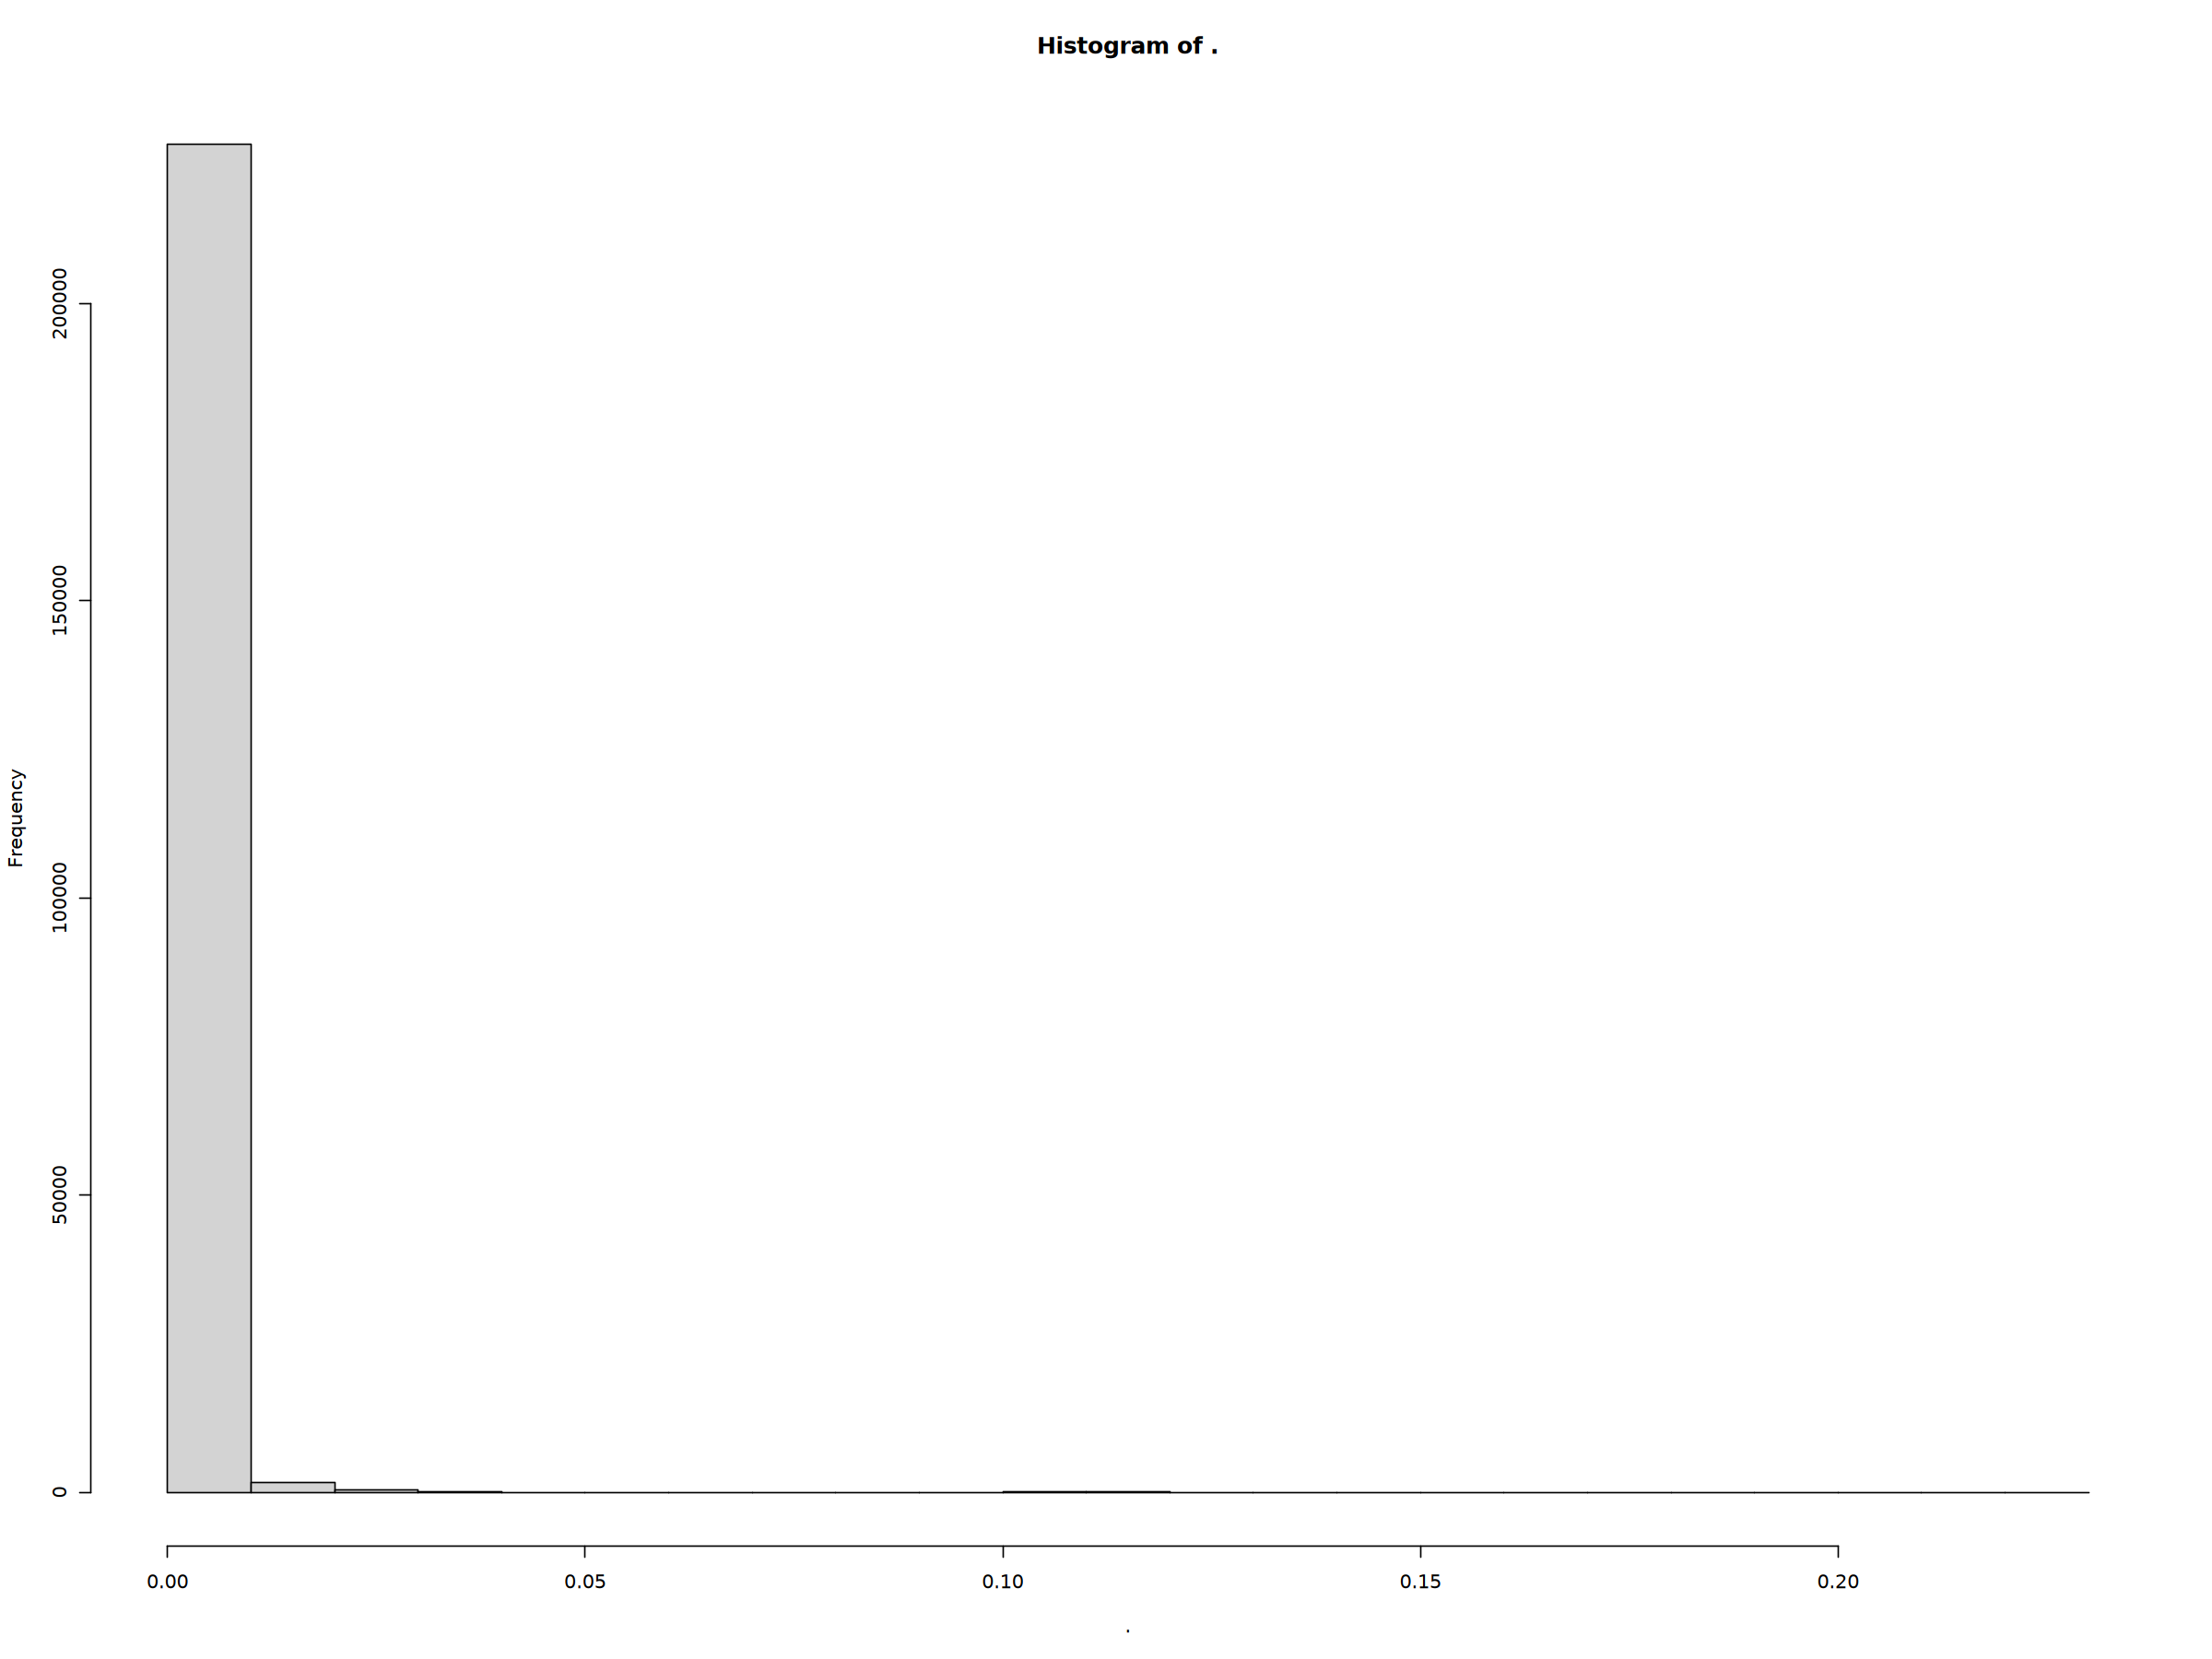

In [22]:
spec_scores_fl$mean_score %>% hist()


In [23]:
glm_results <- RunGlmFactor(
    spec_scores = spec_scores_fl,
    formula = "mean_score ~ status + subject.biologicalSex + age + BMI + batch_corr",
    mc.cores = 15
)


In [24]:
glm_results %>% head()


AIFI_L1_5 term                      estimate      std.error    statistic 
1 CD4_T     (Intercept)                2.053893e-04 6.212791e-06 33.0591006
2 CD4_T     statusARI                  6.281000e-07 2.281762e-06  0.2752698
3 CD4_T     statusERA                  2.688511e-06 3.227019e-06  0.8331253
4 CD4_T     subject.biologicalSexMale -3.216163e-06 2.537753e-06 -1.2673274
5 CD4_T     age                        9.045180e-09 6.142359e-08  0.1472591
6 CD4_T     BMI                       -7.939985e-08 1.721647e-07 -0.4611855
  p.value      Spectra_factor                                             
1 2.075344e-48 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis
2 7.838187e-01 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis
3 4.072545e-01 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis
4 2.087149e-01 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis
5 8.832980e-01 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis
6 6.459169e-01 0-X-global-X-all_chondroitine-and-heparan-sulfate_synthesis

In [25]:
glm_results_status <- glm_results %>%
    filter(term %in% c("statusARI", "statusERA")) %>%
    group_by(term, AIFI_L1_5) %>%
    group_modify(~ calQvalue(.x, p_col = "p.value")) %>%
    rename("p.adj" = "q_values") %>%
    rstatix::add_significance("p.adj") %>%
    arrange(p.adj) %>%
    ungroup()


Loading required package: qvalue



In [ ]:
glm_results_status %>%
    filter(p.adj < 0.05) %>%
    group_by(Spectra_factor) %>%
    tally() %>%
    arrange(desc(n))


In [28]:
library("pheatmap")
save_pheatmap_pdf <- function(x, filename, width = 7, height = 7) {
    stopifnot(!missing(x))
    stopifnot(!missing(filename))
    pdf(filename, width = width, height = height)
    grid::grid.newpage()
    grid::grid.draw(x$gtable)
    dev.off()
}


png 
  2

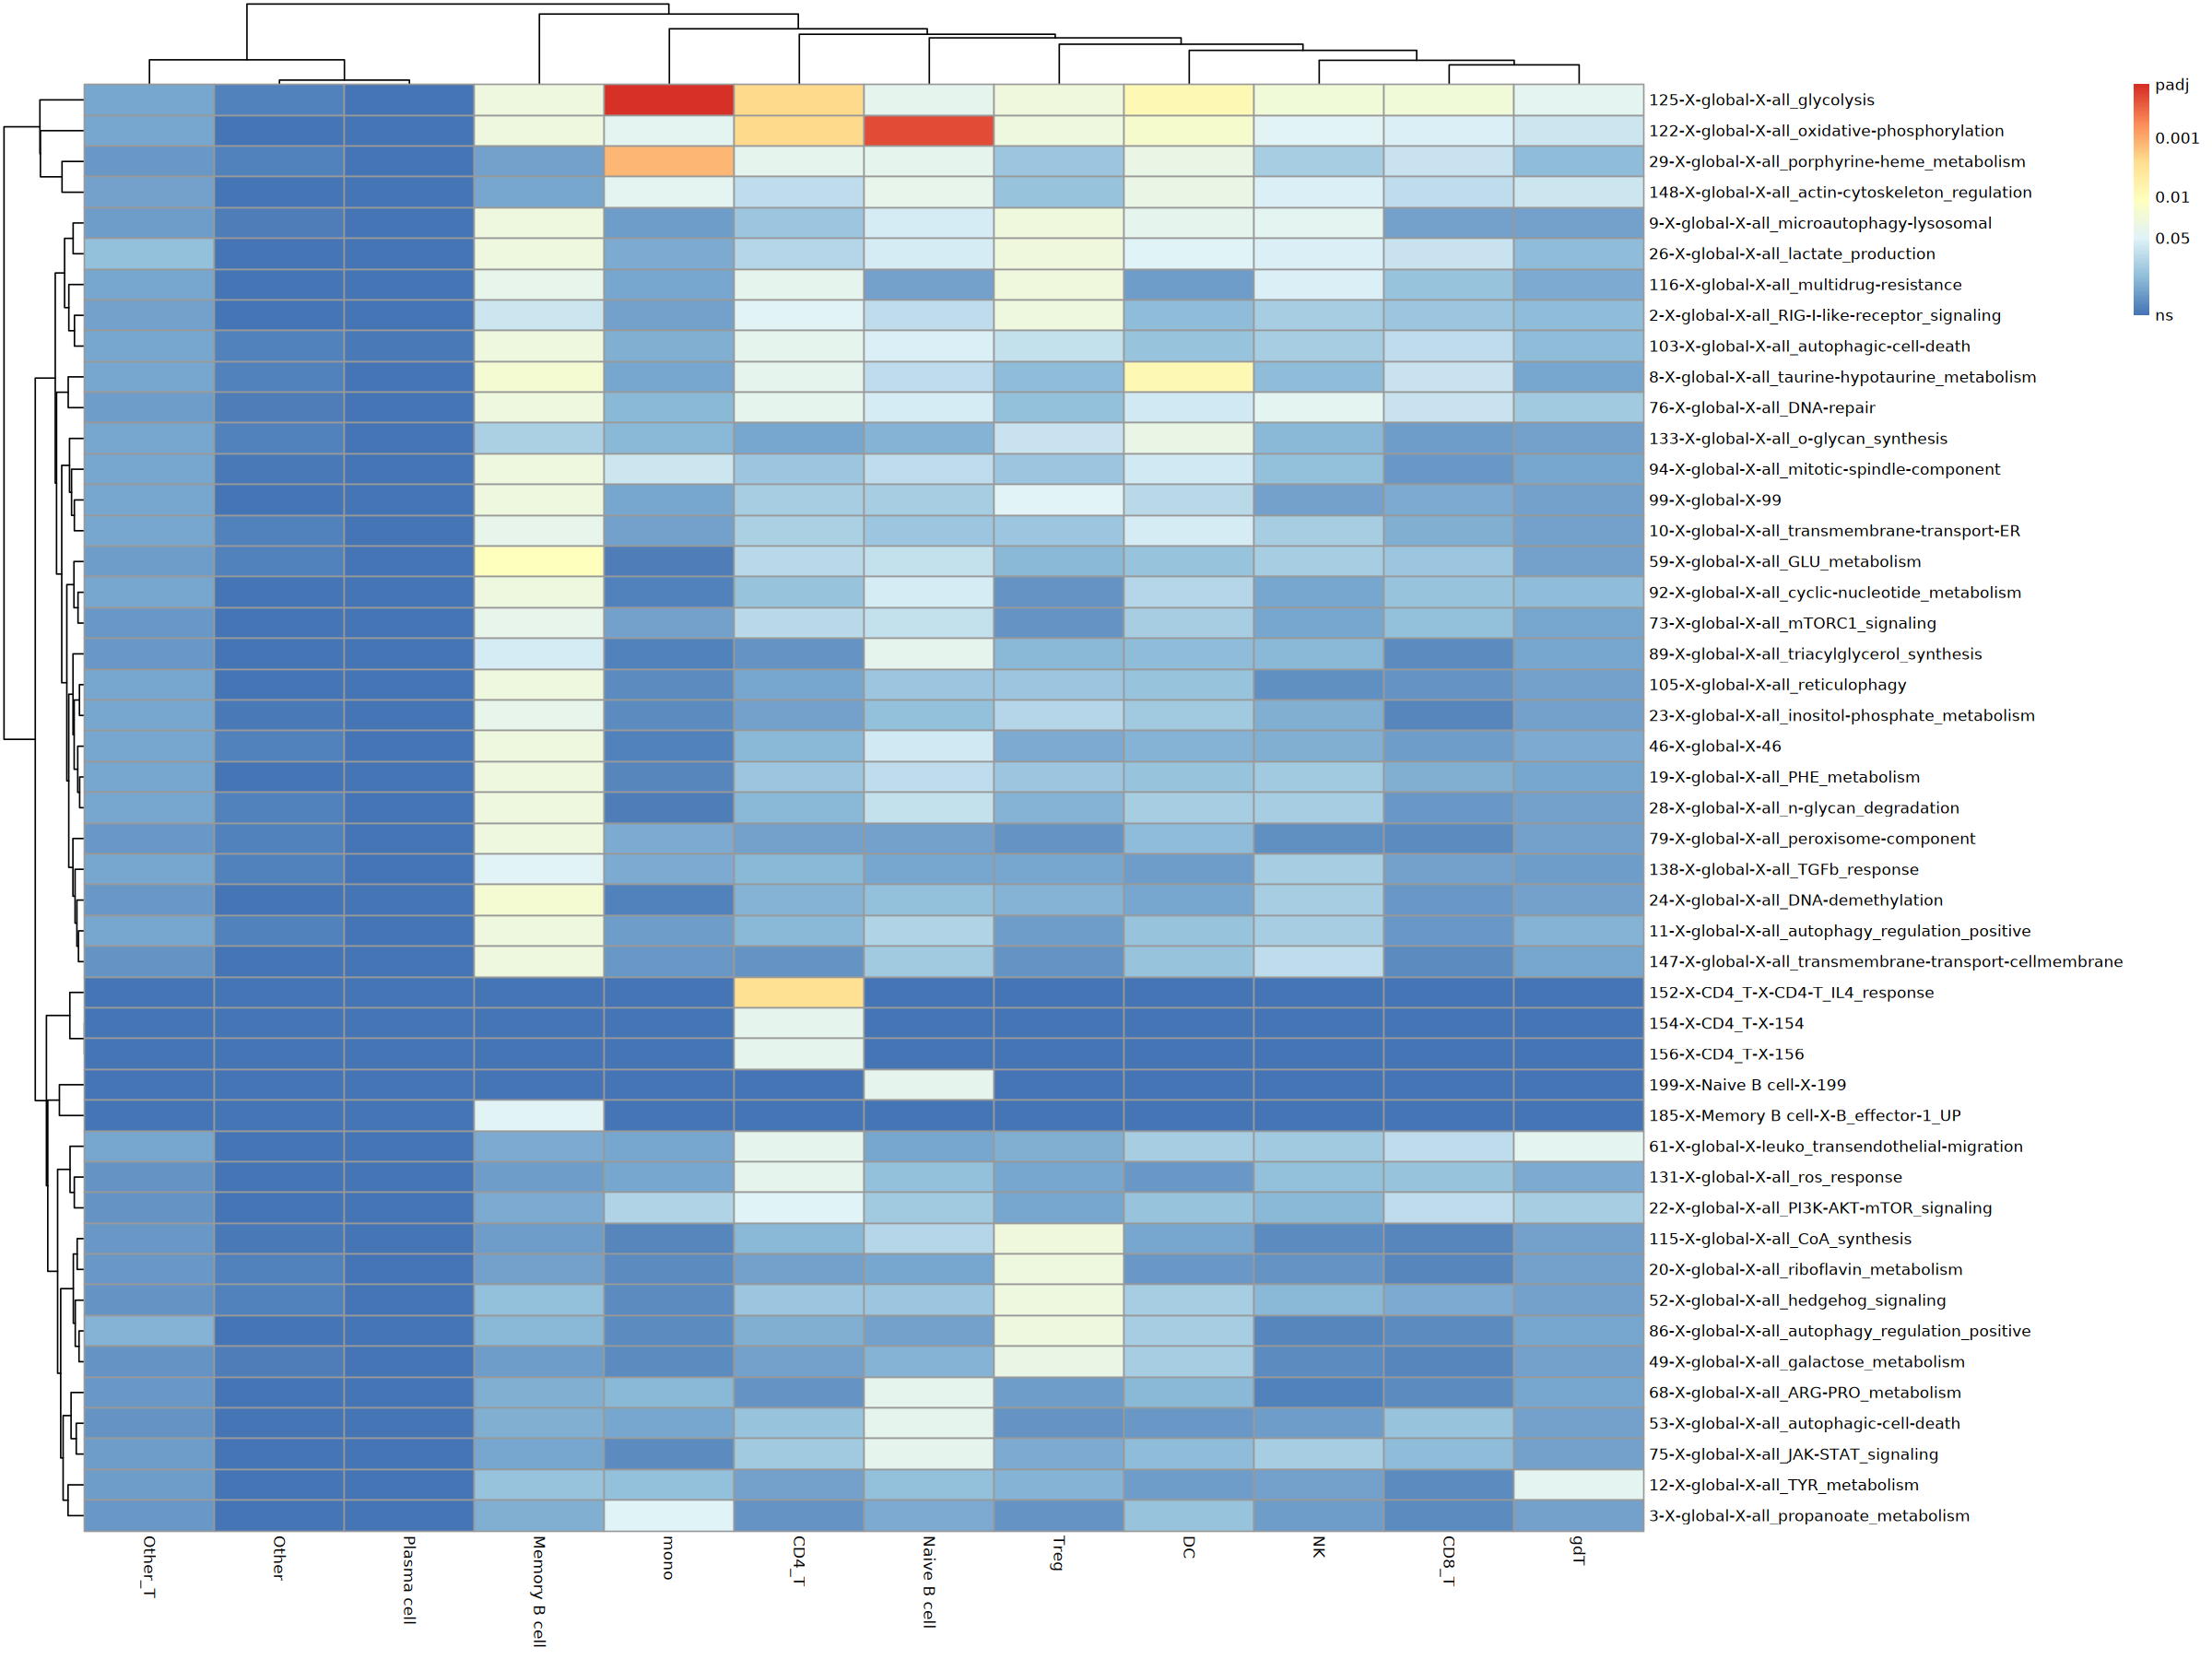

In [29]:
glm_results_sig <- glm_results_status %>% filter(p.adj < 0.05)

glm_ari_sigp <- glm_results_status %>%
    filter(Spectra_factor %in% glm_results_sig$Spectra_factor & term == "statusARI") %>%
    pivot_wider(id_cols = "AIFI_L1_5", names_from = "Spectra_factor", values_from = "p.adj", values_fill = 1)
glm_ari_sigp_mx <- glm_ari_sigp %>%
    select(-AIFI_L1_5) %>%
    as.matrix()
glm_ari_sigp_mx <- -log10(glm_ari_sigp_mx)
rownames(glm_ari_sigp_mx) <- glm_ari_sigp$AIFI_L1_5
col_fun <- wesanderson::wes_palette("Zissou1", 20, type = "continuous")

p1 <- pheatmap::pheatmap(t(glm_ari_sigp_mx),
    display_numbers = FALSE,
    legend_breaks = c(0, -log10(0.05), -log10(0.01), -log10(0.001), max(glm_ari_sigp_mx)),
    legend_labels = c("ns", "0.05", "0.01", "0.001", "padj")
)
save_pheatmap_pdf(p1, filename = file.path(fig_path, paste0(proj_name, "glm_statusARI_heatmap.pdf")), width = 10, height = 8)


png 
  2

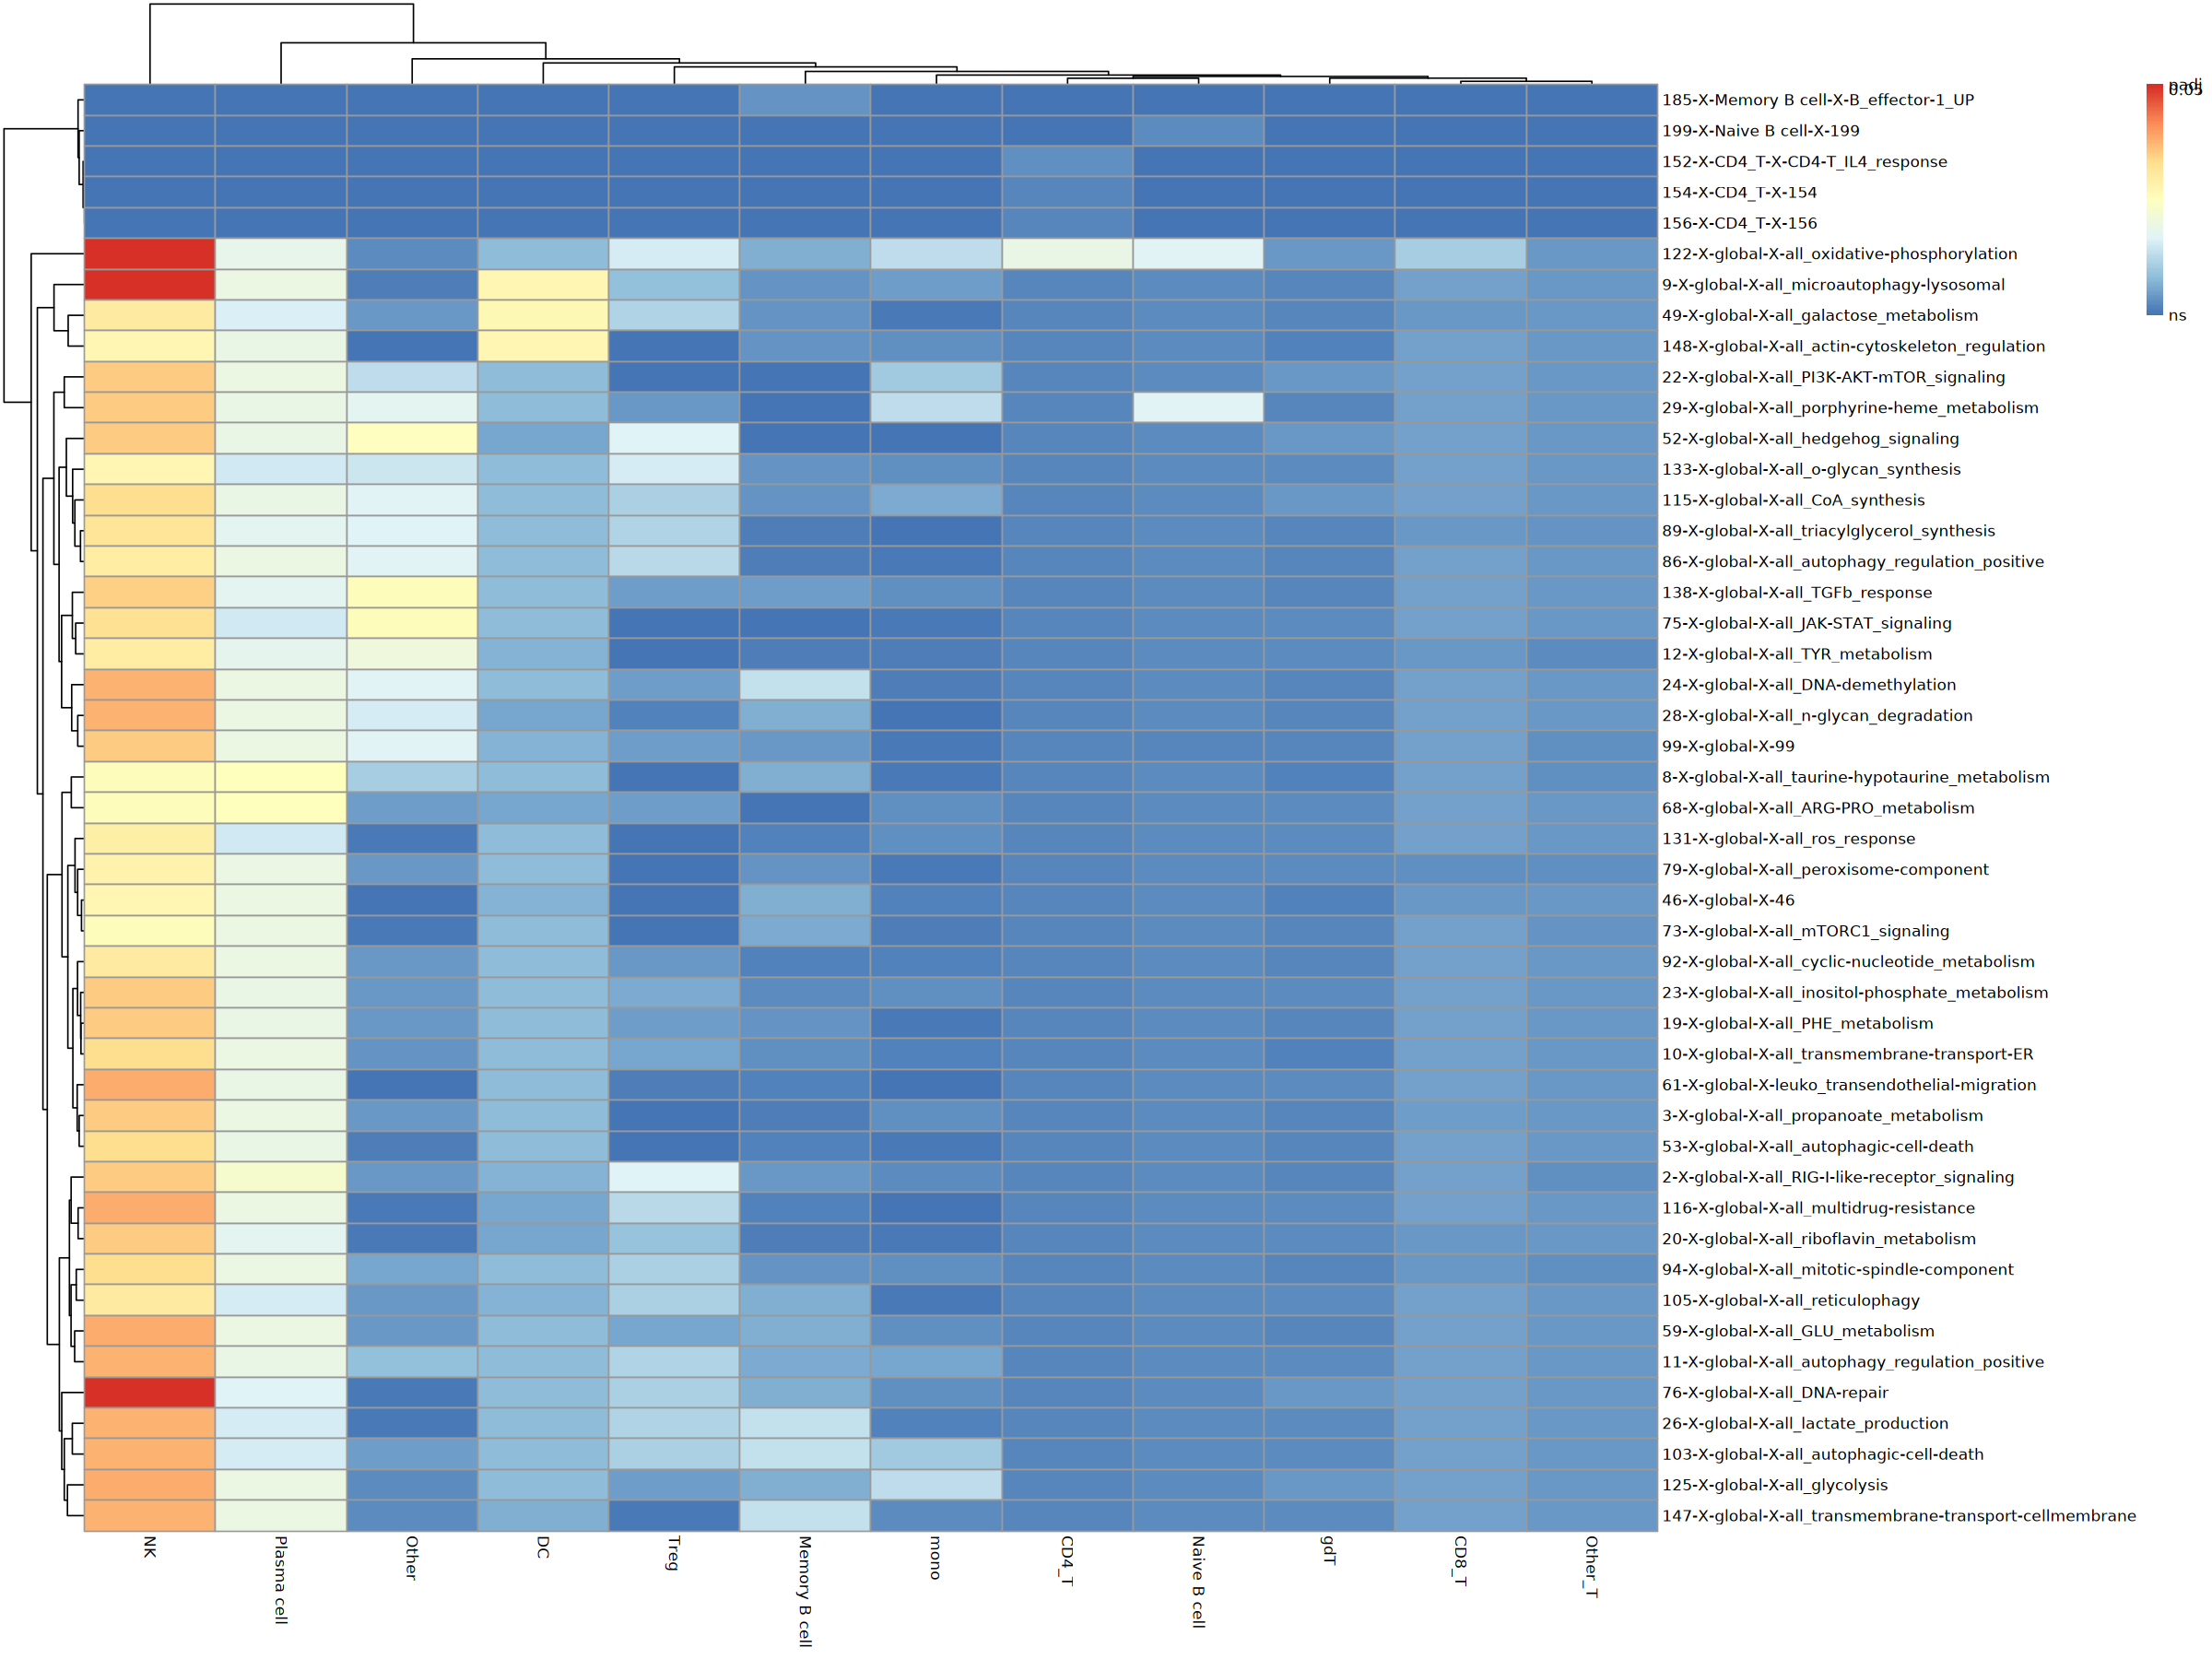

In [30]:
glm_results_sig <- glm_results_status %>% filter(p.adj < 0.05)

glm_ari_sigp <- glm_results_status %>%
    filter(Spectra_factor %in% glm_results_sig$Spectra_factor & term == "statusERA") %>%
    pivot_wider(id_cols = "AIFI_L1_5", names_from = "Spectra_factor", values_from = "p.adj", values_fill = 1)
glm_ari_sigp_mx <- glm_ari_sigp %>%
    select(-AIFI_L1_5) %>%
    as.matrix()
glm_ari_sigp_mx <- -log10(glm_ari_sigp_mx)
rownames(glm_ari_sigp_mx) <- glm_ari_sigp$AIFI_L1_5
col_fun <- wesanderson::wes_palette("Zissou1", 20, type = "continuous")

p1 <- pheatmap::pheatmap(t(glm_ari_sigp_mx),
    display_numbers = FALSE,
    legend_breaks = c(0, -log10(0.05), -log10(0.01), -log10(0.001), max(glm_ari_sigp_mx)),
    legend_labels = c("ns", "0.05", "0.01", "0.001", "padj")
)
save_pheatmap_pdf(p1, filename = file.path(fig_path, paste0(proj_name, "glm_statusERA_heatmap.pdf")), width = 10, height = 8)


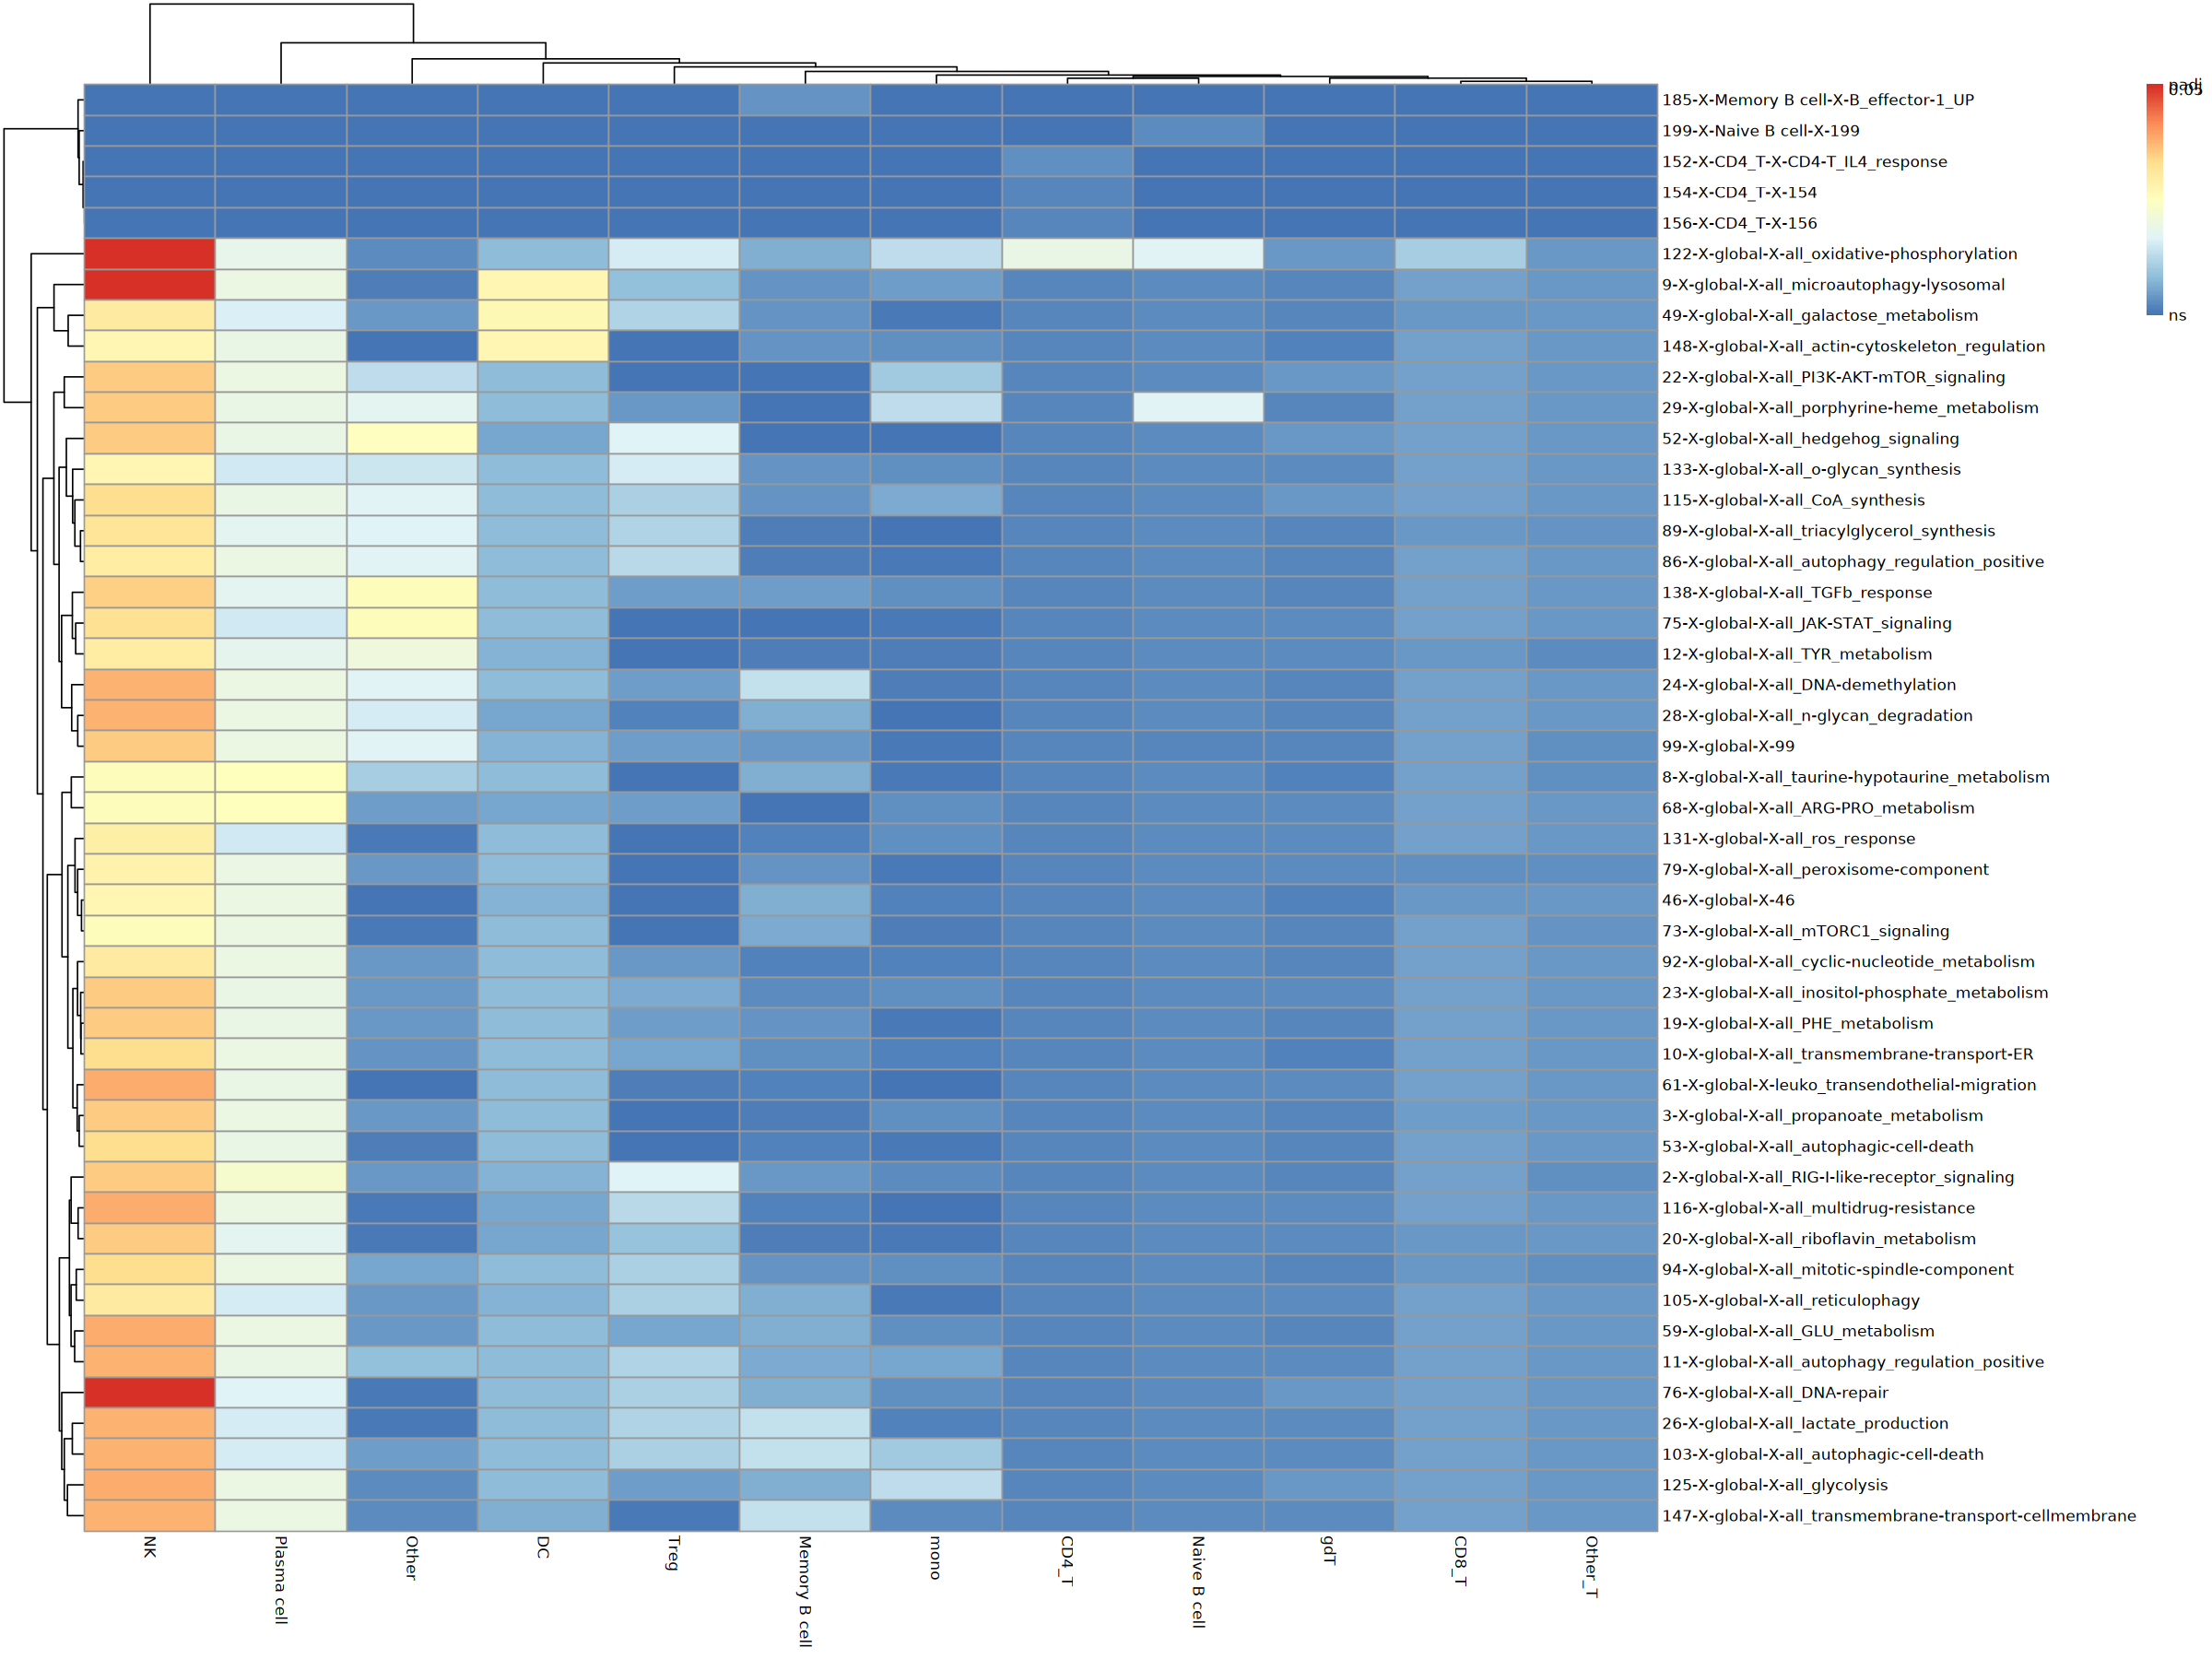

In [31]:
p1


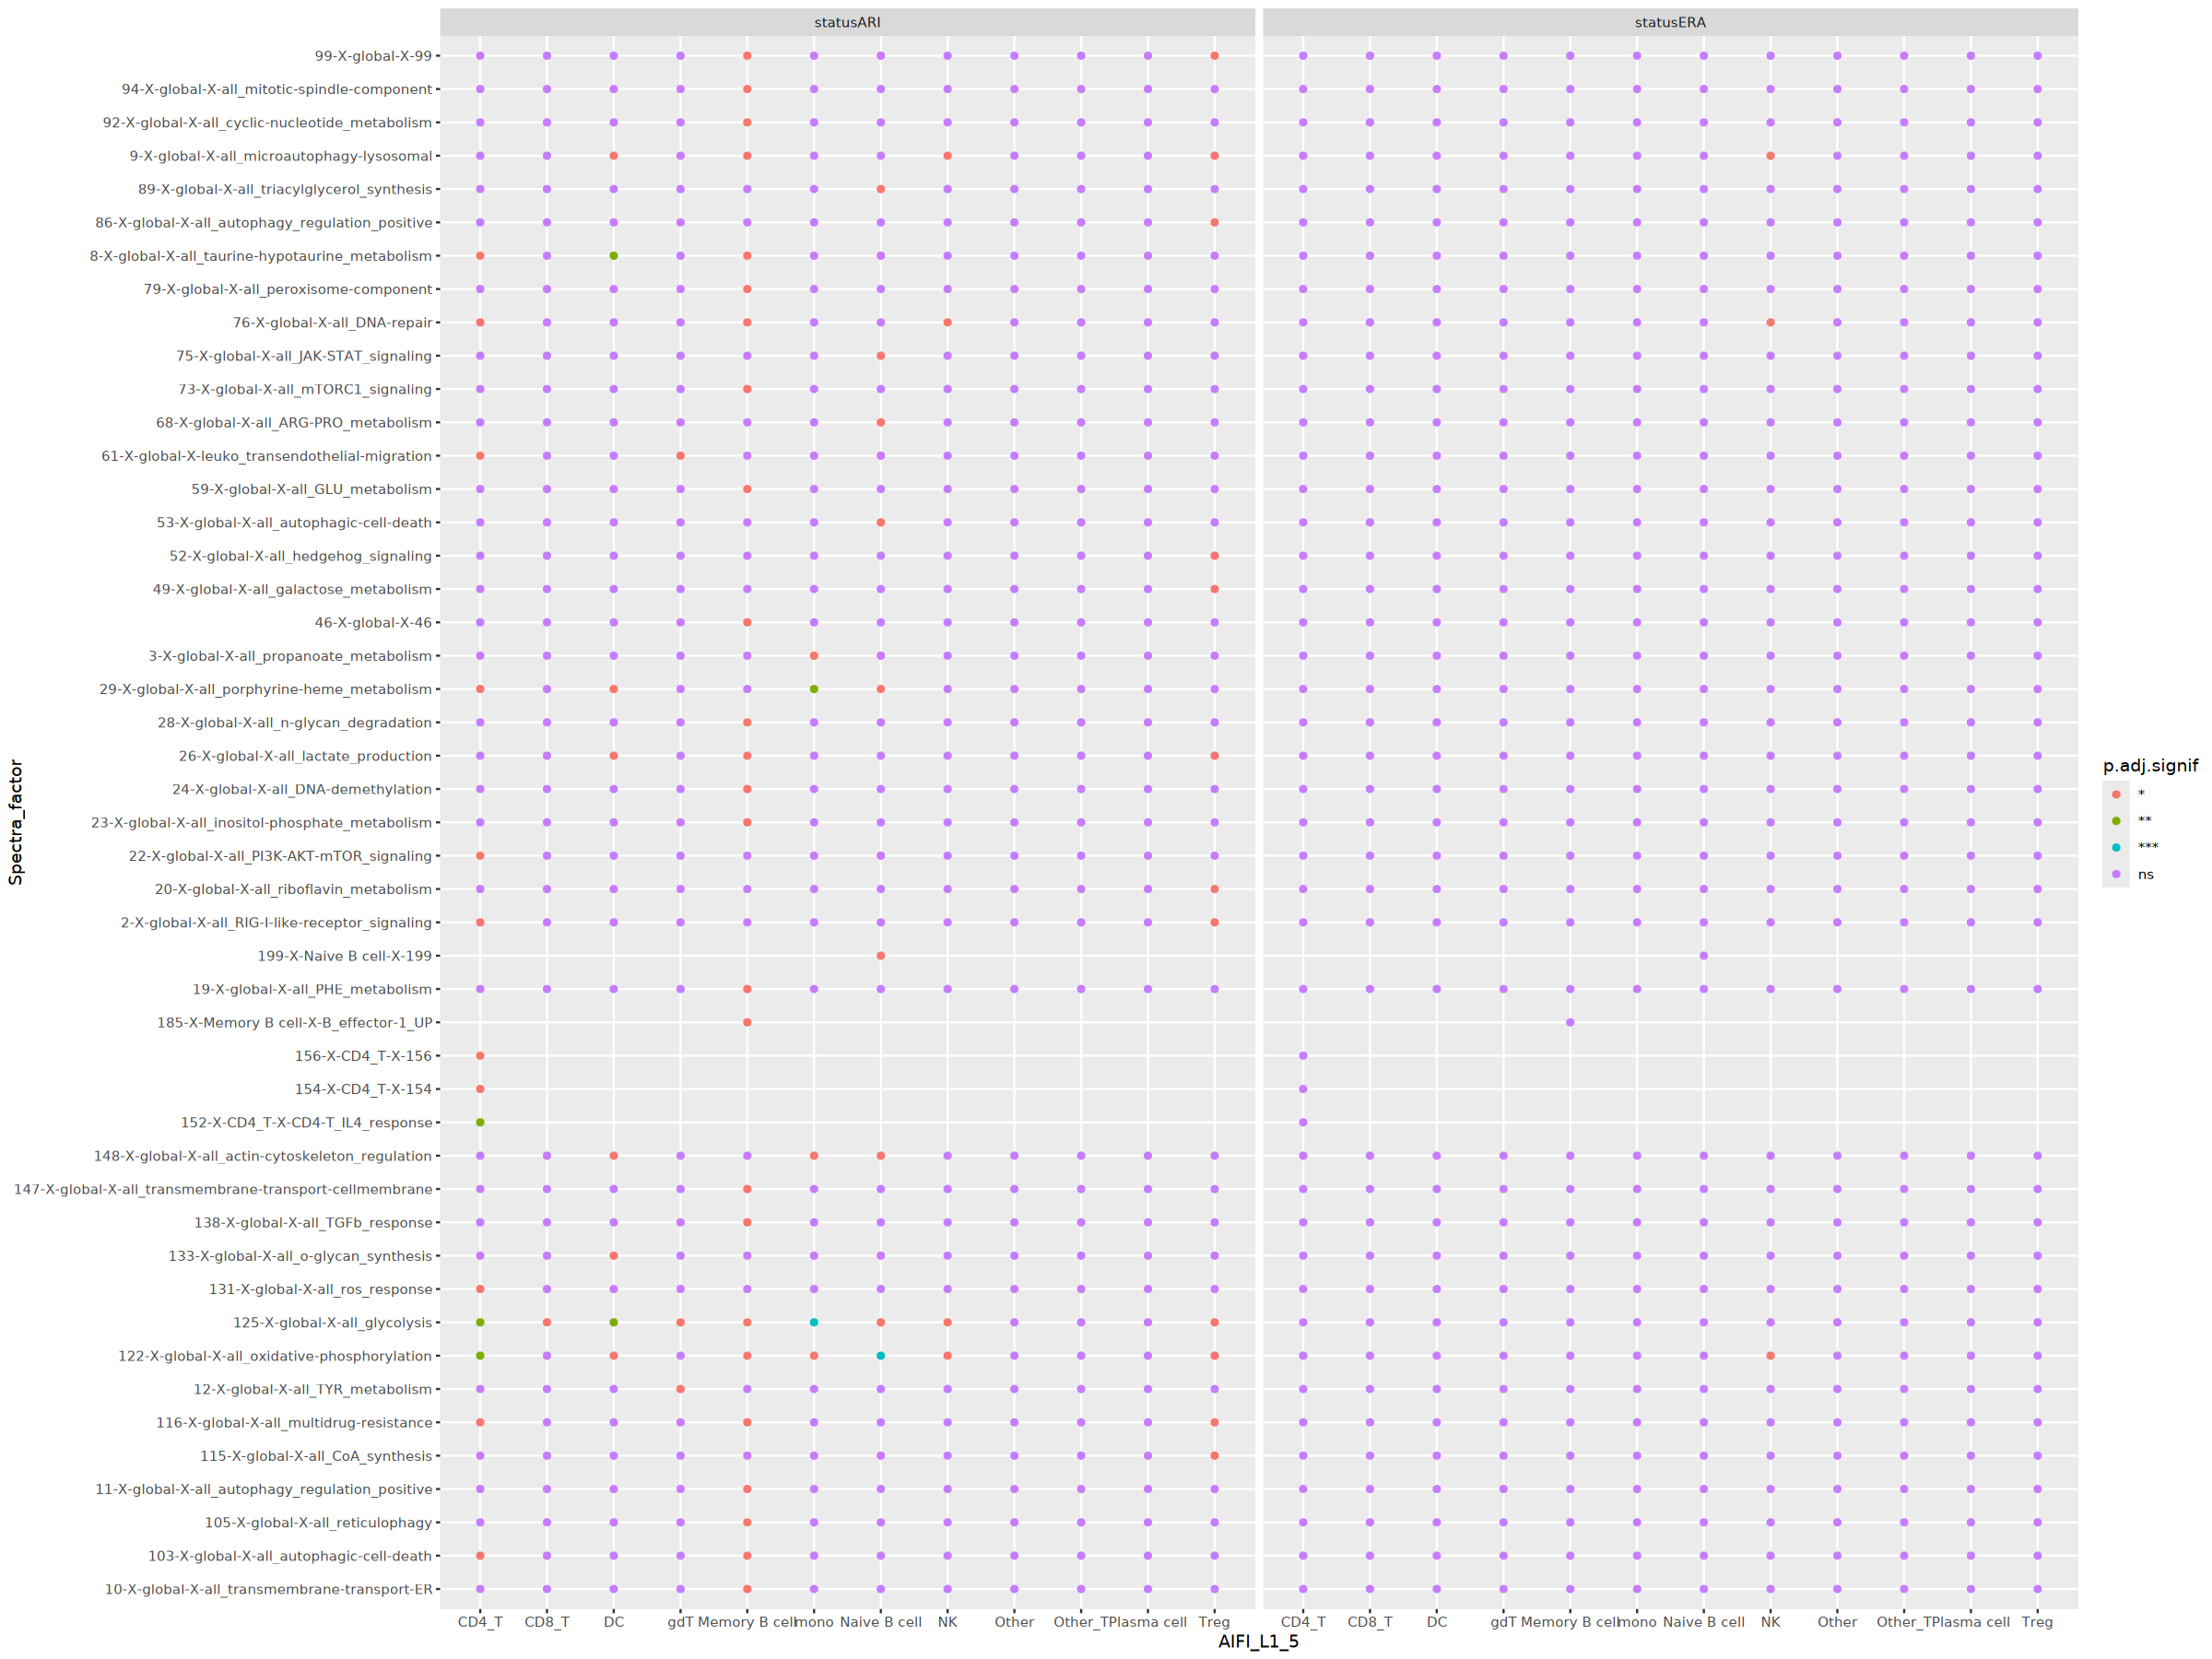

In [33]:
ggplot(
       glm_results_status %>% filter(Spectra_factor %in% glm_results_sig$Spectra_factor),
       aes(x = AIFI_L1_5, y = Spectra_factor, color = p.adj.signif)
) +
       geom_point() +
       facet_wrap(vars(term))


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


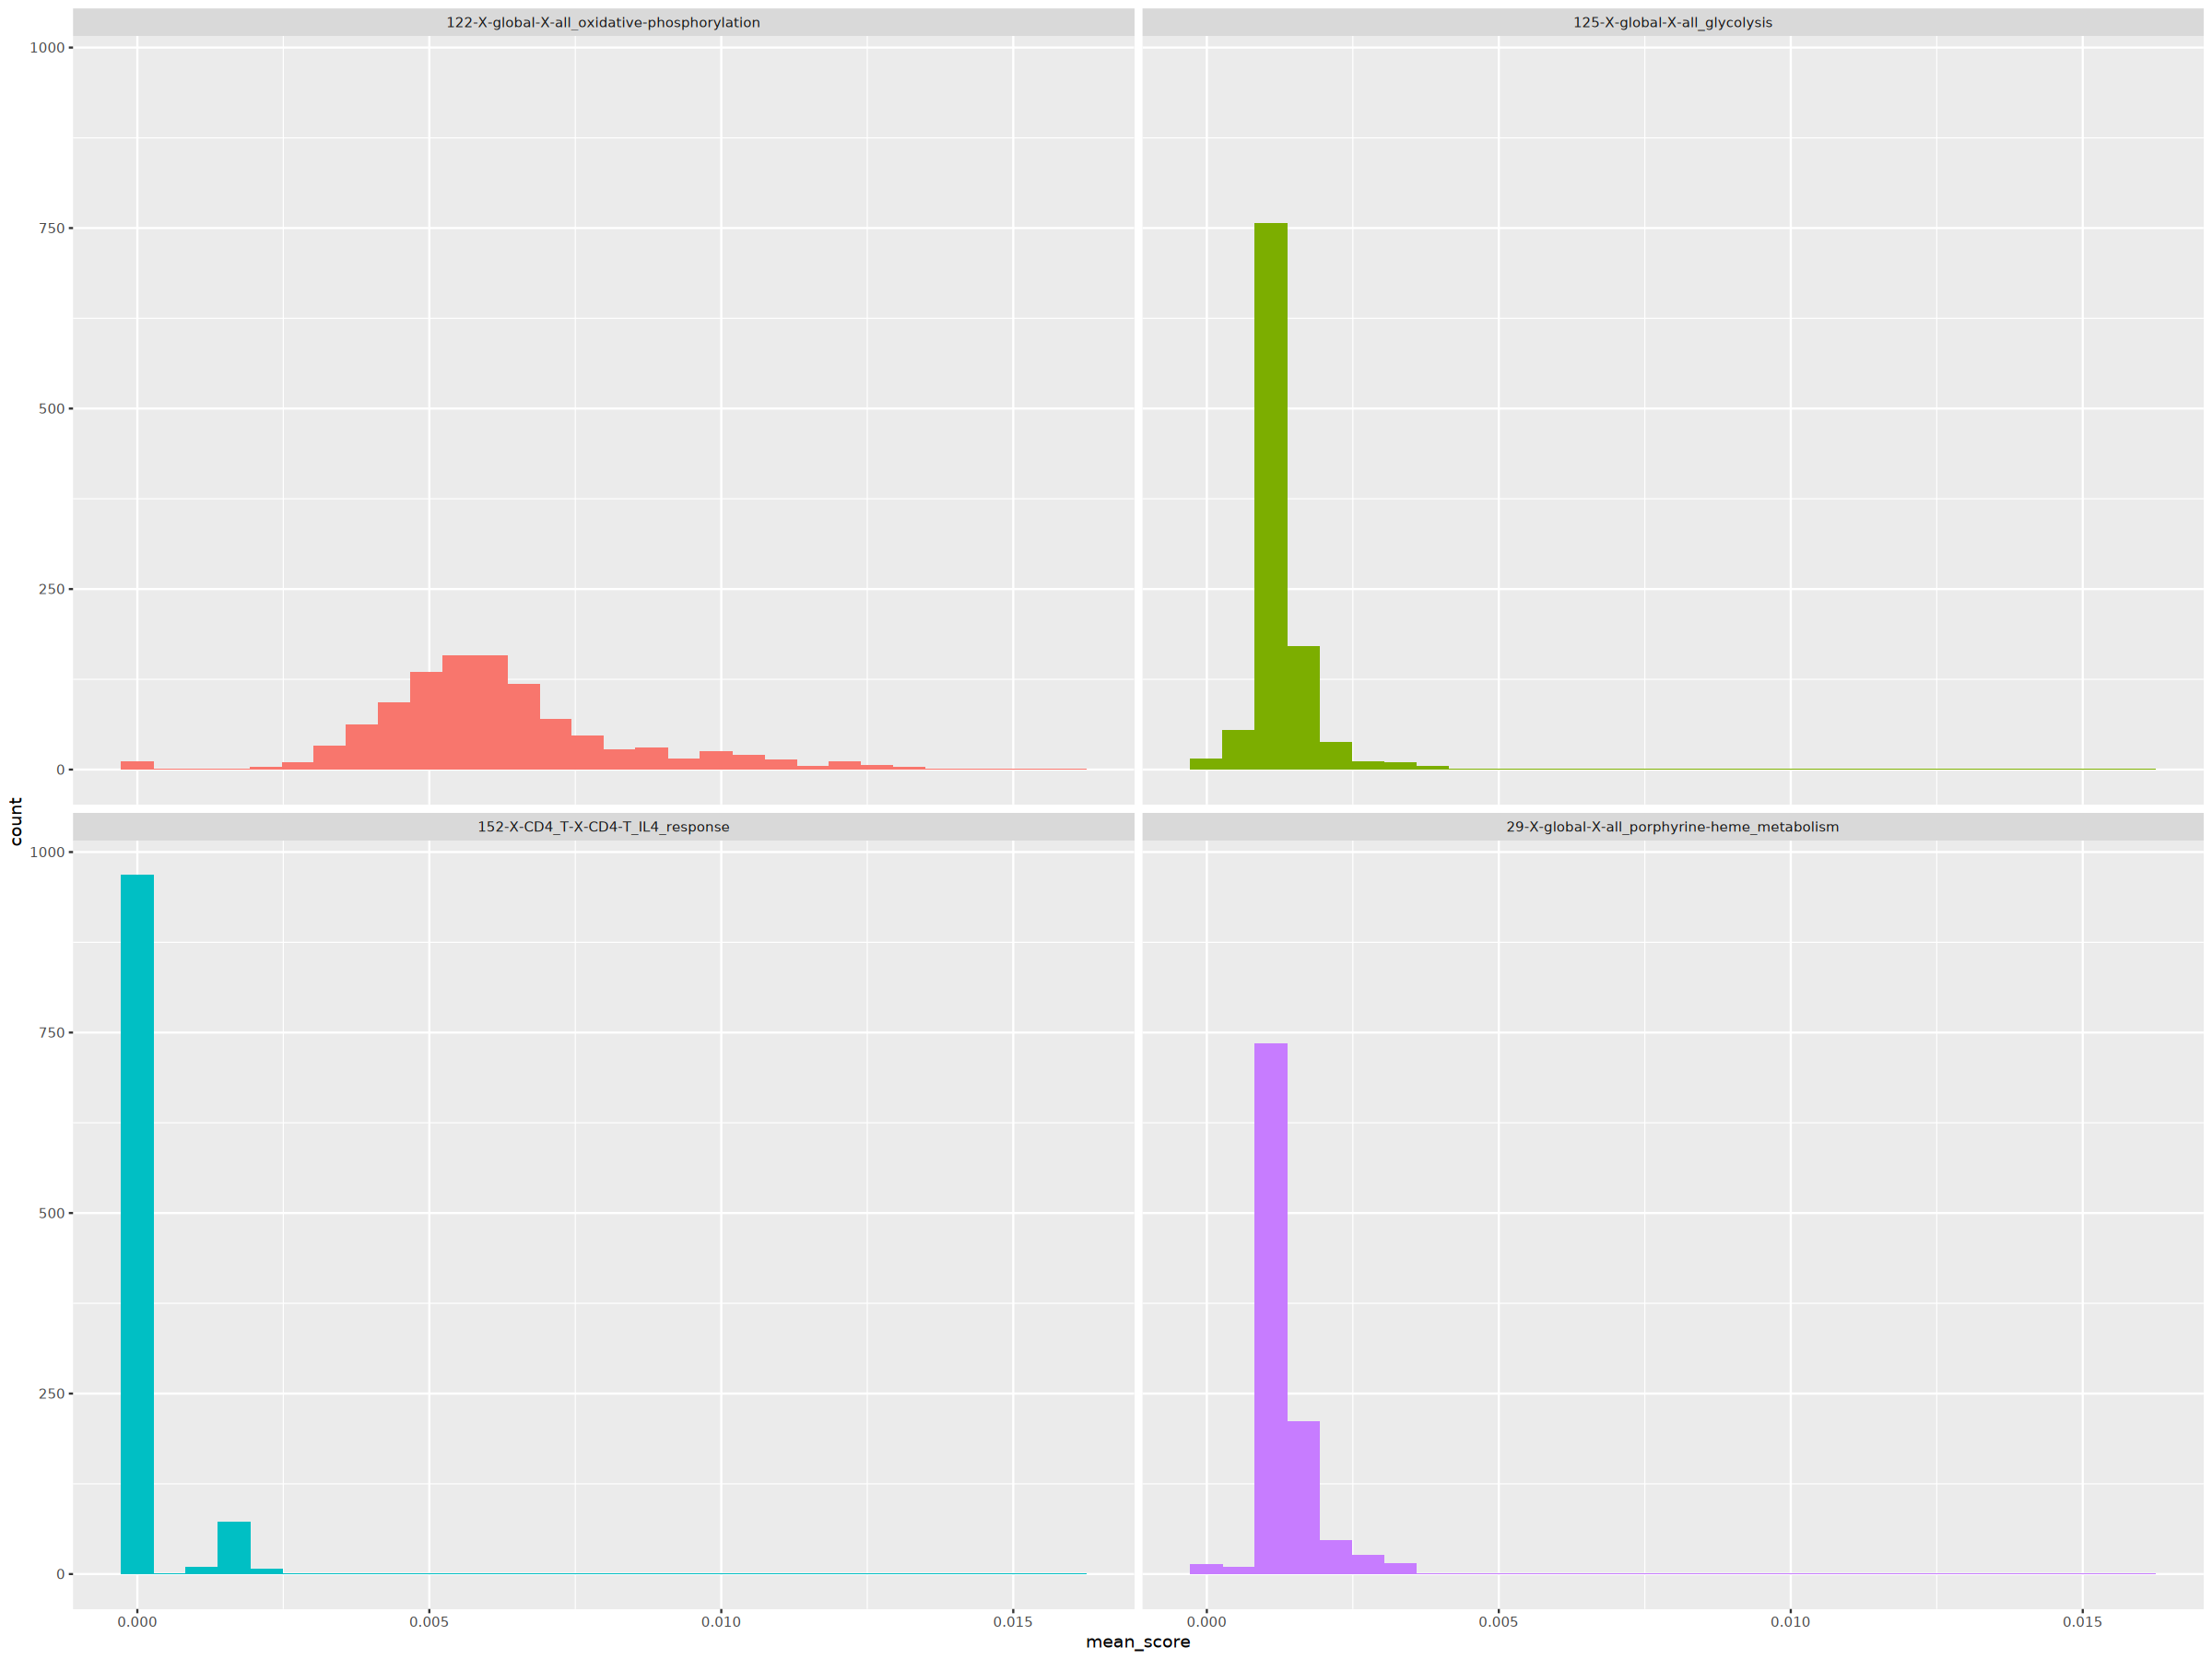

In [34]:
factor_check <- c(
    "125-X-global-X-all_glycolysis", "122-X-global-X-all_oxidative-phosphorylation",
    "29-X-global-X-all_porphyrine-heme_metabolism", "152-X-CD4_T-X-CD4-T_IL4_response"
)
spec_scores_fl %>%
    filter(Spectra_factor %in% factor_check) %>%
    ggplot(aes(x = mean_score, fill = Spectra_factor)) +
    facet_wrap(vars(Spectra_factor)) +
    geom_histogram() +
    guides(fill = "none")


In [35]:
# add top10 gene into the results table
glm_results_status <- glm_results_status %>% left_join(top10_genes, by = "Spectra_factor")


In [37]:
glm_results_status %>% write_csv(file.path(output_path, paste0(proj_name, "factor_glm_test_result.csv")))


In [ ]:
### check correaltion with the factors
spec_scores_cor <- spec_scores_fl %>%
    filter(str_detect(Spectra_factor, "X-global-X")) %>%
    select(c(sample.sampleKitGuid, AIFI_L1_5, Spectra_factor, mean_score)) %>%
    pivot_wider(names_from = "Spectra_factor", values_from = "mean_score")
spec_scores_cor_mx <- spec_scores_cor %>%
    select(-c(sample.sampleKitGuid, AIFI_L1_5)) %>%
    cor()


In [ ]:
library(ggcorrplot)
ggcorrplot(spec_scores_cor_mx, type = "lower") + theme(axis.title = element_blank())


## plot the factor values and check gene weight

In [48]:
PlotFactor <- function(spec_scores_fl, factor_name, fig_path, proj_name,
                       width = 16, height = 12) {
    # Ensure necessary libraries are loaded
    require(ggplot2)
    require(ggpubr)
    spec_scores_factor <- spec_scores_fl %>%
        filter(Spectra_factor == factor_name)
    cell_types <- unique(spec_scores_factor$AIFI_L1_5)

    p1 <- spec_scores_factor %>%
        ggpubr::ggviolin(
            x = "status", y = "mean_score",
            color = "status", # shape = "batch_corr",
            add = "jitter", palette = ari_colors,
            xlab = "", ylab = "Mean factor score", title = factor_name
        ) +
        facet_wrap(vars(AIFI_L1_5), scale = "free_y")
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
        ggtitle(factor_name)


    # # Save the plot
    ggsave(file.path(fig_path, paste0(proj_name, factor_name, "_pathway_enrichment_violinplot.pdf")),
        plot = p1, width = width, height = height
    )
    return(p1)
}

# Example usage:
# my_comparisons <- list(c("ALTRA_healthy", "at_risk"), c("ALTRA_healthy", "early_RA"), c("at_risk", "early_RA"))
# pvalue_table <- data.frame(comparison = c("ALTRA_healthy vs at_risk", "ALTRA_healthy vs early_RA", "at_risk vs early_RA"),
#                            p.adj = c(0.01, 0.05, 0.001))
# PlotFactor(spec_scores_fl, "some_factor", my_comparisons, "path/to/figures/", "project_name", pvalue_table)


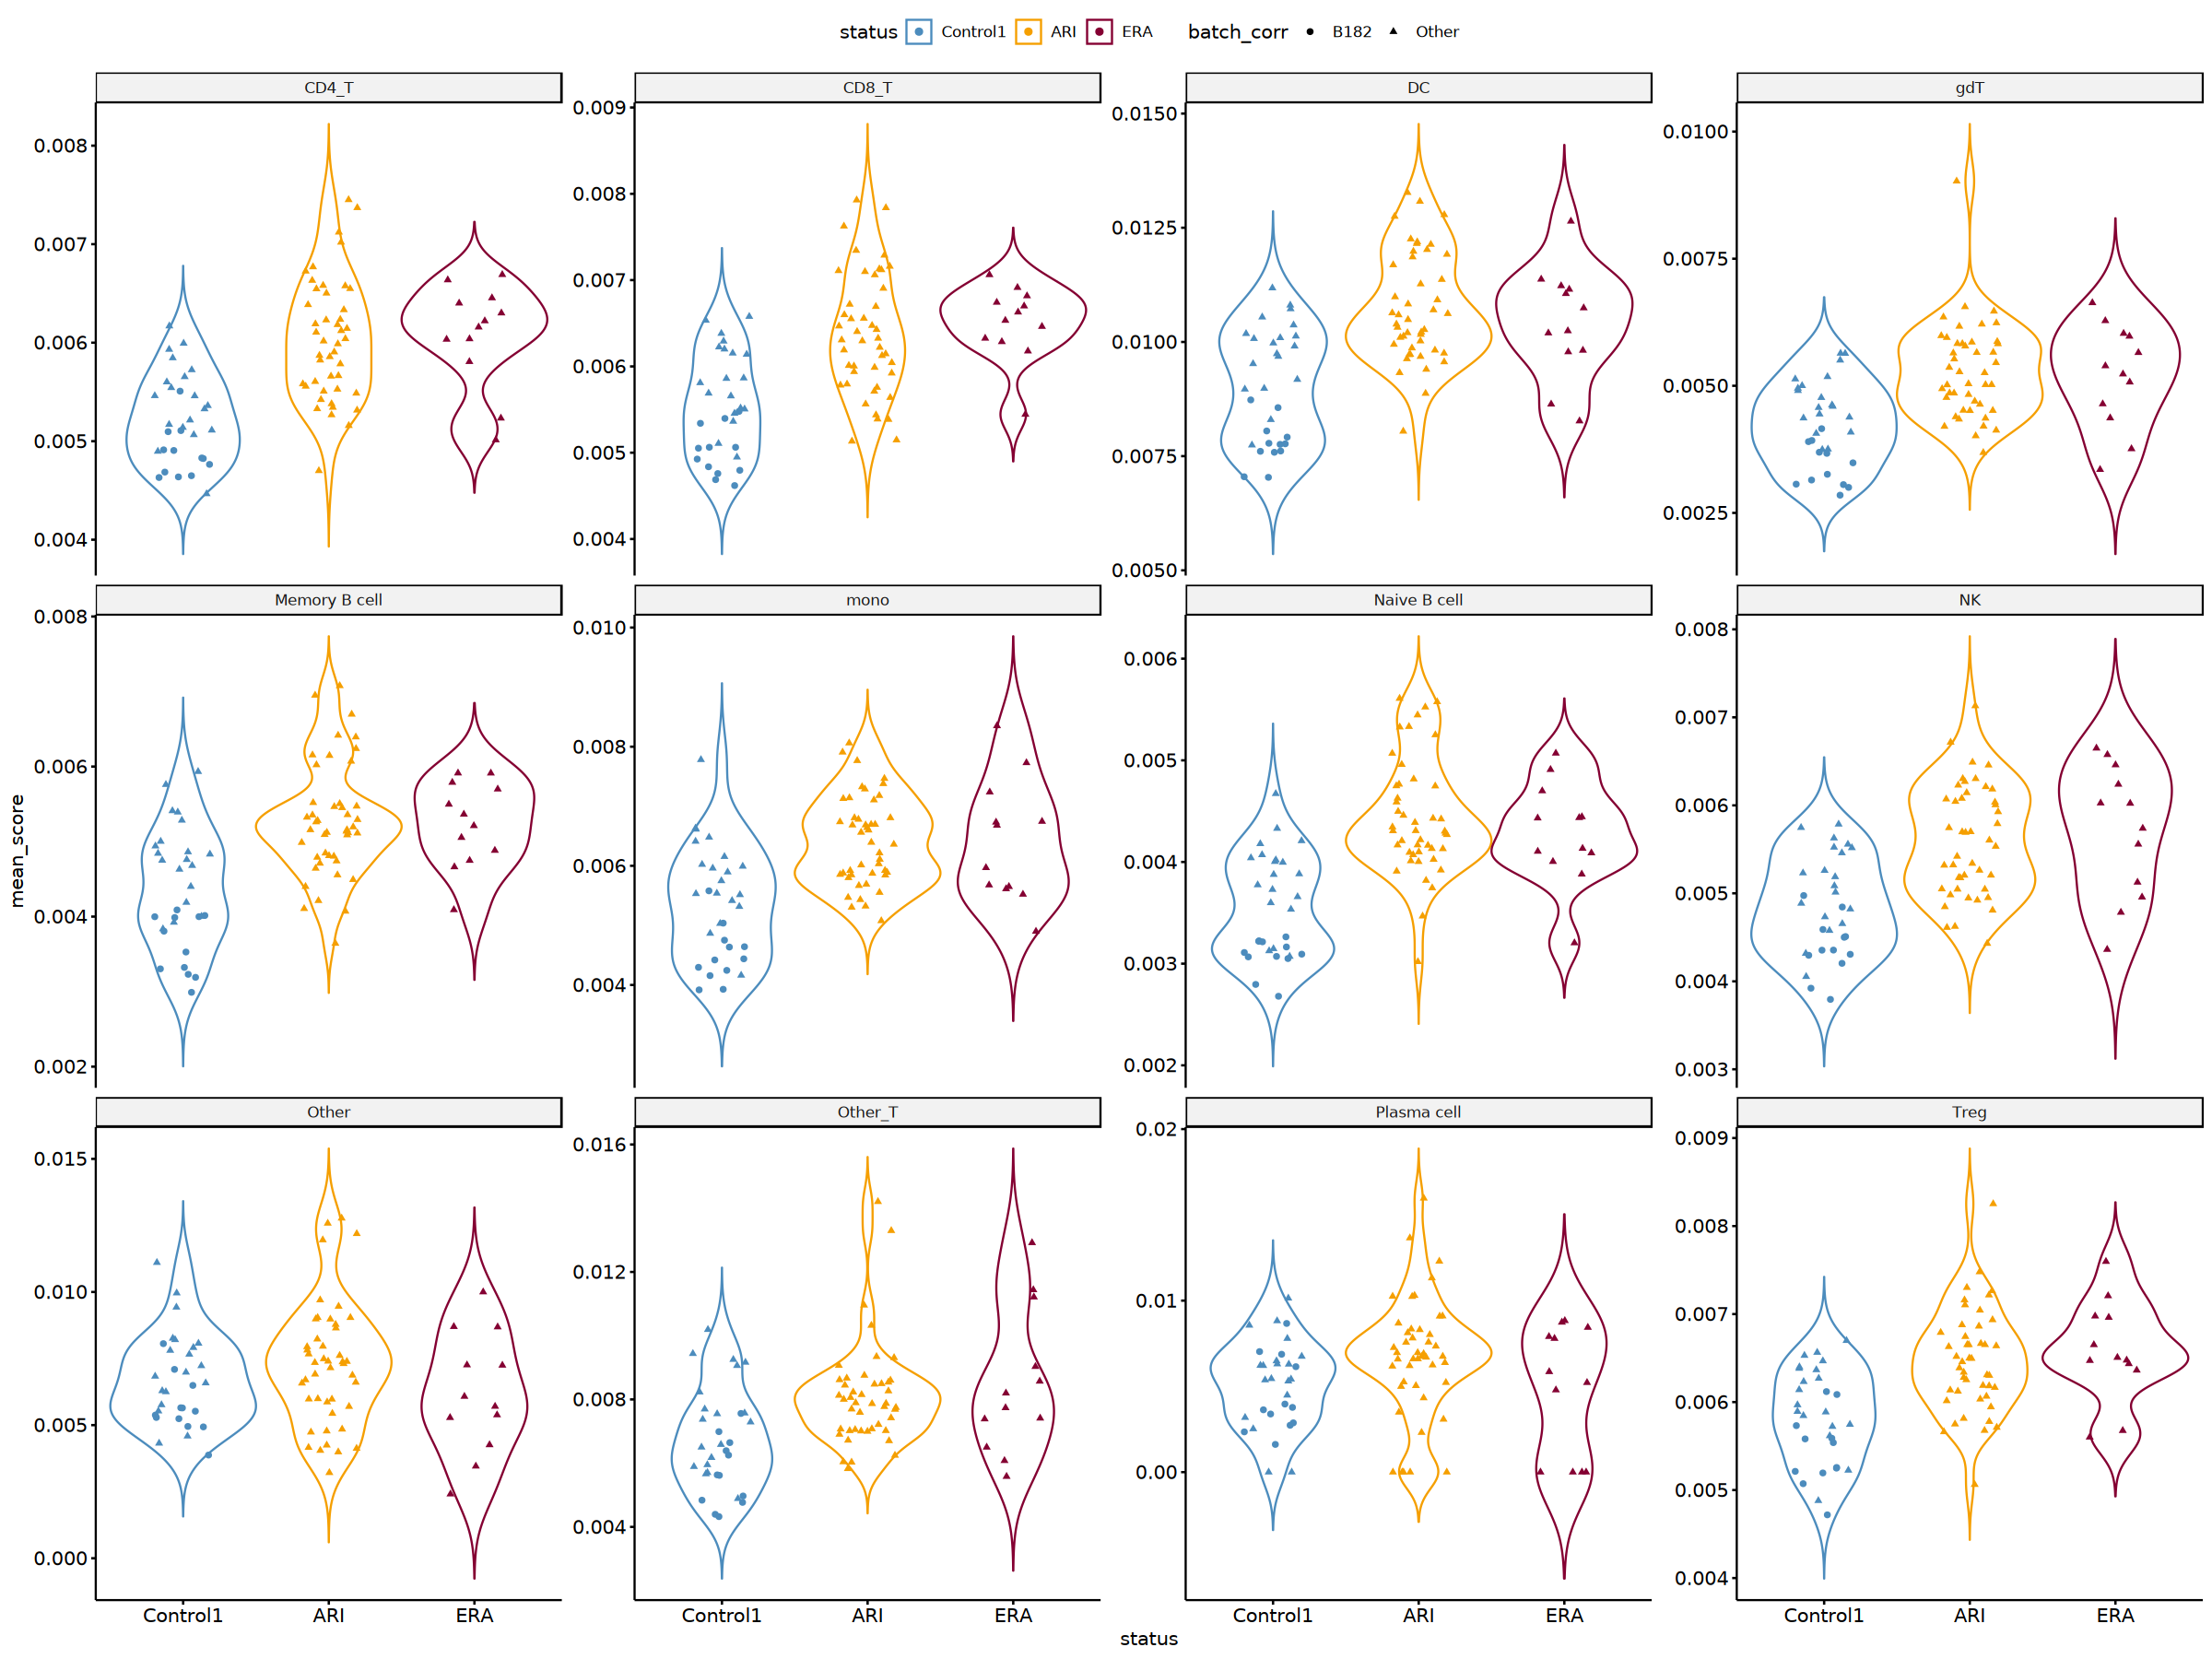

In [198]:
# plot the specific factor
factor_name <- "122-X-global-X-all_oxidative-phosphorylation"
p1 <- PlotFactor(spec_scores_fl,
    factor_name = factor_name, fig_path, proj_name
)
p1


In [244]:
# pvalue_table <- glm_results_status%>%
#     filter(Spectra_factor == '138-X-global-X-all_TGFb_response')%>%
#     mutate(group1 = 'ALTRA_healthy',
#            group2=recode(term, 'Status_Xsecat_risk' = 'at_risk', 'Status_Xsecearly_RA'='early_RA'))
# pvalue_table%>%head()


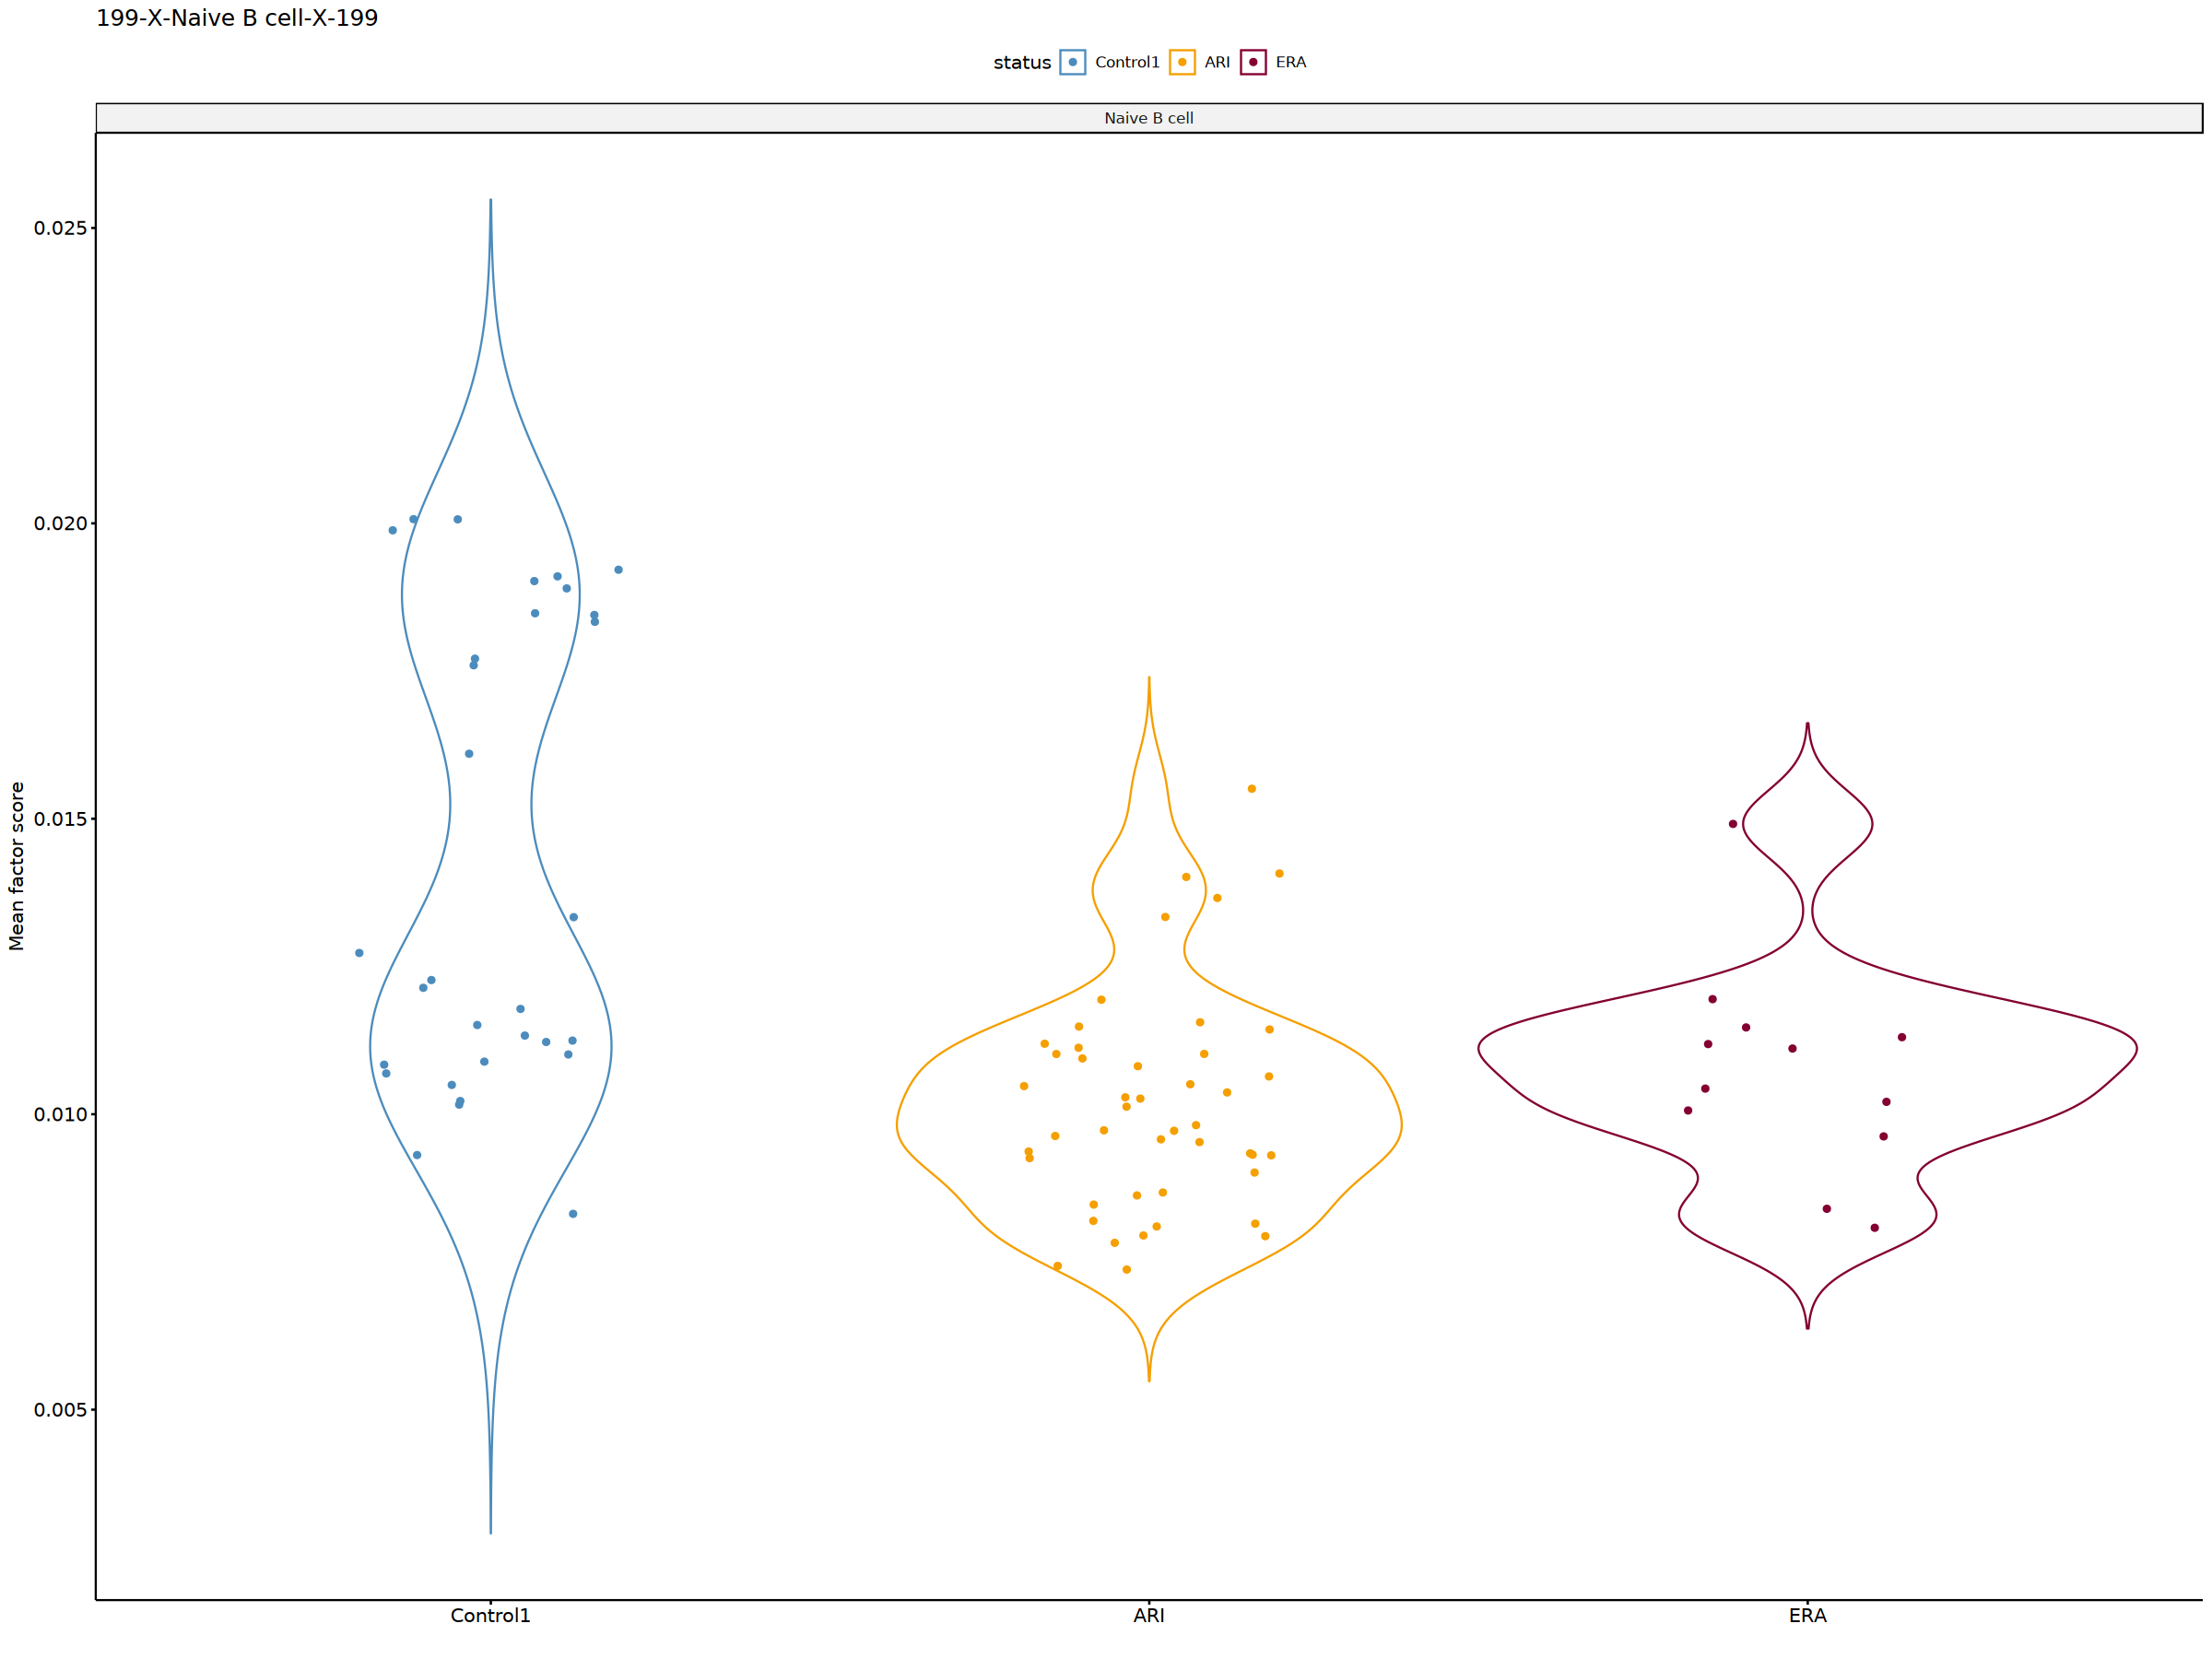

In [42]:
# plot the specific factor
factor_name <- "199-X-Naive B cell-X-199"
p1 <- PlotFactor(spec_scores_fl %>% filter(AIFI_L1_5 == "Naive B cell"), factor_name, fig_path, proj_name)
p1


In [ ]:
# plot the specific factor
factor_name <- "199-X-Naive B cell-X-199"
p1 <- PlotFactor(spec_scores_fl %>% filter(AIFI_L1_5 == "Naive B cell"), factor_name, fig_path, proj_name)
p1


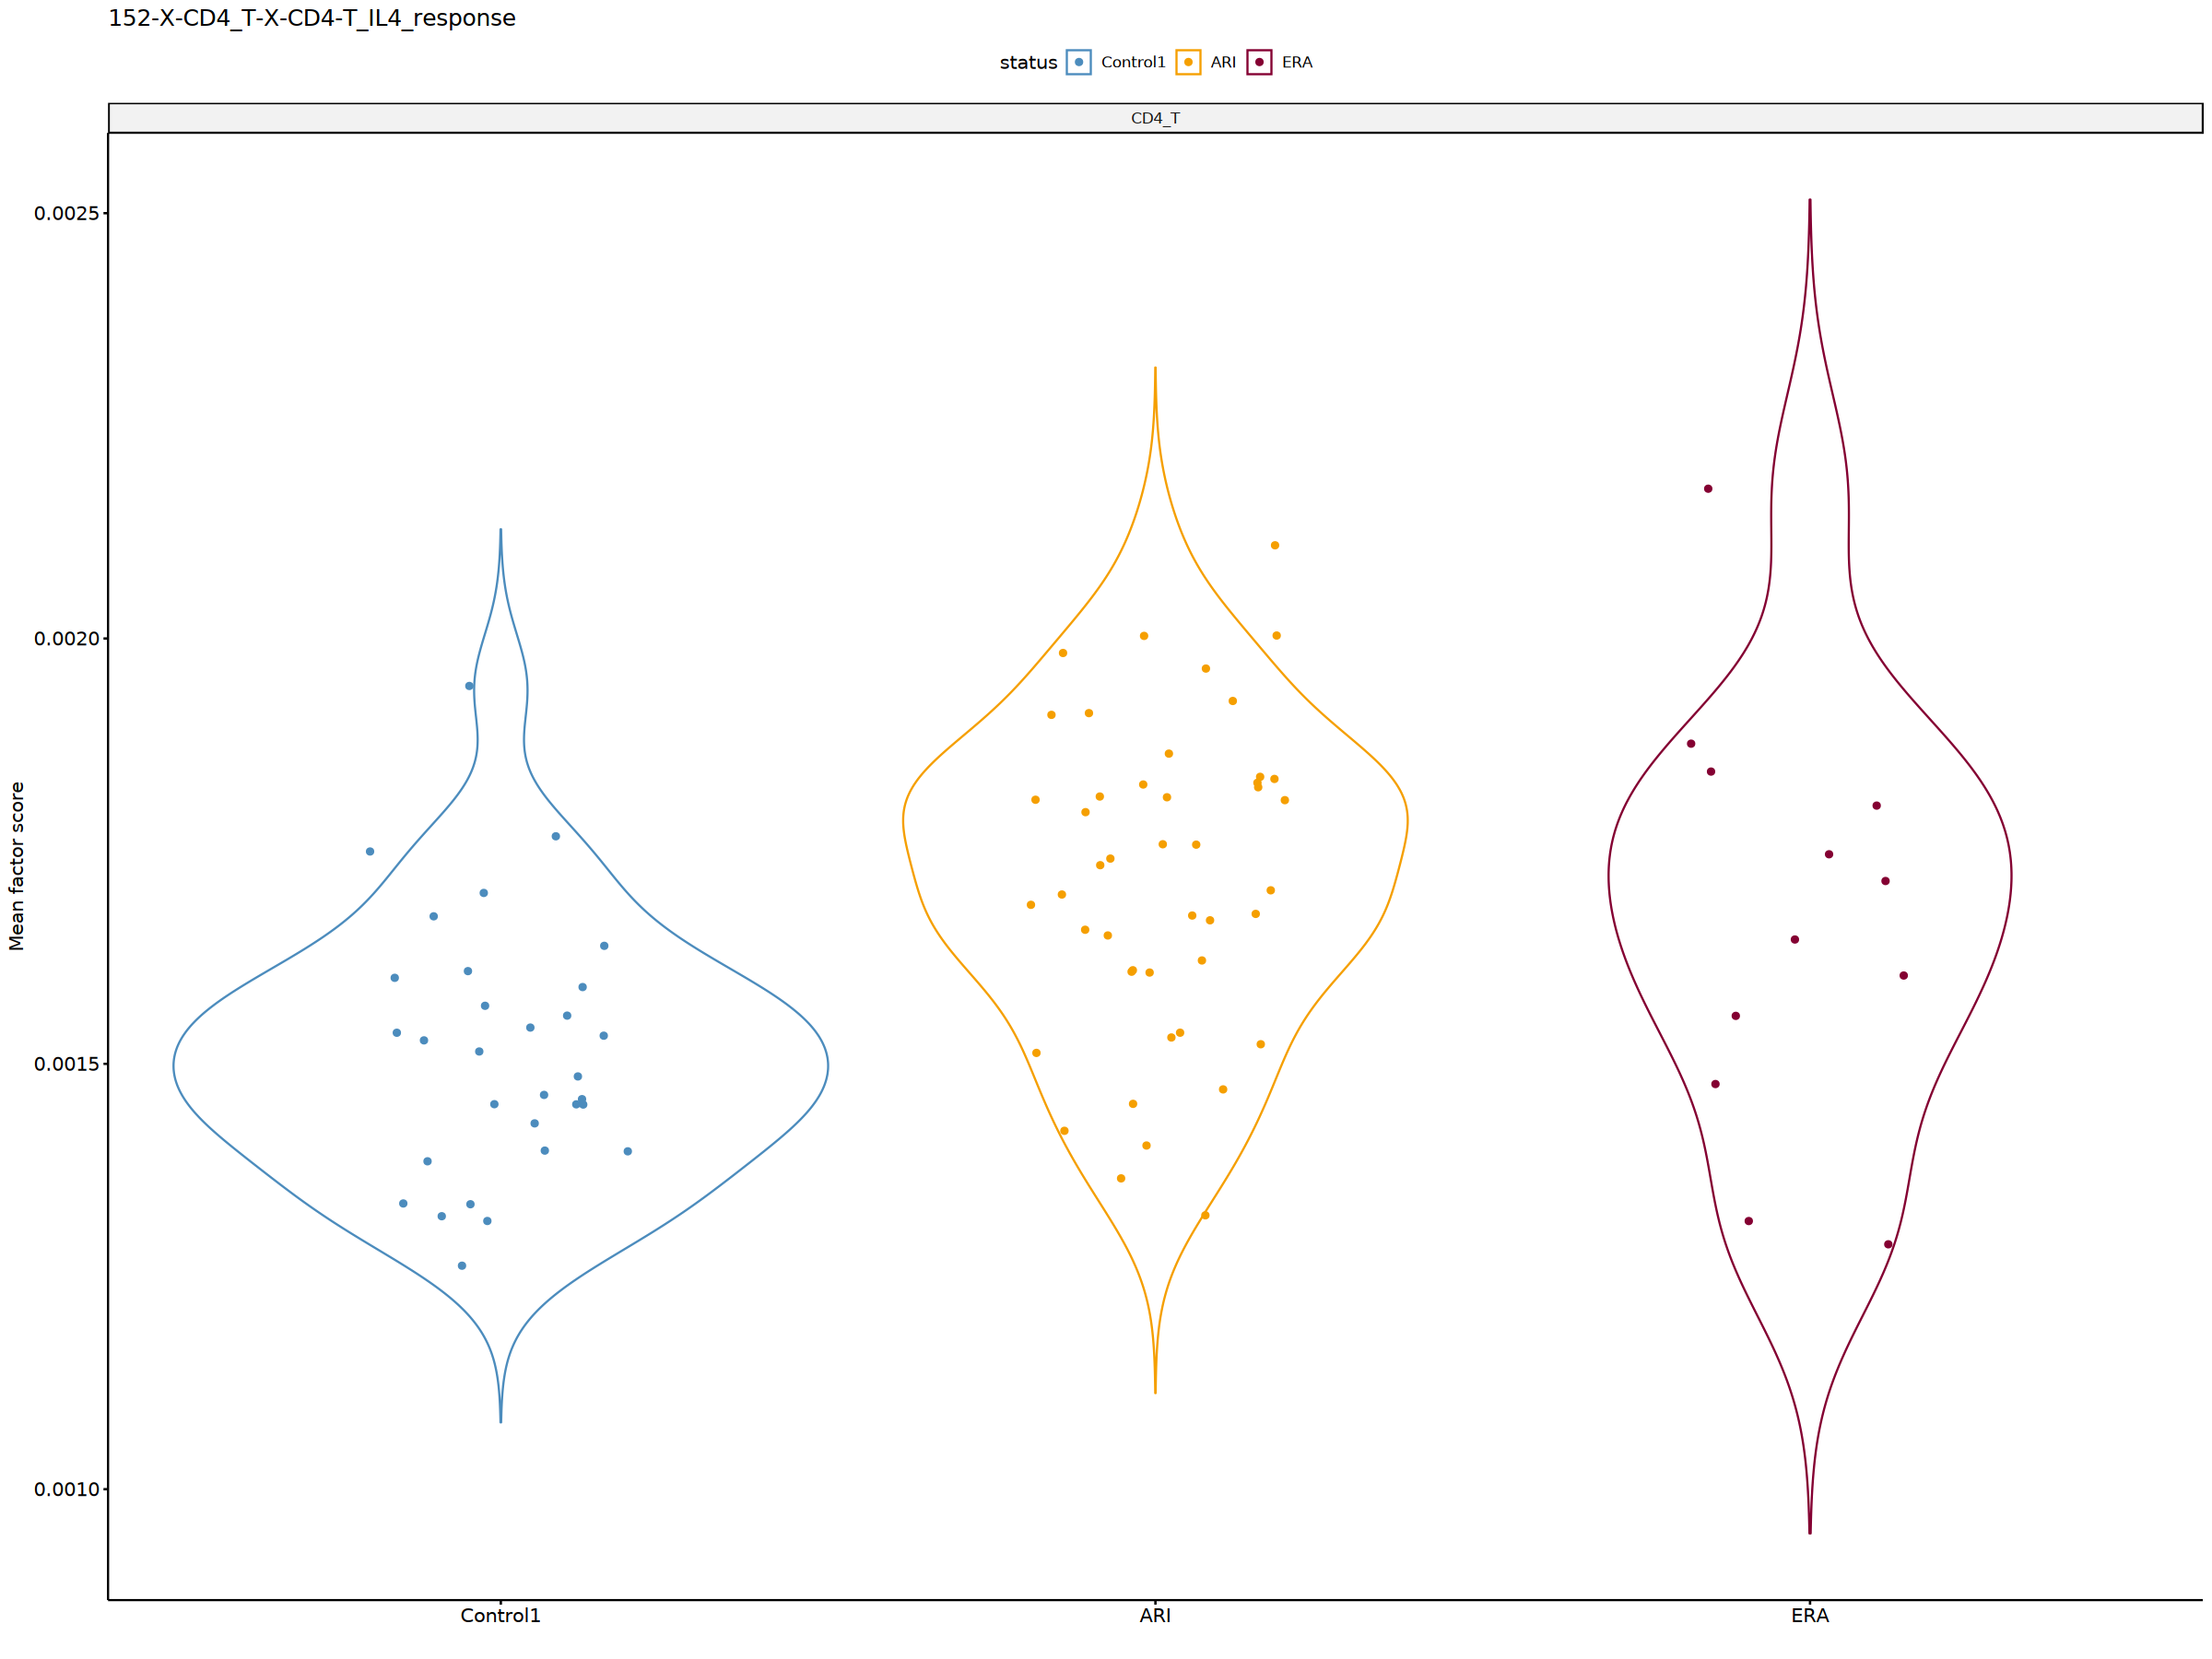

In [40]:
# plot the specific factor
my_comparisons <- list(
    c("ALTRA_healthy", "at_risk"),
    c("ALTRA_healthy", "early_RA"), c("at_risk", "early_RA")
)

factor_name <- "152-X-CD4_T-X-CD4-T_IL4_response"
p1 <- PlotFactor(spec_scores_fl %>% filter(AIFI_L1_5 == "CD4_T"), factor_name, fig_path, proj_name,
    width = 4, height = 4
)
p1


Warning message in wilcox.test.default(c(0.00065664691267838, 0.00019778821545262, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.00065664691267838, 0.00019778821545262, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.00047200723530177, 0.0006251910028519, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.00065664691267838, 0.00019778821545262, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.00065664691267838, 0.00019778821545262, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.00047200723530177, 0.0006251910028519, :
“cannot compute exact p-value with ties”


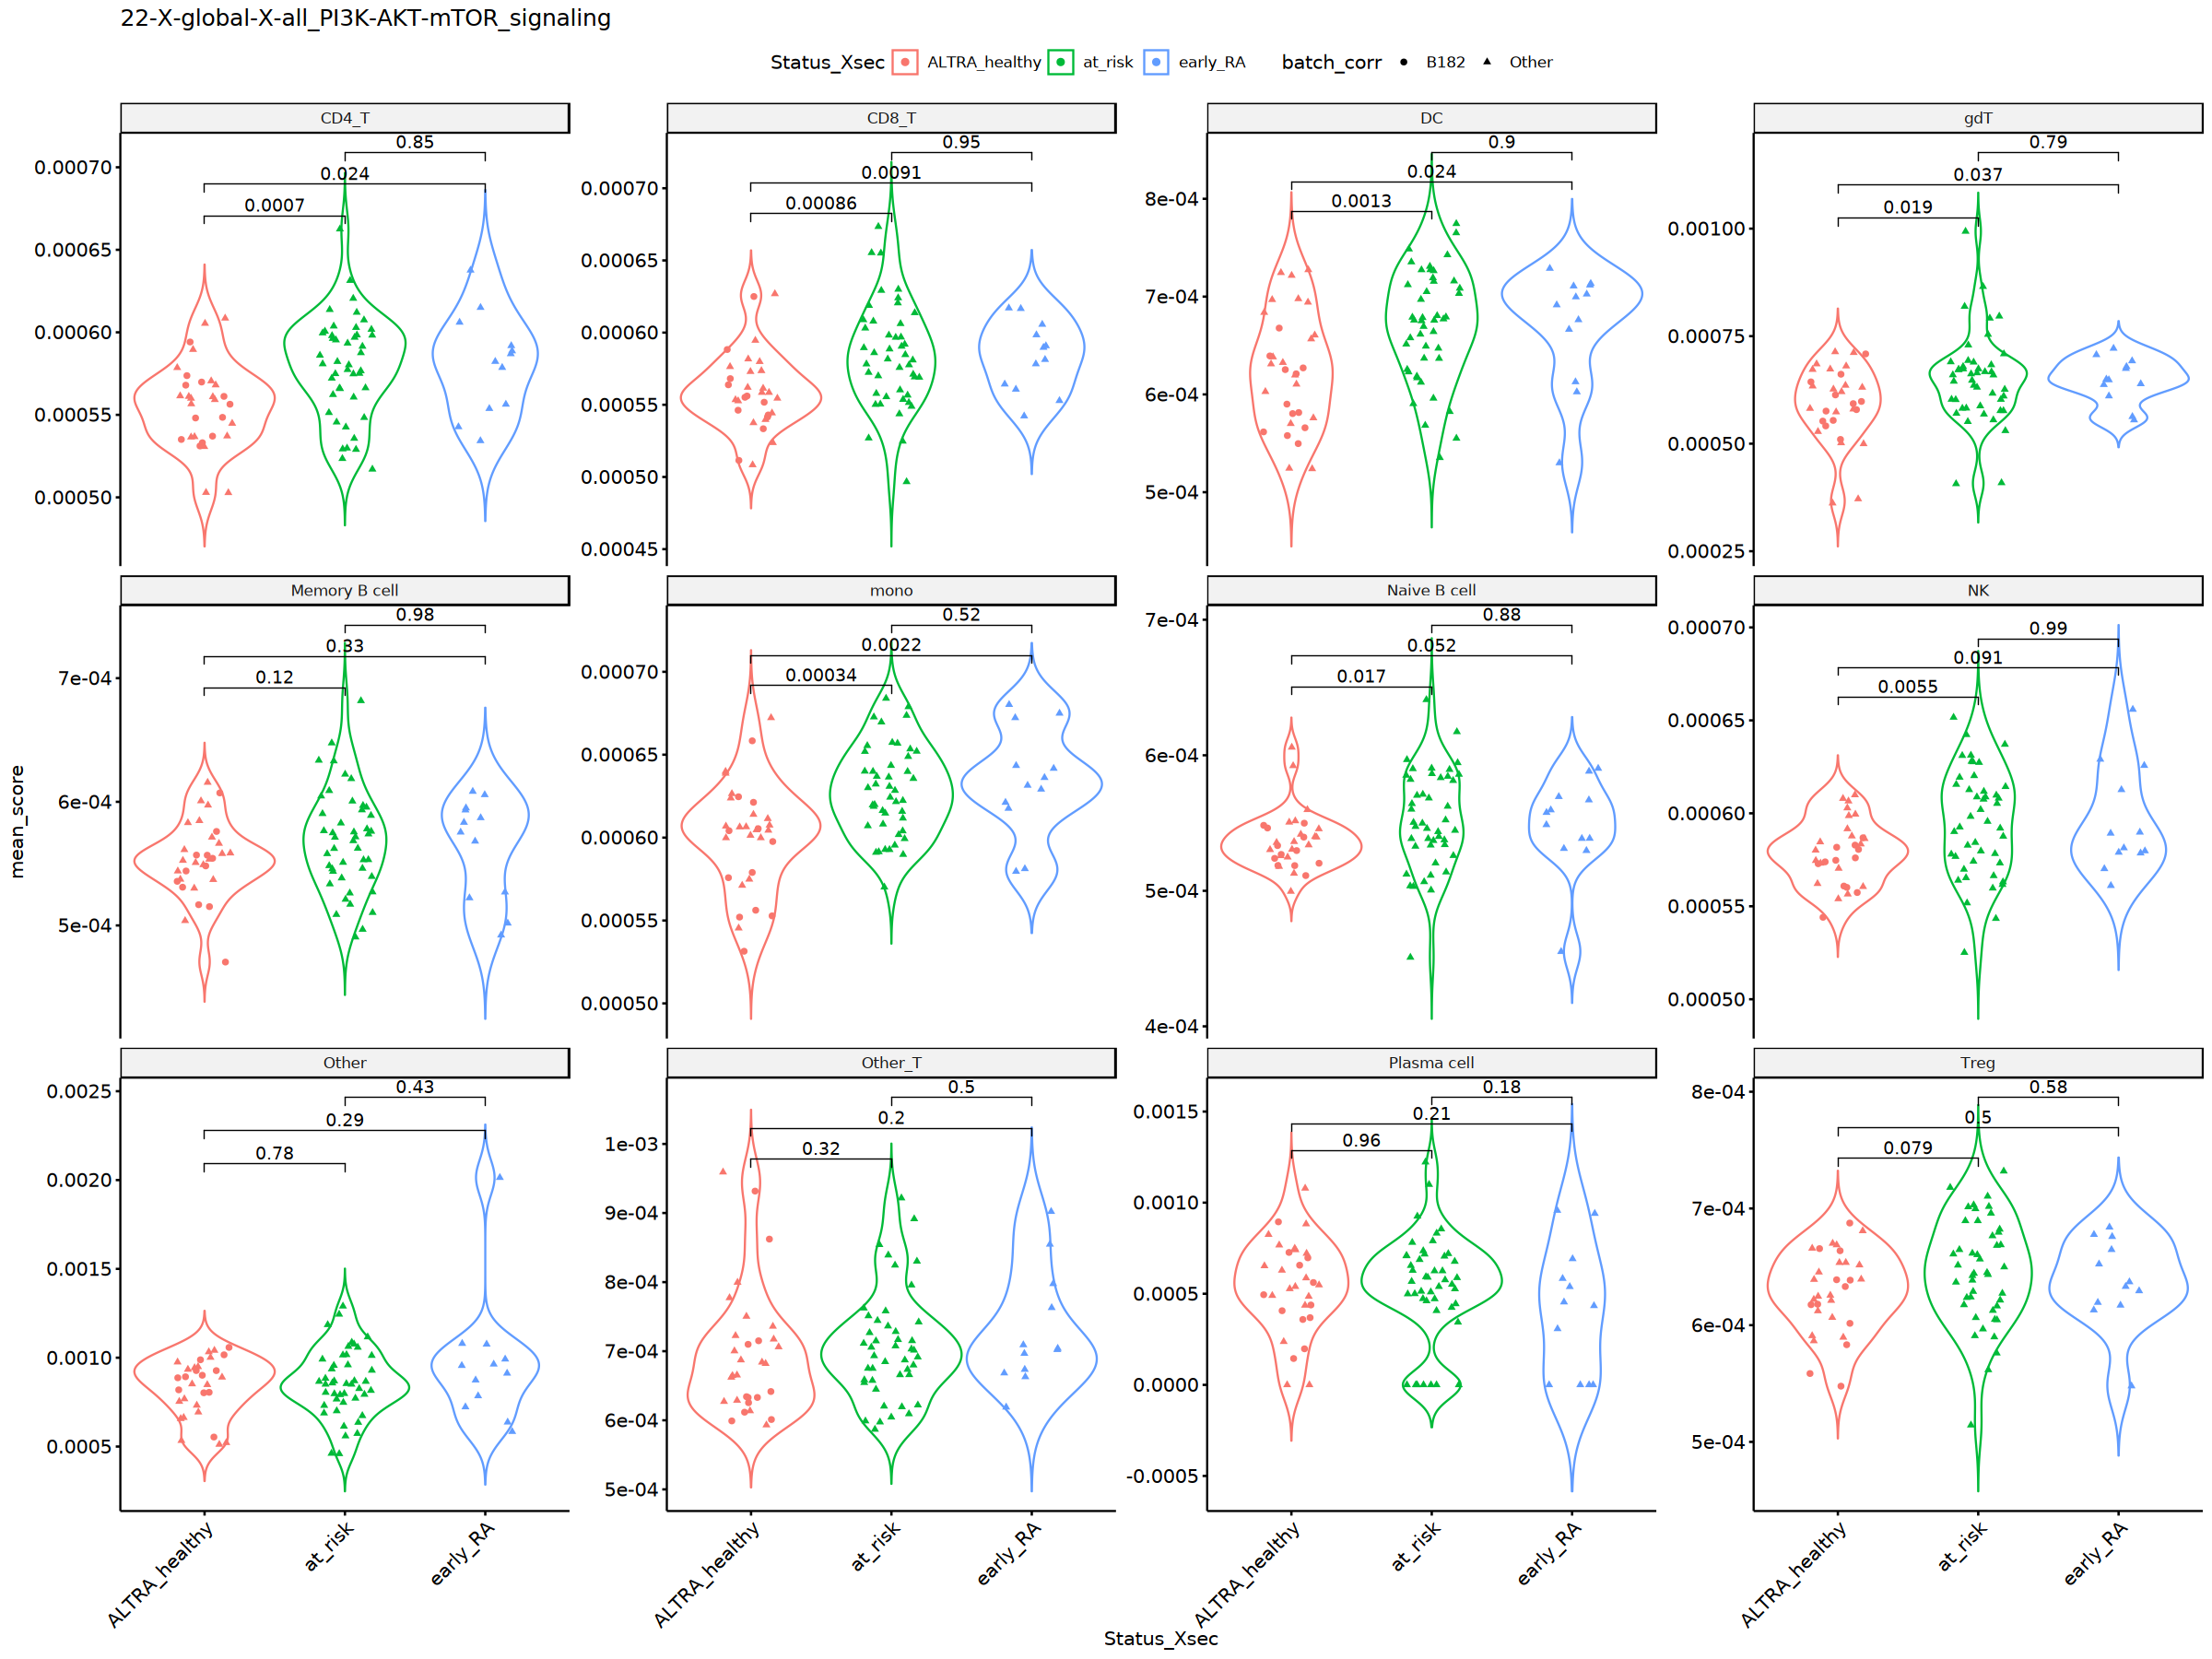

In [218]:
factor_name <- "22-X-global-X-all_PI3K-AKT-mTOR_signaling"
p1 <- PlotFactor(spec_scores_fl, factor_name, my_comparisons, fig_path, proj_name)
p1


Warning message in wilcox.test.default(c(0.00110594759551555, 0.00041236268236114, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.00110594759551555, 0.00041236268236114, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.00037745718263074, 0.00123159196538807, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.00110594759551555, 0.00041236268236114, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.00110594759551555, 0.00041236268236114, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.00037745718263074, 0.00123159196538807, :
“cannot compute exact p-value with ties”


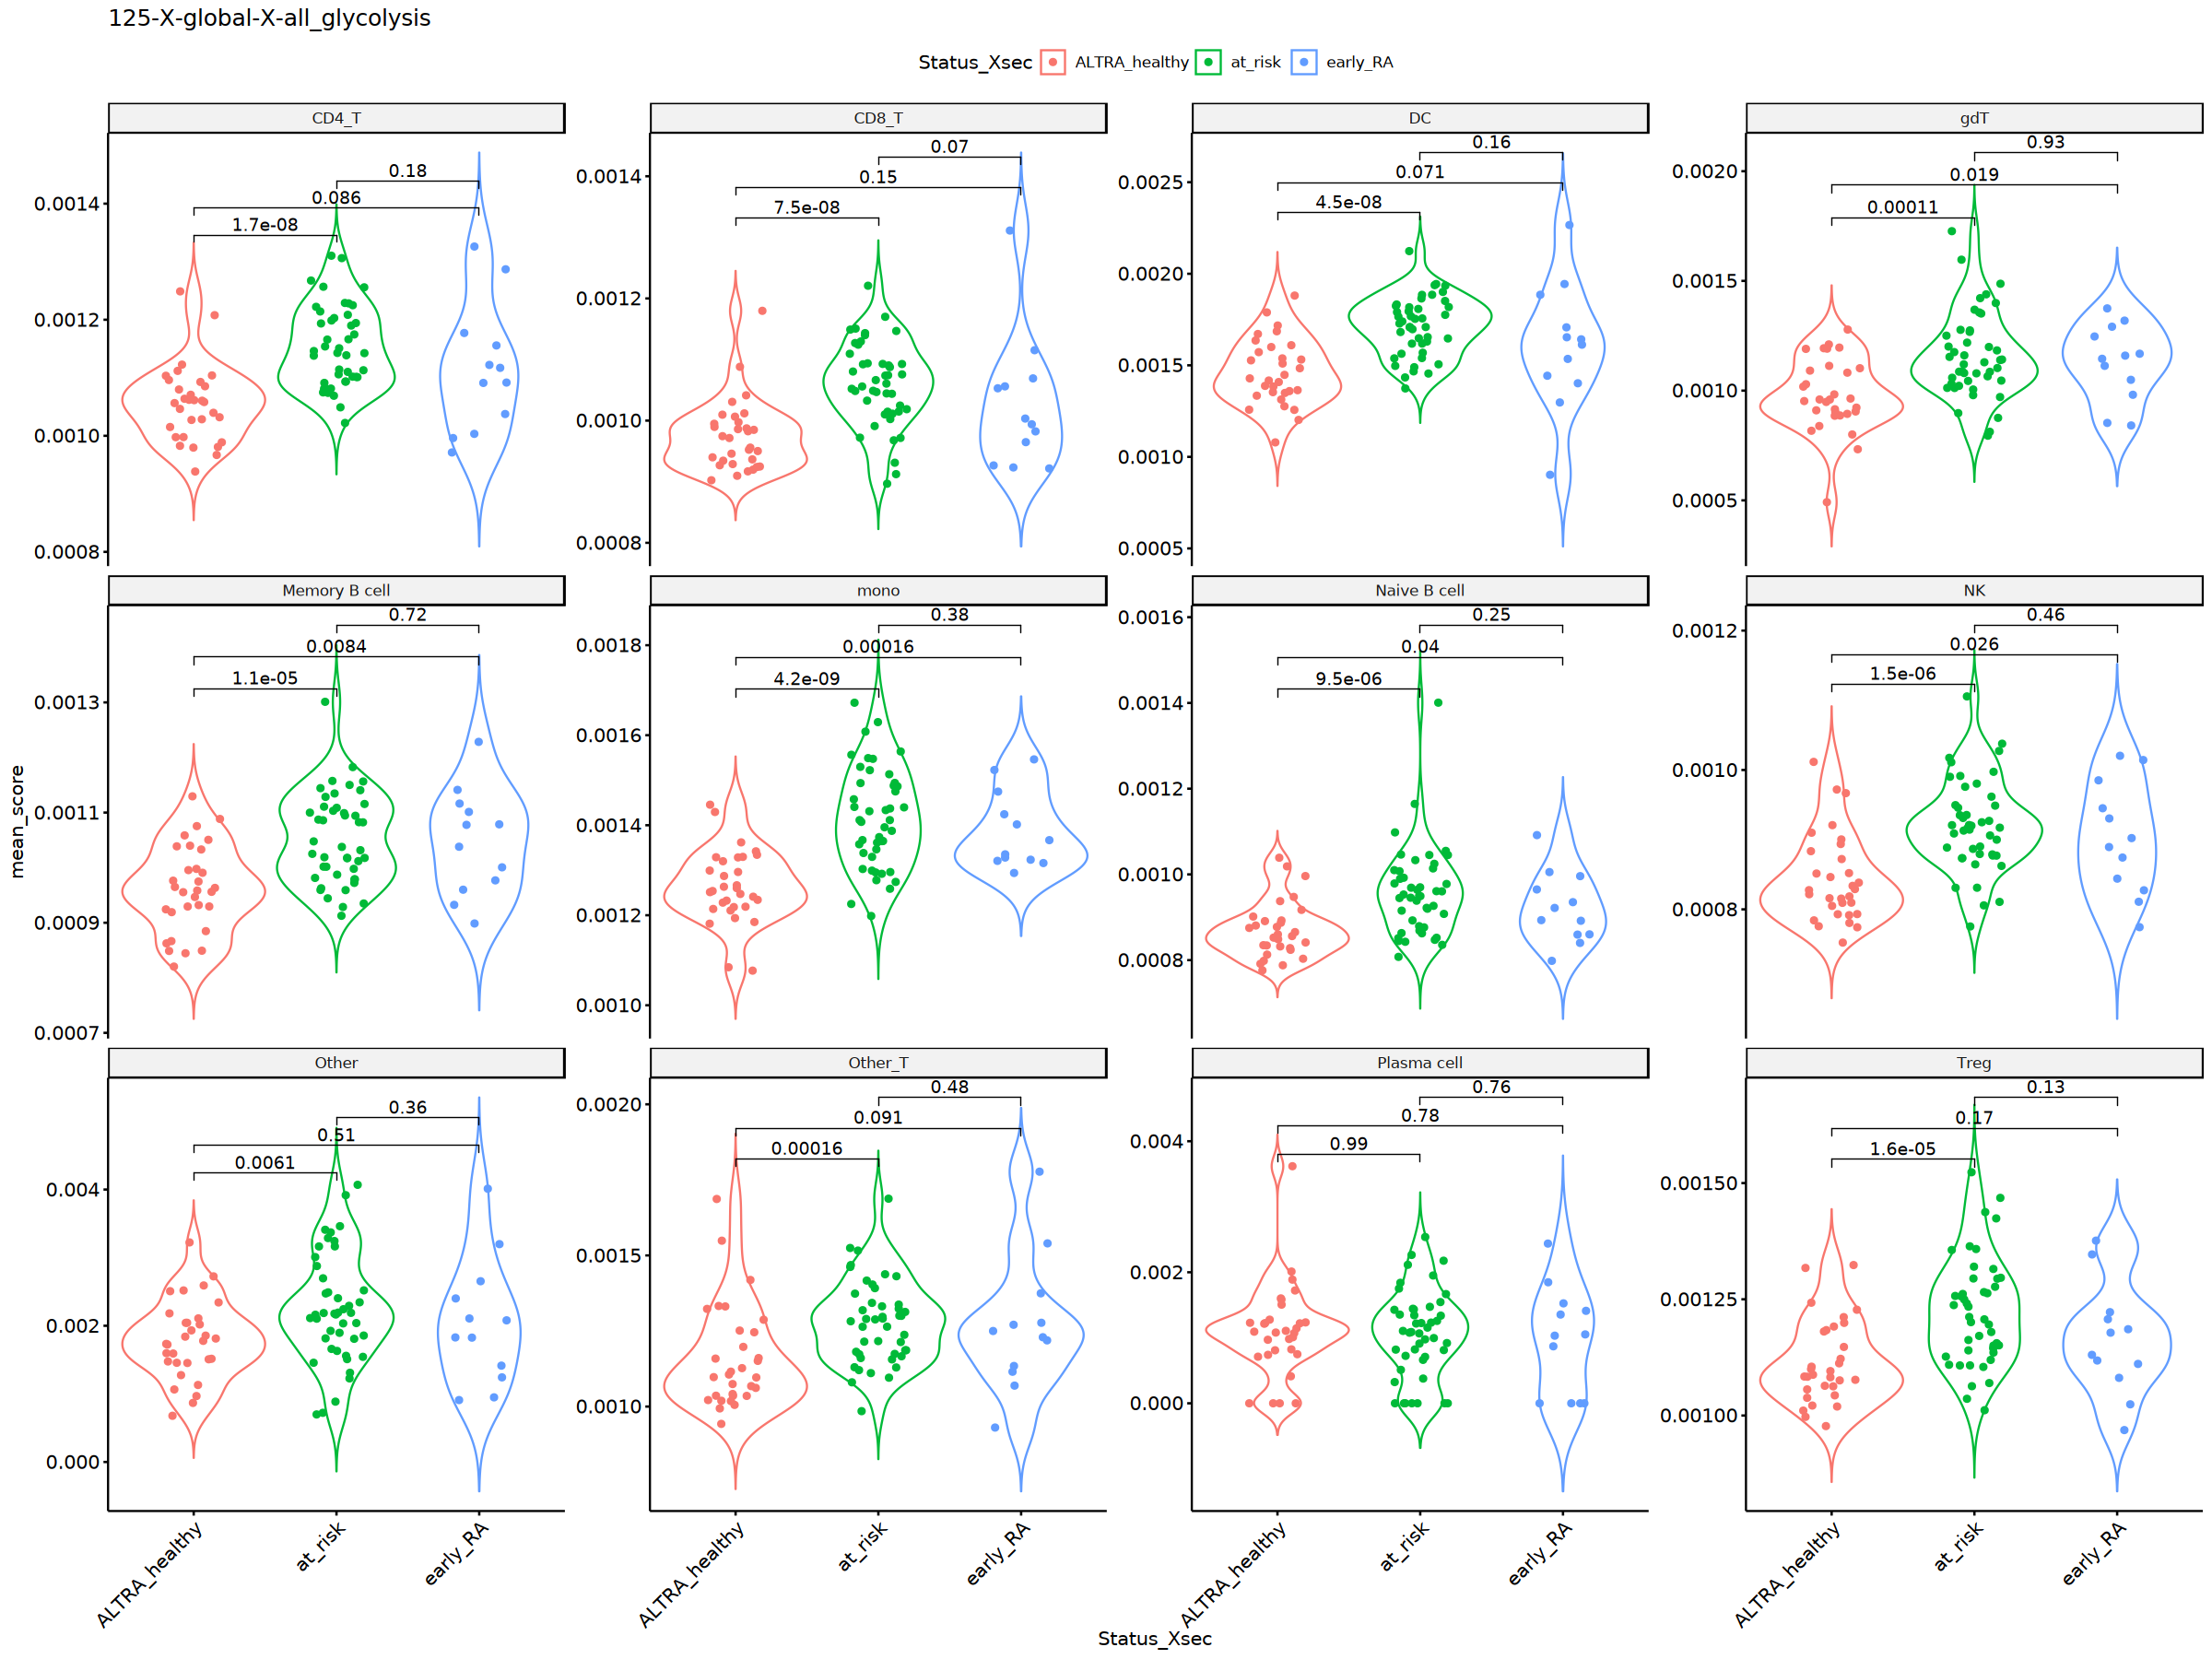

In [51]:
factor_name <- "125-X-global-X-all_glycolysis"
p1 <- PlotFactor(spec_scores_fl, factor_name, my_comparisons, fig_path, proj_name)
p1


In [ ]:
anova_test %>% filter(p.adj < 0.05 & AIFI_L1_5 == "CD4_T")


In [ ]:
factor_name <- "156-X-CD4_T-X-156"
p1 <- PlotFactor(spec_scores_fl %>% filter(AIFI_L1_5 == "CD4_T"), factor_name, my_comparisons, fig_path, proj_name)
p1


## plot dotplot

In [47]:
PlotFactorDot <- function(spec_scores_fl, stats_table, factor_name) {
    # Ensure necessary libraries are loaded
    require(ggplot2)
    require(ggpubr)
    require(dplyr)
    require(tidyr)
    require(stringr)
    require(wesanderson)

    # Calculate mean scores and nonzero percentages
    mean_scores <- spec_scores_fl %>%
        filter(Spectra_factor == factor_name) %>%
        group_by(status, AIFI_L1_5) %>%
        summarise(
            mean_score = mean(mean_score, na.rm = TRUE),
            nonzero_percentage = mean(replace_na(nonzero_percentage, 0), na.rm = TRUE)
        ) %>%
        ungroup() %>%
        group_by(AIFI_L1_5) %>%
        mutate(scale_score = scale(mean_score))

    # Prepare p-value table
    pvalue_table <- stats_table %>%
        filter(Spectra_factor == factor_name) %>%
        mutate(
            p.adj = format(p.adj, digits = 2, scientific = TRUE),
            status = str_remove(term, "status")
        )

    # Merge mean scores with p-value table
    mean_scores_p <- mean_scores %>%
        left_join(pvalue_table, by = c("AIFI_L1_5", "status")) %>%
        mutate(
            significance = replace_na(p.adj.signif, "ns"),
            status = factor(status, levels = c("Control1", "ARI", "ERA"))
        )
    # Create the dot plot
    p1 <- ggplot(mean_scores_p, aes(x = status, y = AIFI_L1_5)) +
        geom_point(aes(color = scale_score, size = nonzero_percentage, shape = significance)) +
        ggtitle(factor_name) +
        labs(
            color = "Factor Score", size = "Percentage",
            shape = "Significance", x = "", y = ""
        ) +
        scale_color_gradientn(colors = wesanderson::wes_palette("Zissou1", 100, type = "continuous")) +
        scale_shape_manual(values = c(17, 18, 0, 16)) +
        theme_pubr() +
        theme(legend.position = "right")

    return(p1)
}

# Example usage:
# PlotFactorDot(spec_scores_fl, "some_factor", "path/to/figures/", "project_name", stats_table)


`summarise()` has grouped output by 'status'. You can override using the
`.groups` argument.


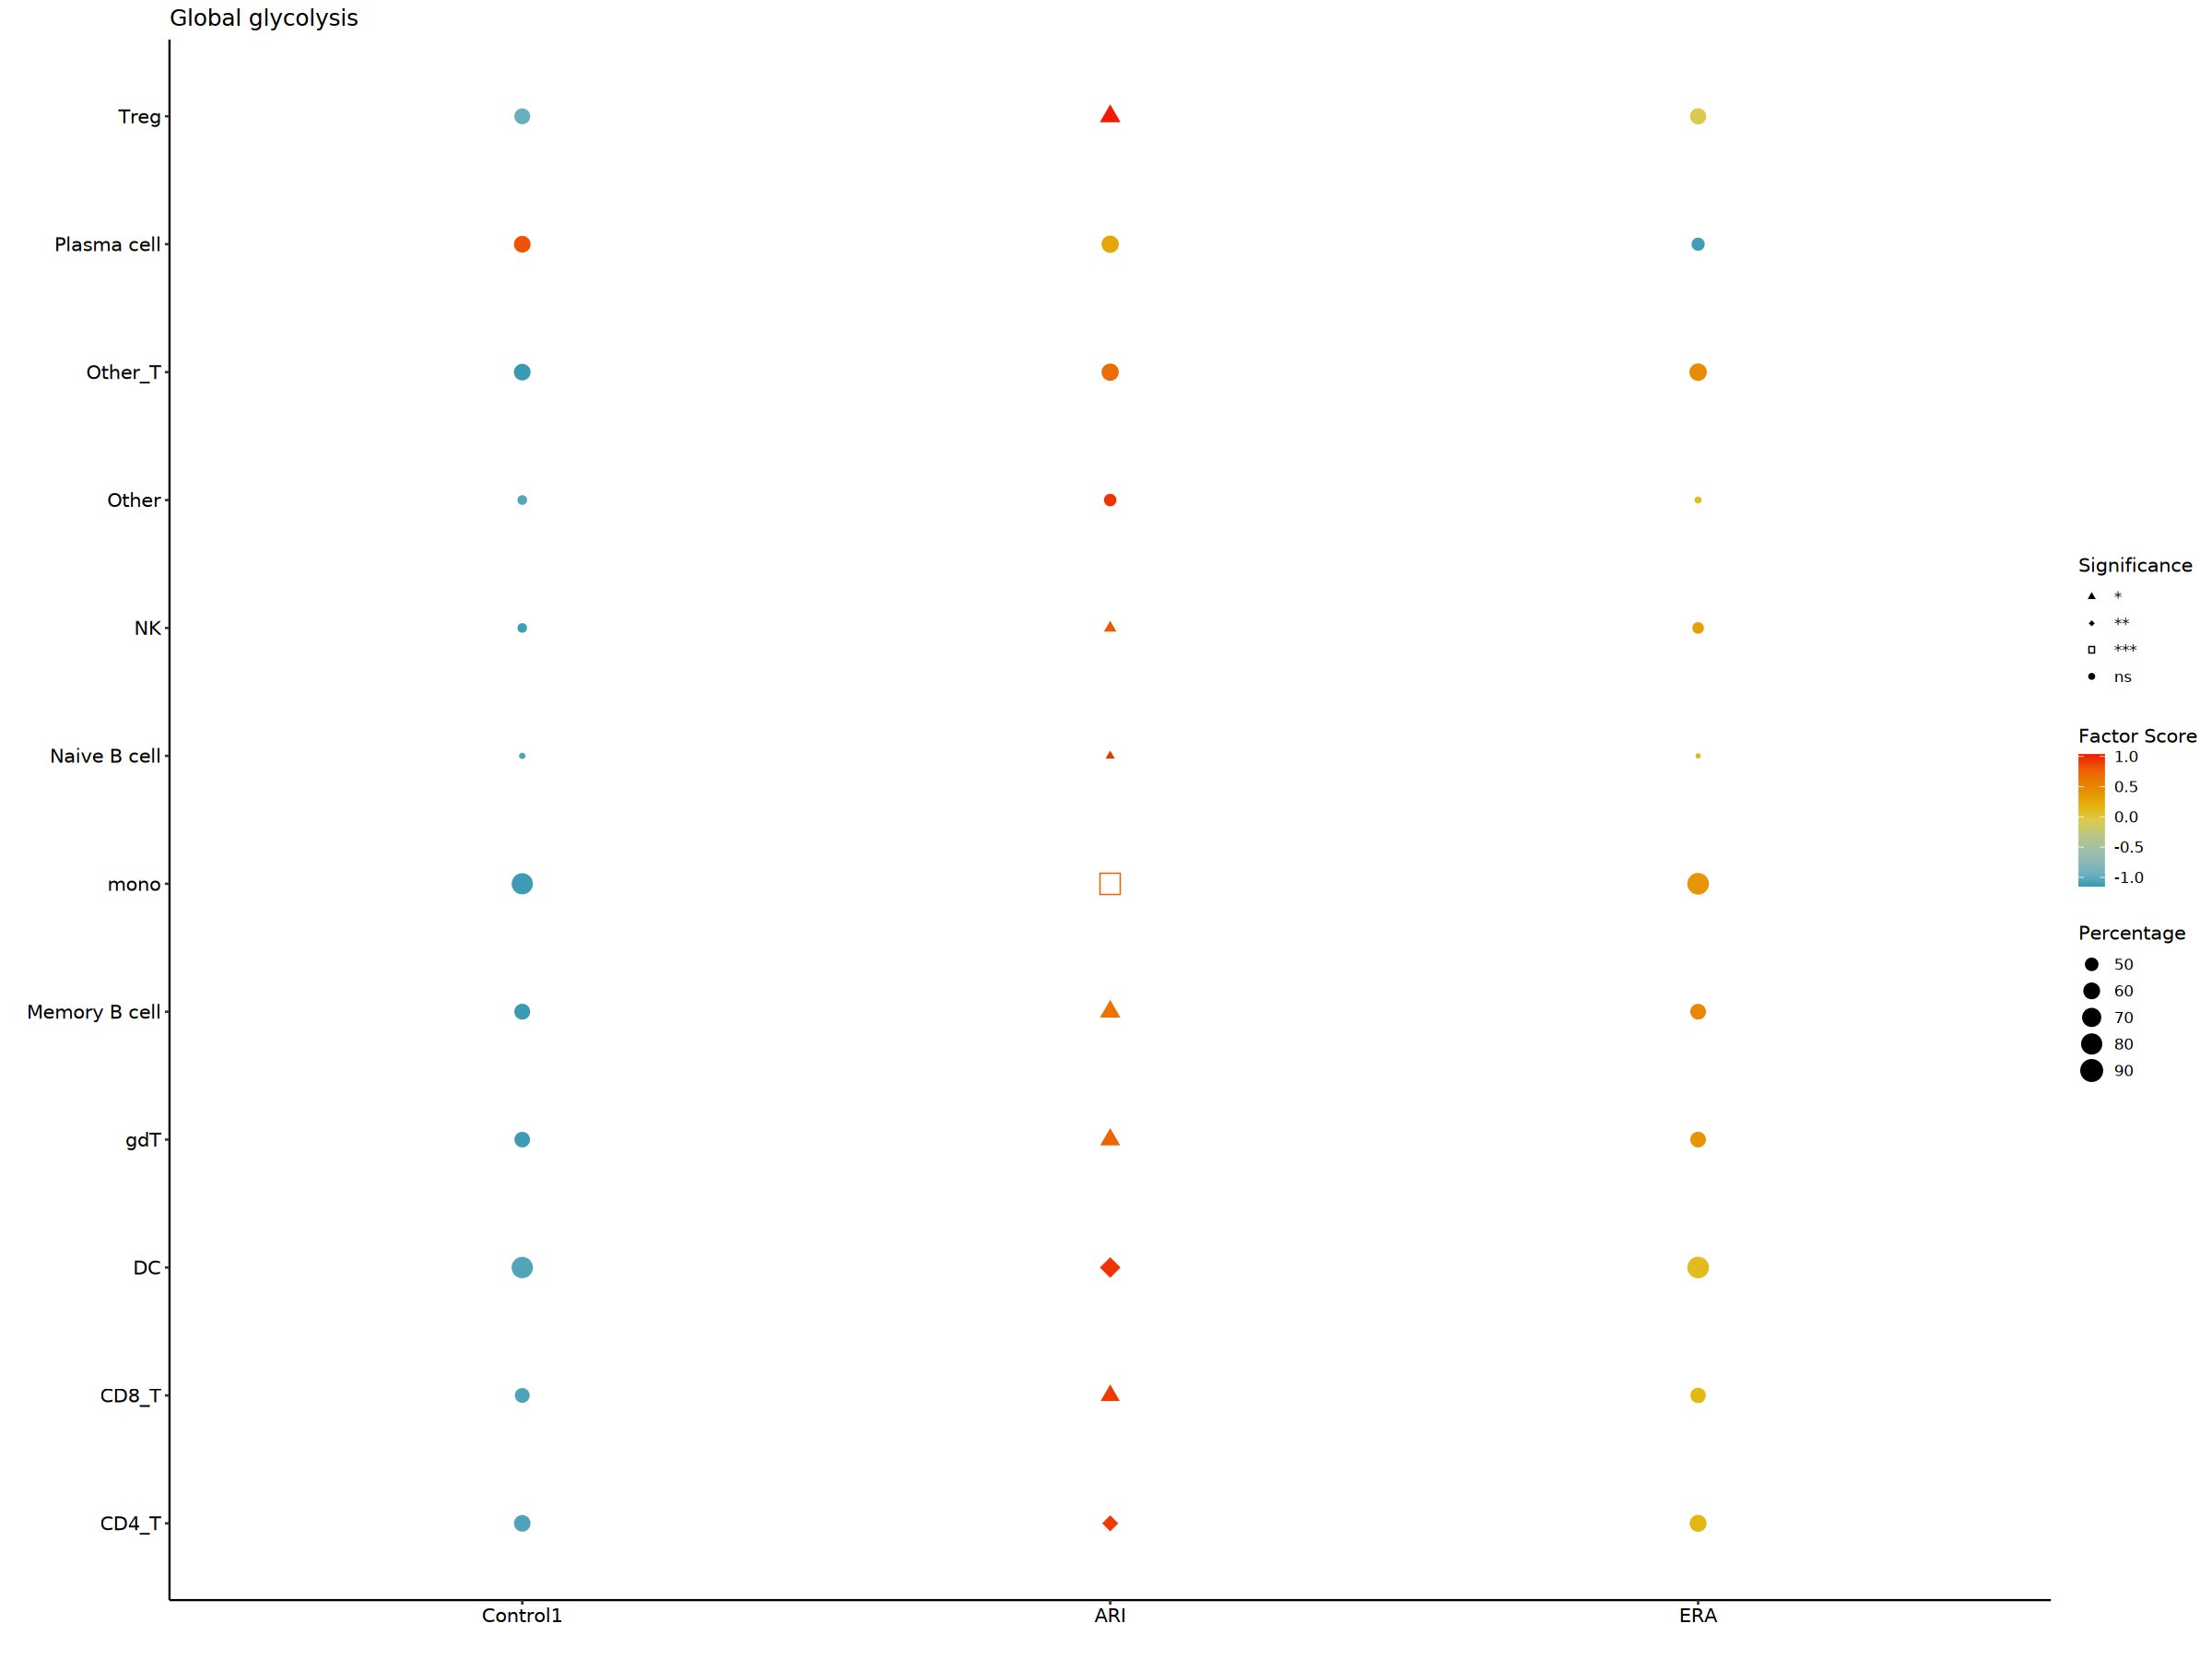

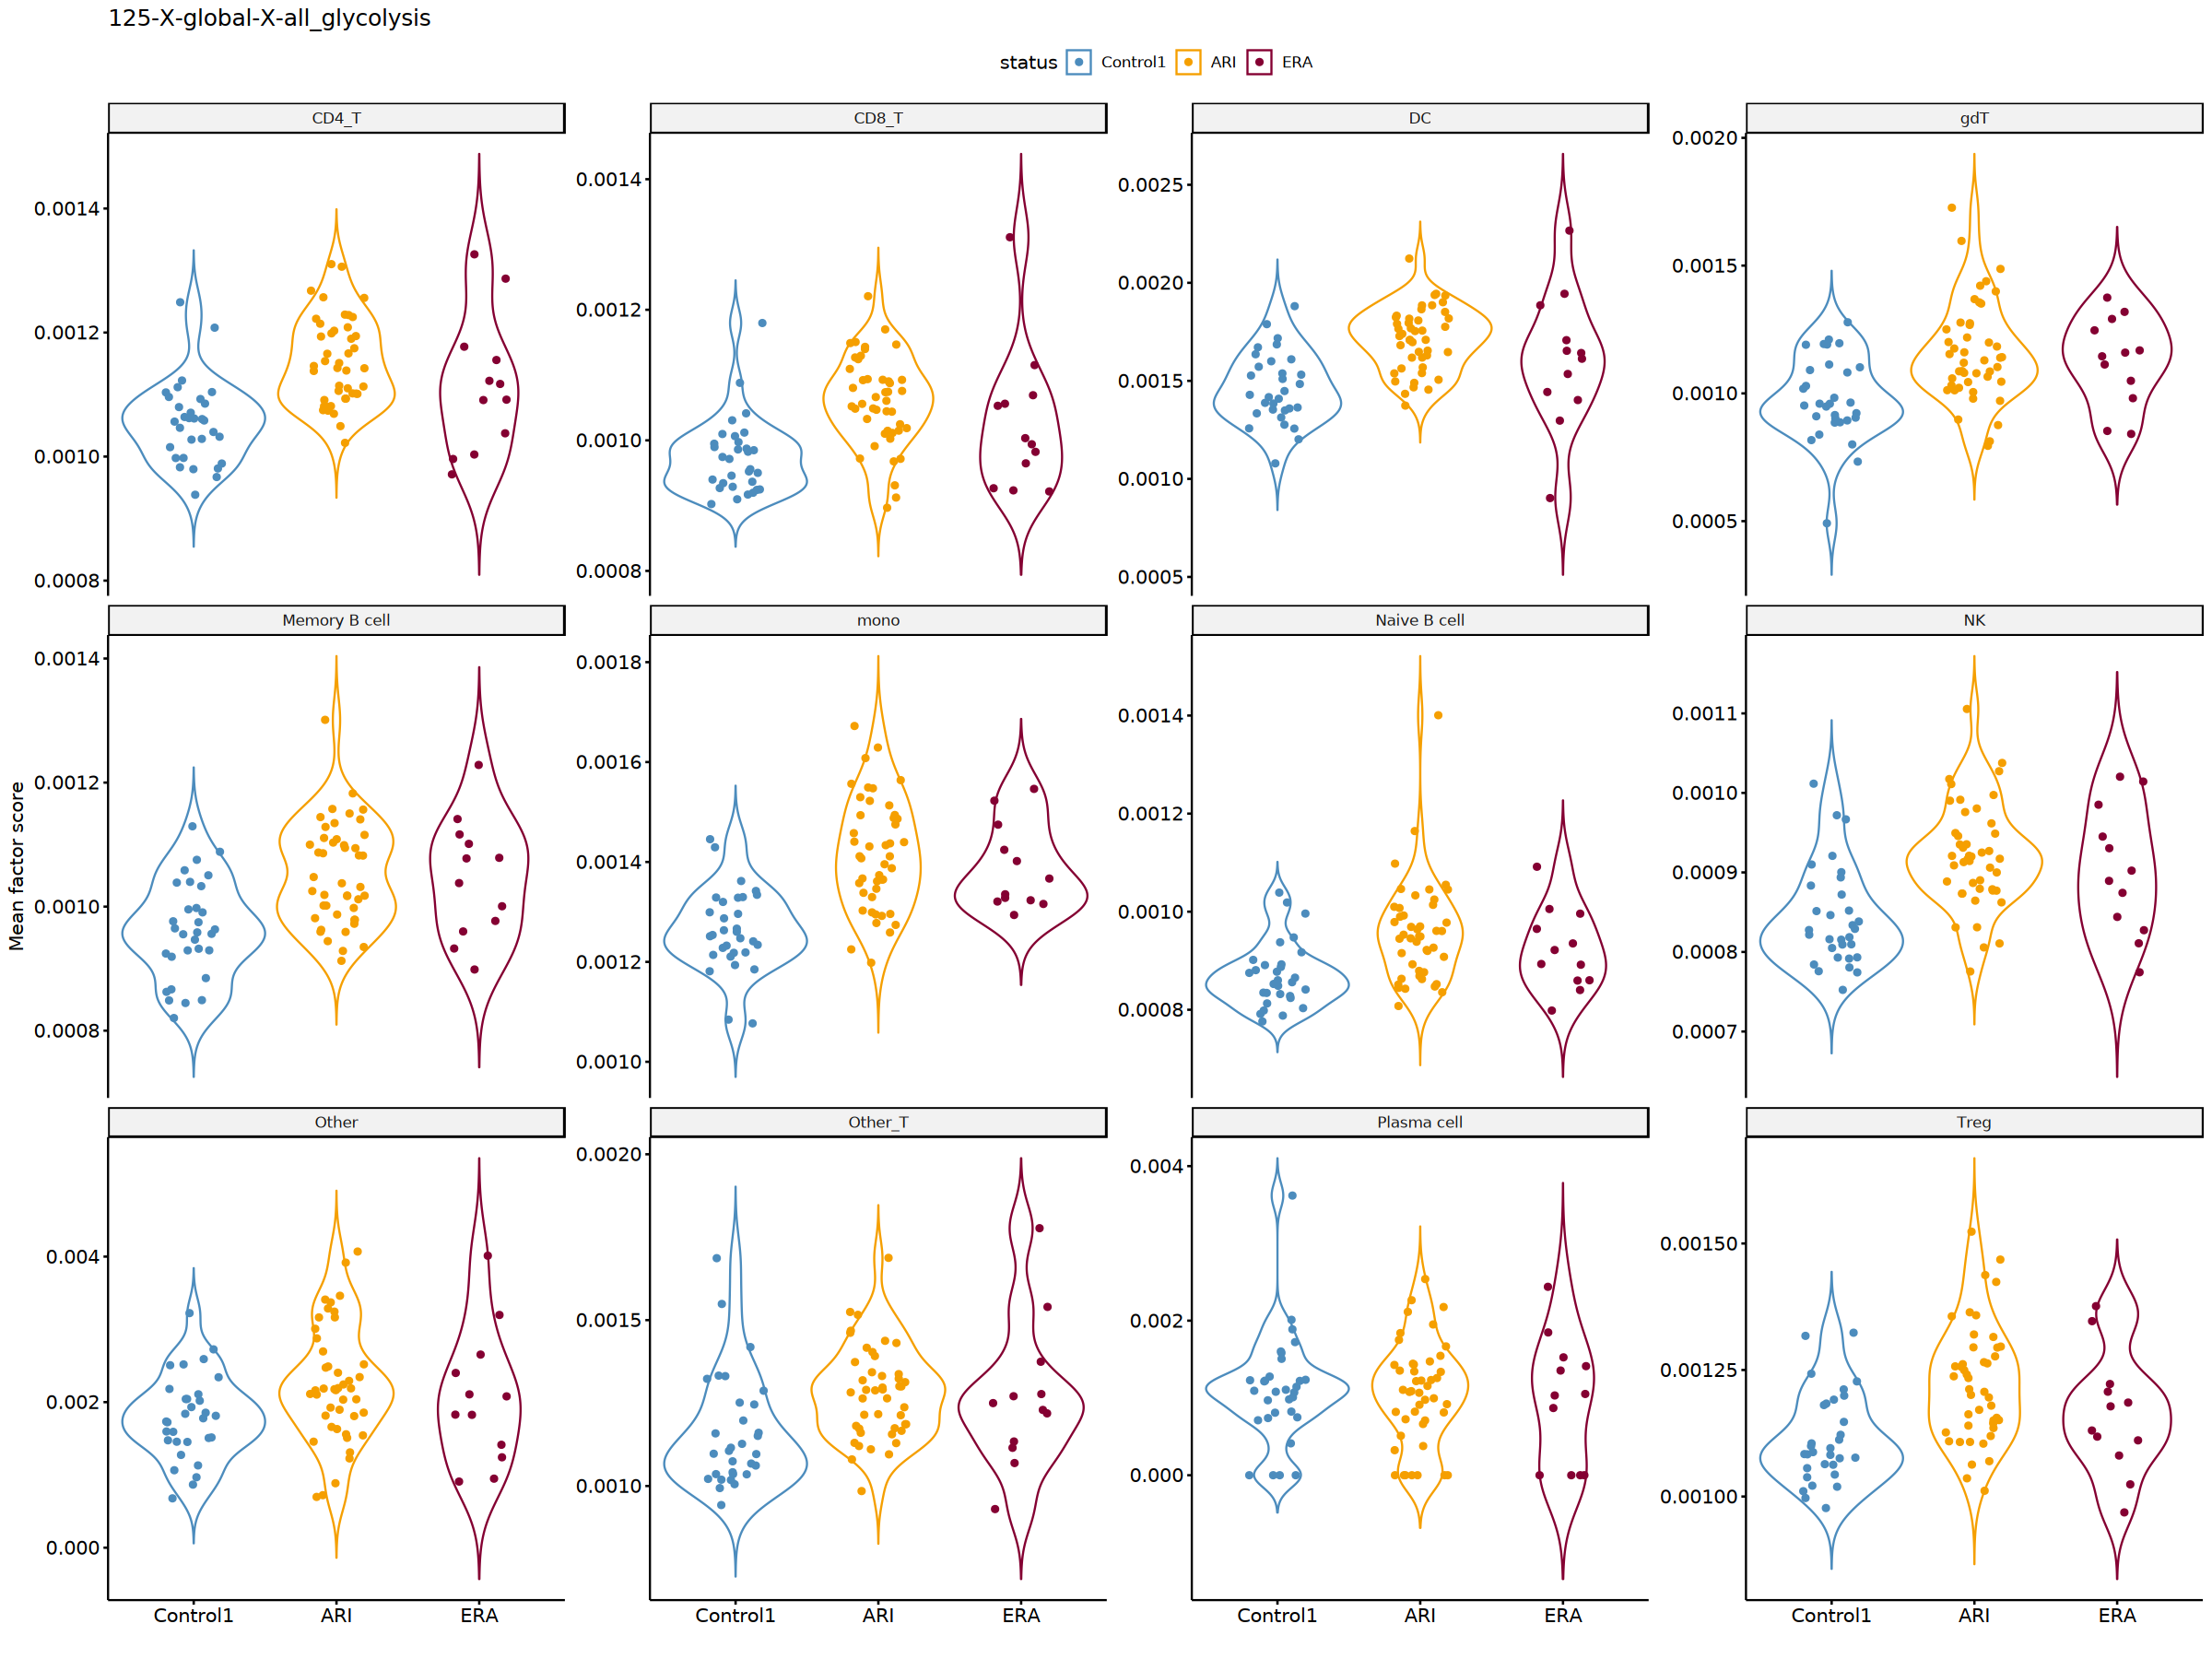

In [212]:
factor_name <- "125-X-global-X-all_glycolysis"
p1 <- PlotFactorDot(spec_scores_fl,
    stats_table = glm_results_status,
    factor_name = factor_name
) + ggtitle("Global glycolysis")
p1
ggsave(file.path(fig_path, paste0(proj_name, factor_name, "_pathway_enrichment_dotplot.pdf")),
    plot = p1, width = 5, height = 5
)
# Save the plot
p2 <- PlotFactor(spec_scores_fl,
    factor_name = factor_name, fig_path, proj_name
)
p2


`summarise()` has grouped output by 'status'. You can override using the
`.groups` argument.


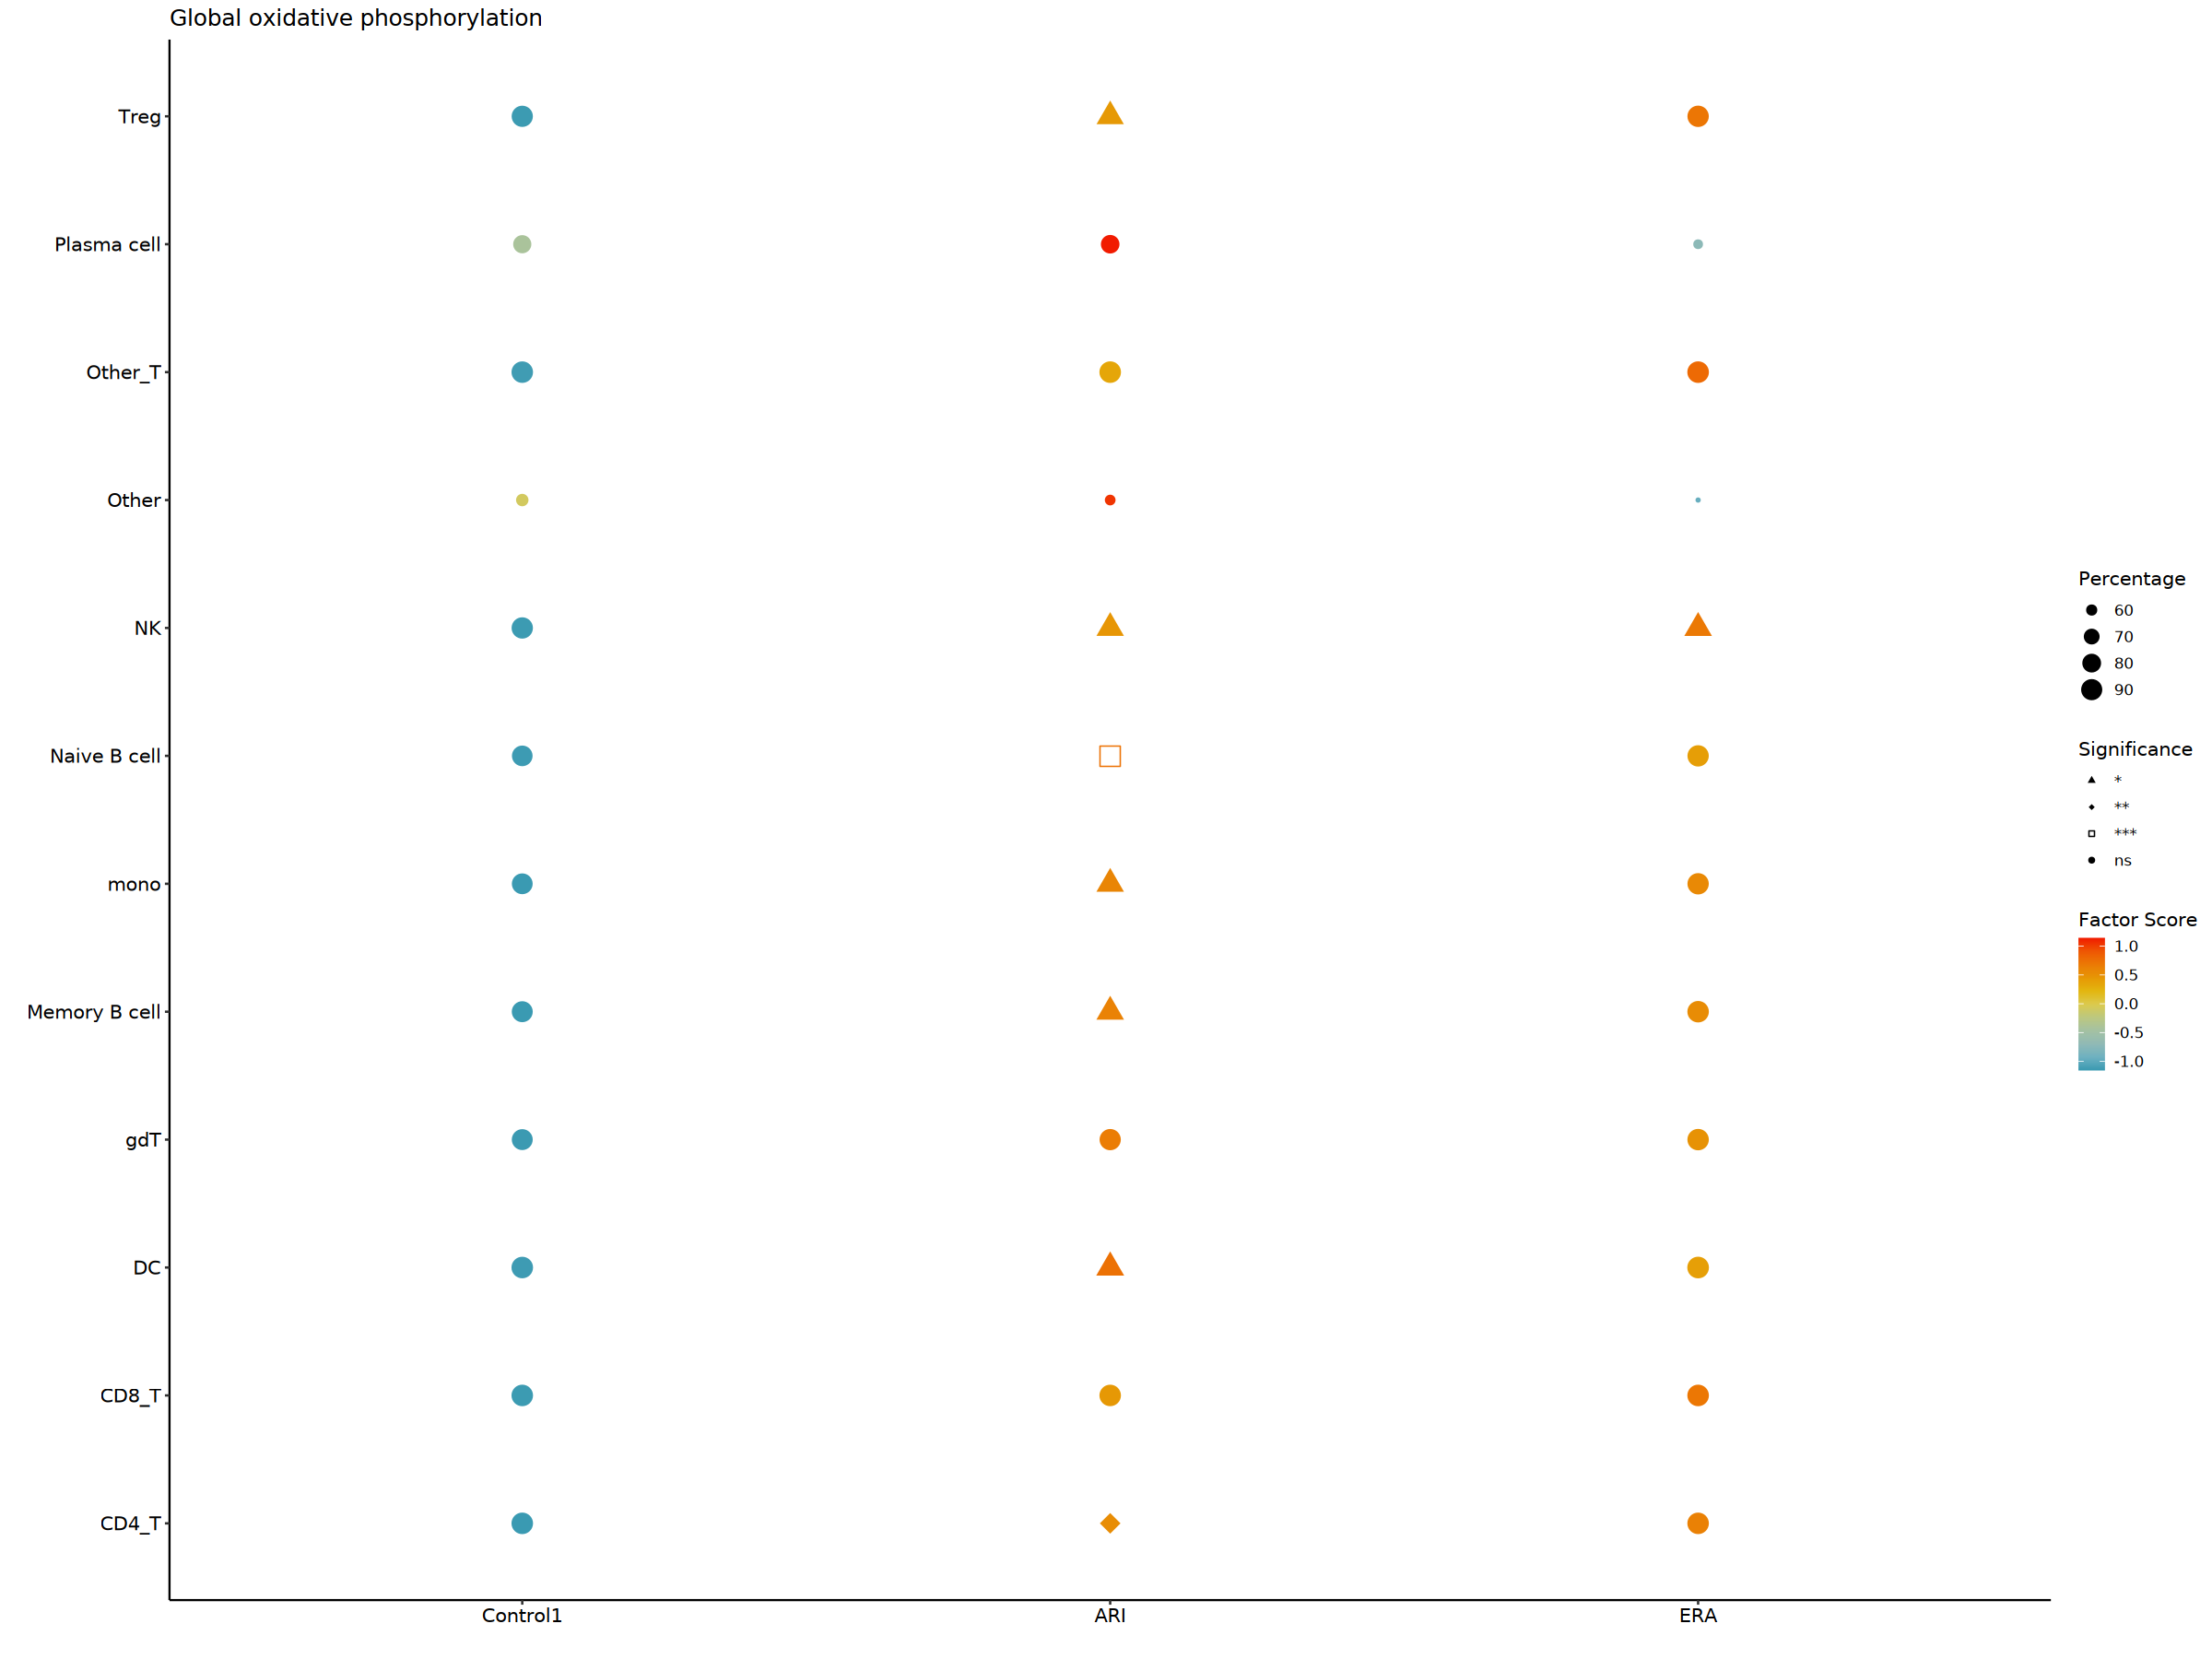

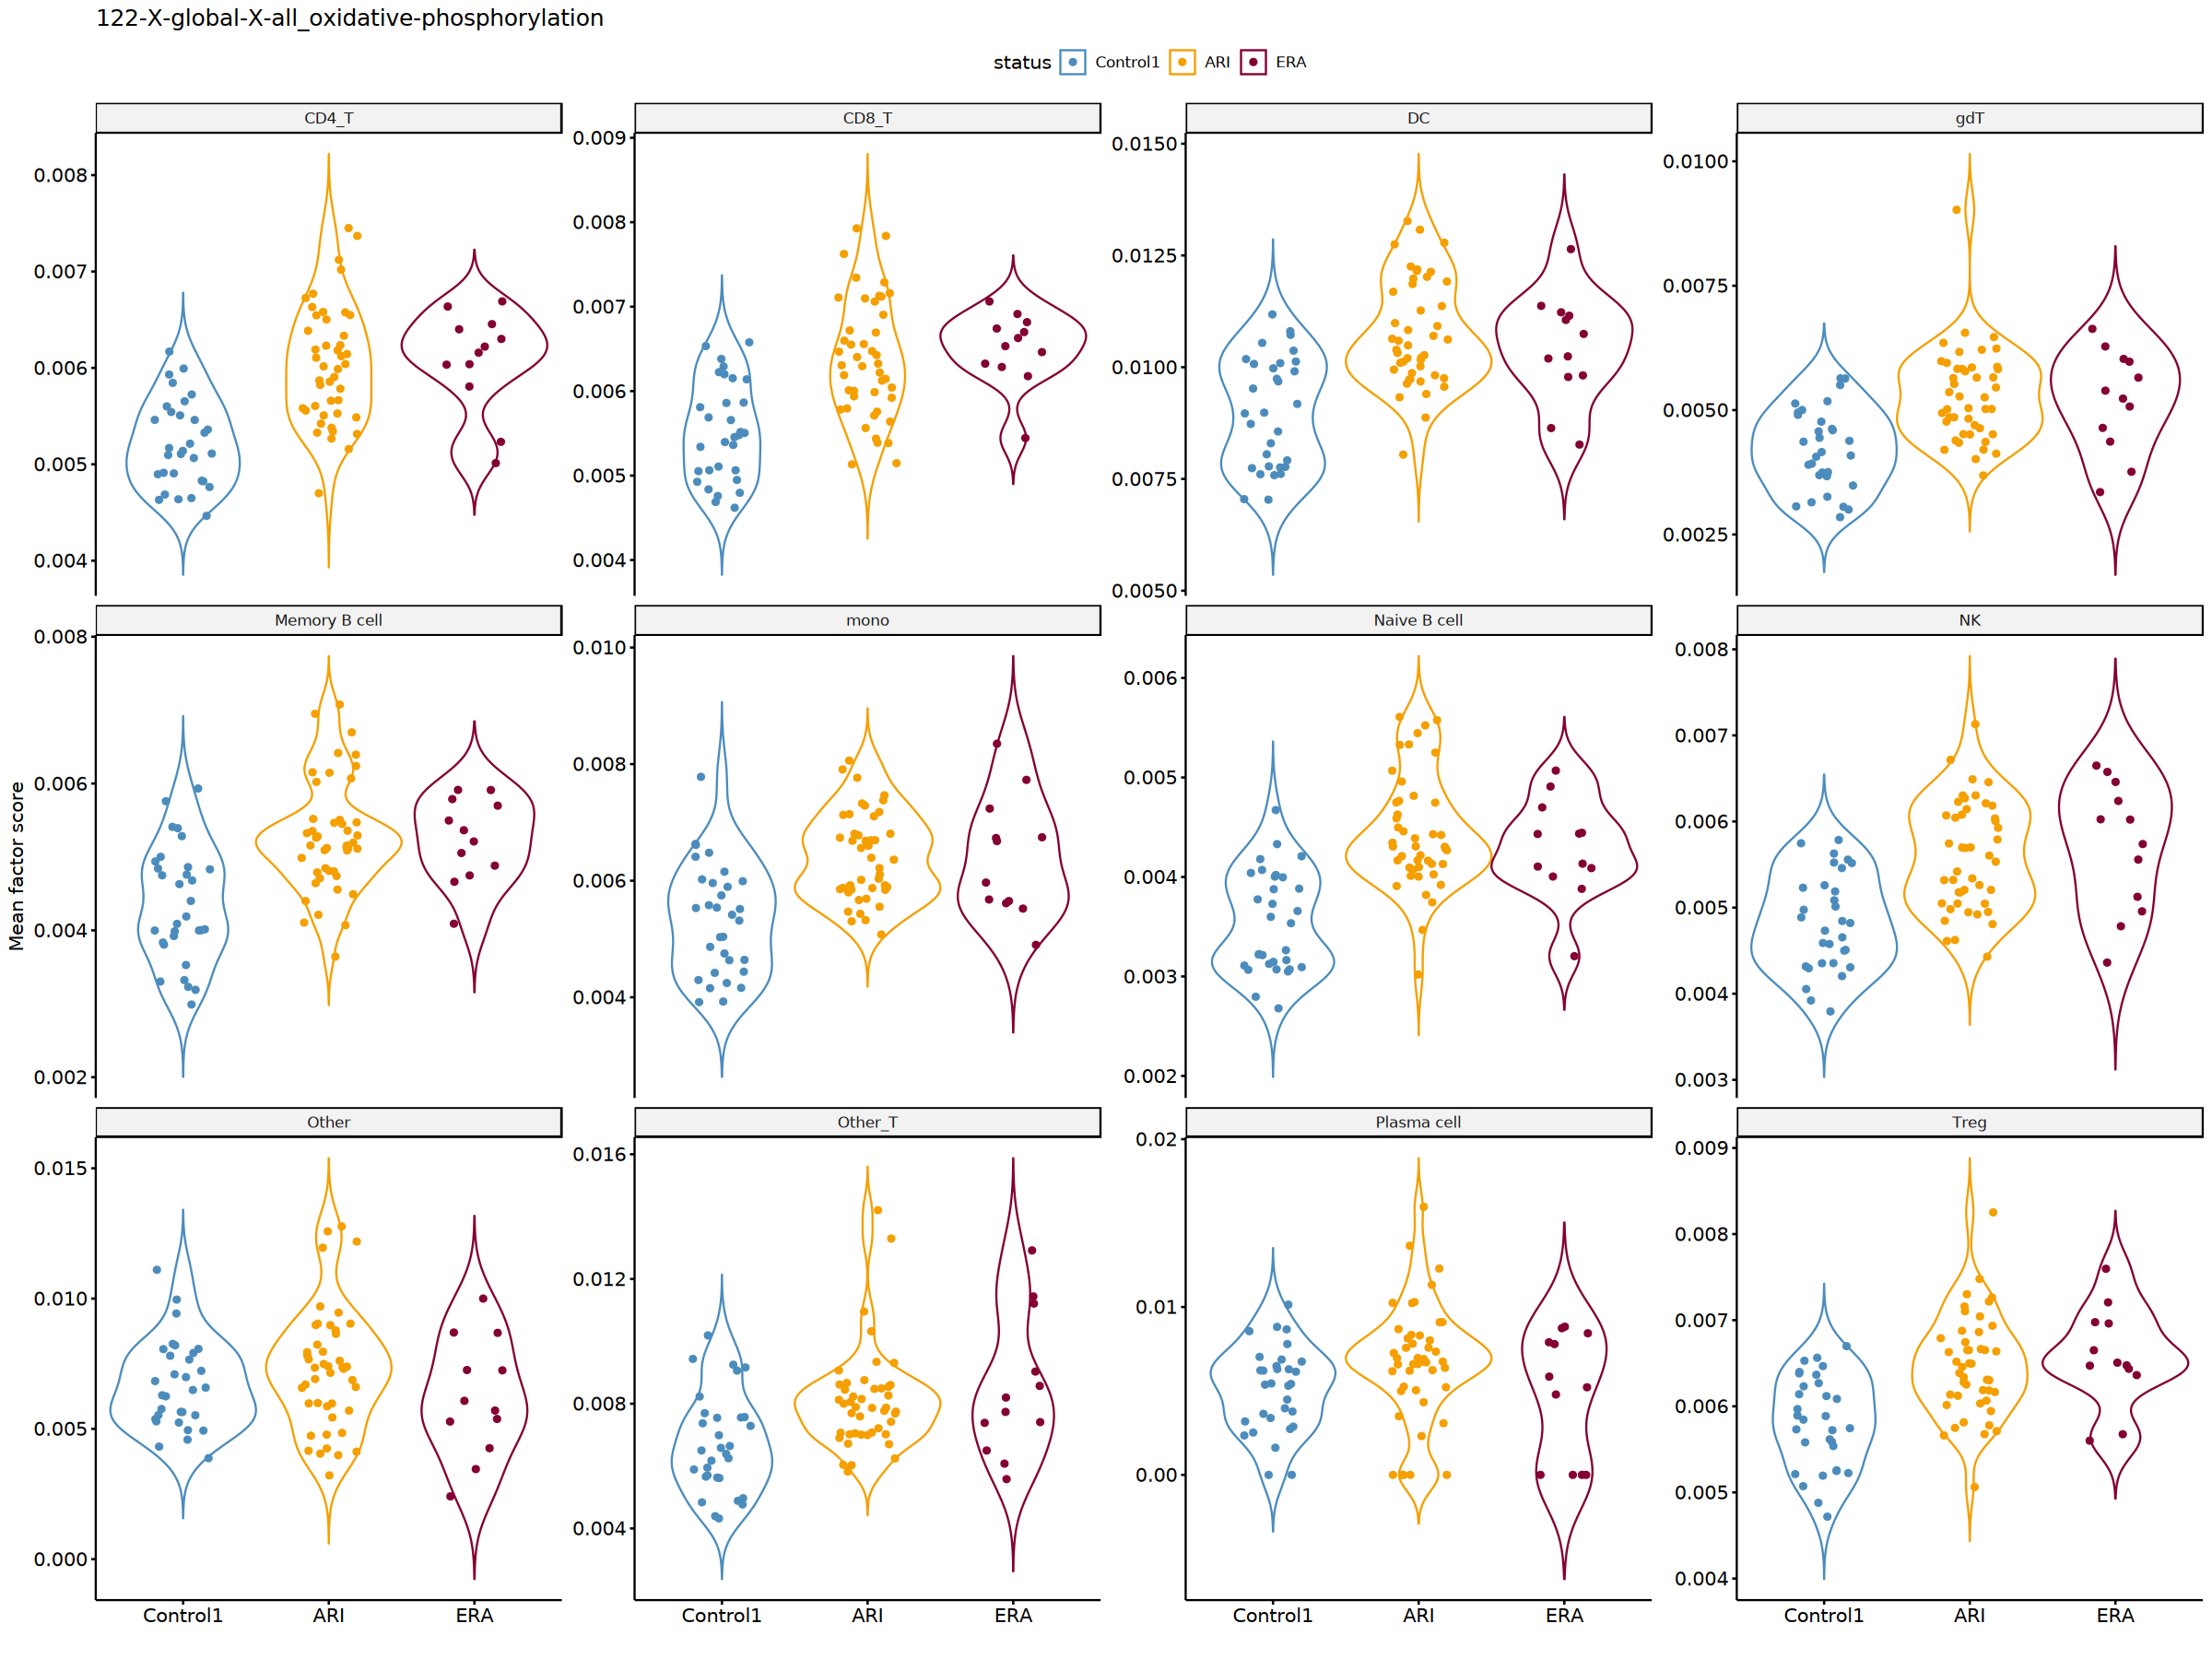

In [213]:
factor_name <- "122-X-global-X-all_oxidative-phosphorylation"
p1 <- PlotFactorDot(spec_scores_fl,
    stats_table = glm_results_status,
    factor_name = factor_name
) + ggtitle("Global oxidative phosphorylation")
p1
ggsave(file.path(fig_path, paste0(proj_name, factor_name, "_pathway_enrichment_dotplot.pdf")),
    plot = p1, width = 5, height = 5
)
# Save the plot
p2 <- PlotFactor(spec_scores_fl,
    factor_name = factor_name, fig_path, proj_name
)
p2


`summarise()` has grouped output by 'status'. You can override using the
`.groups` argument.


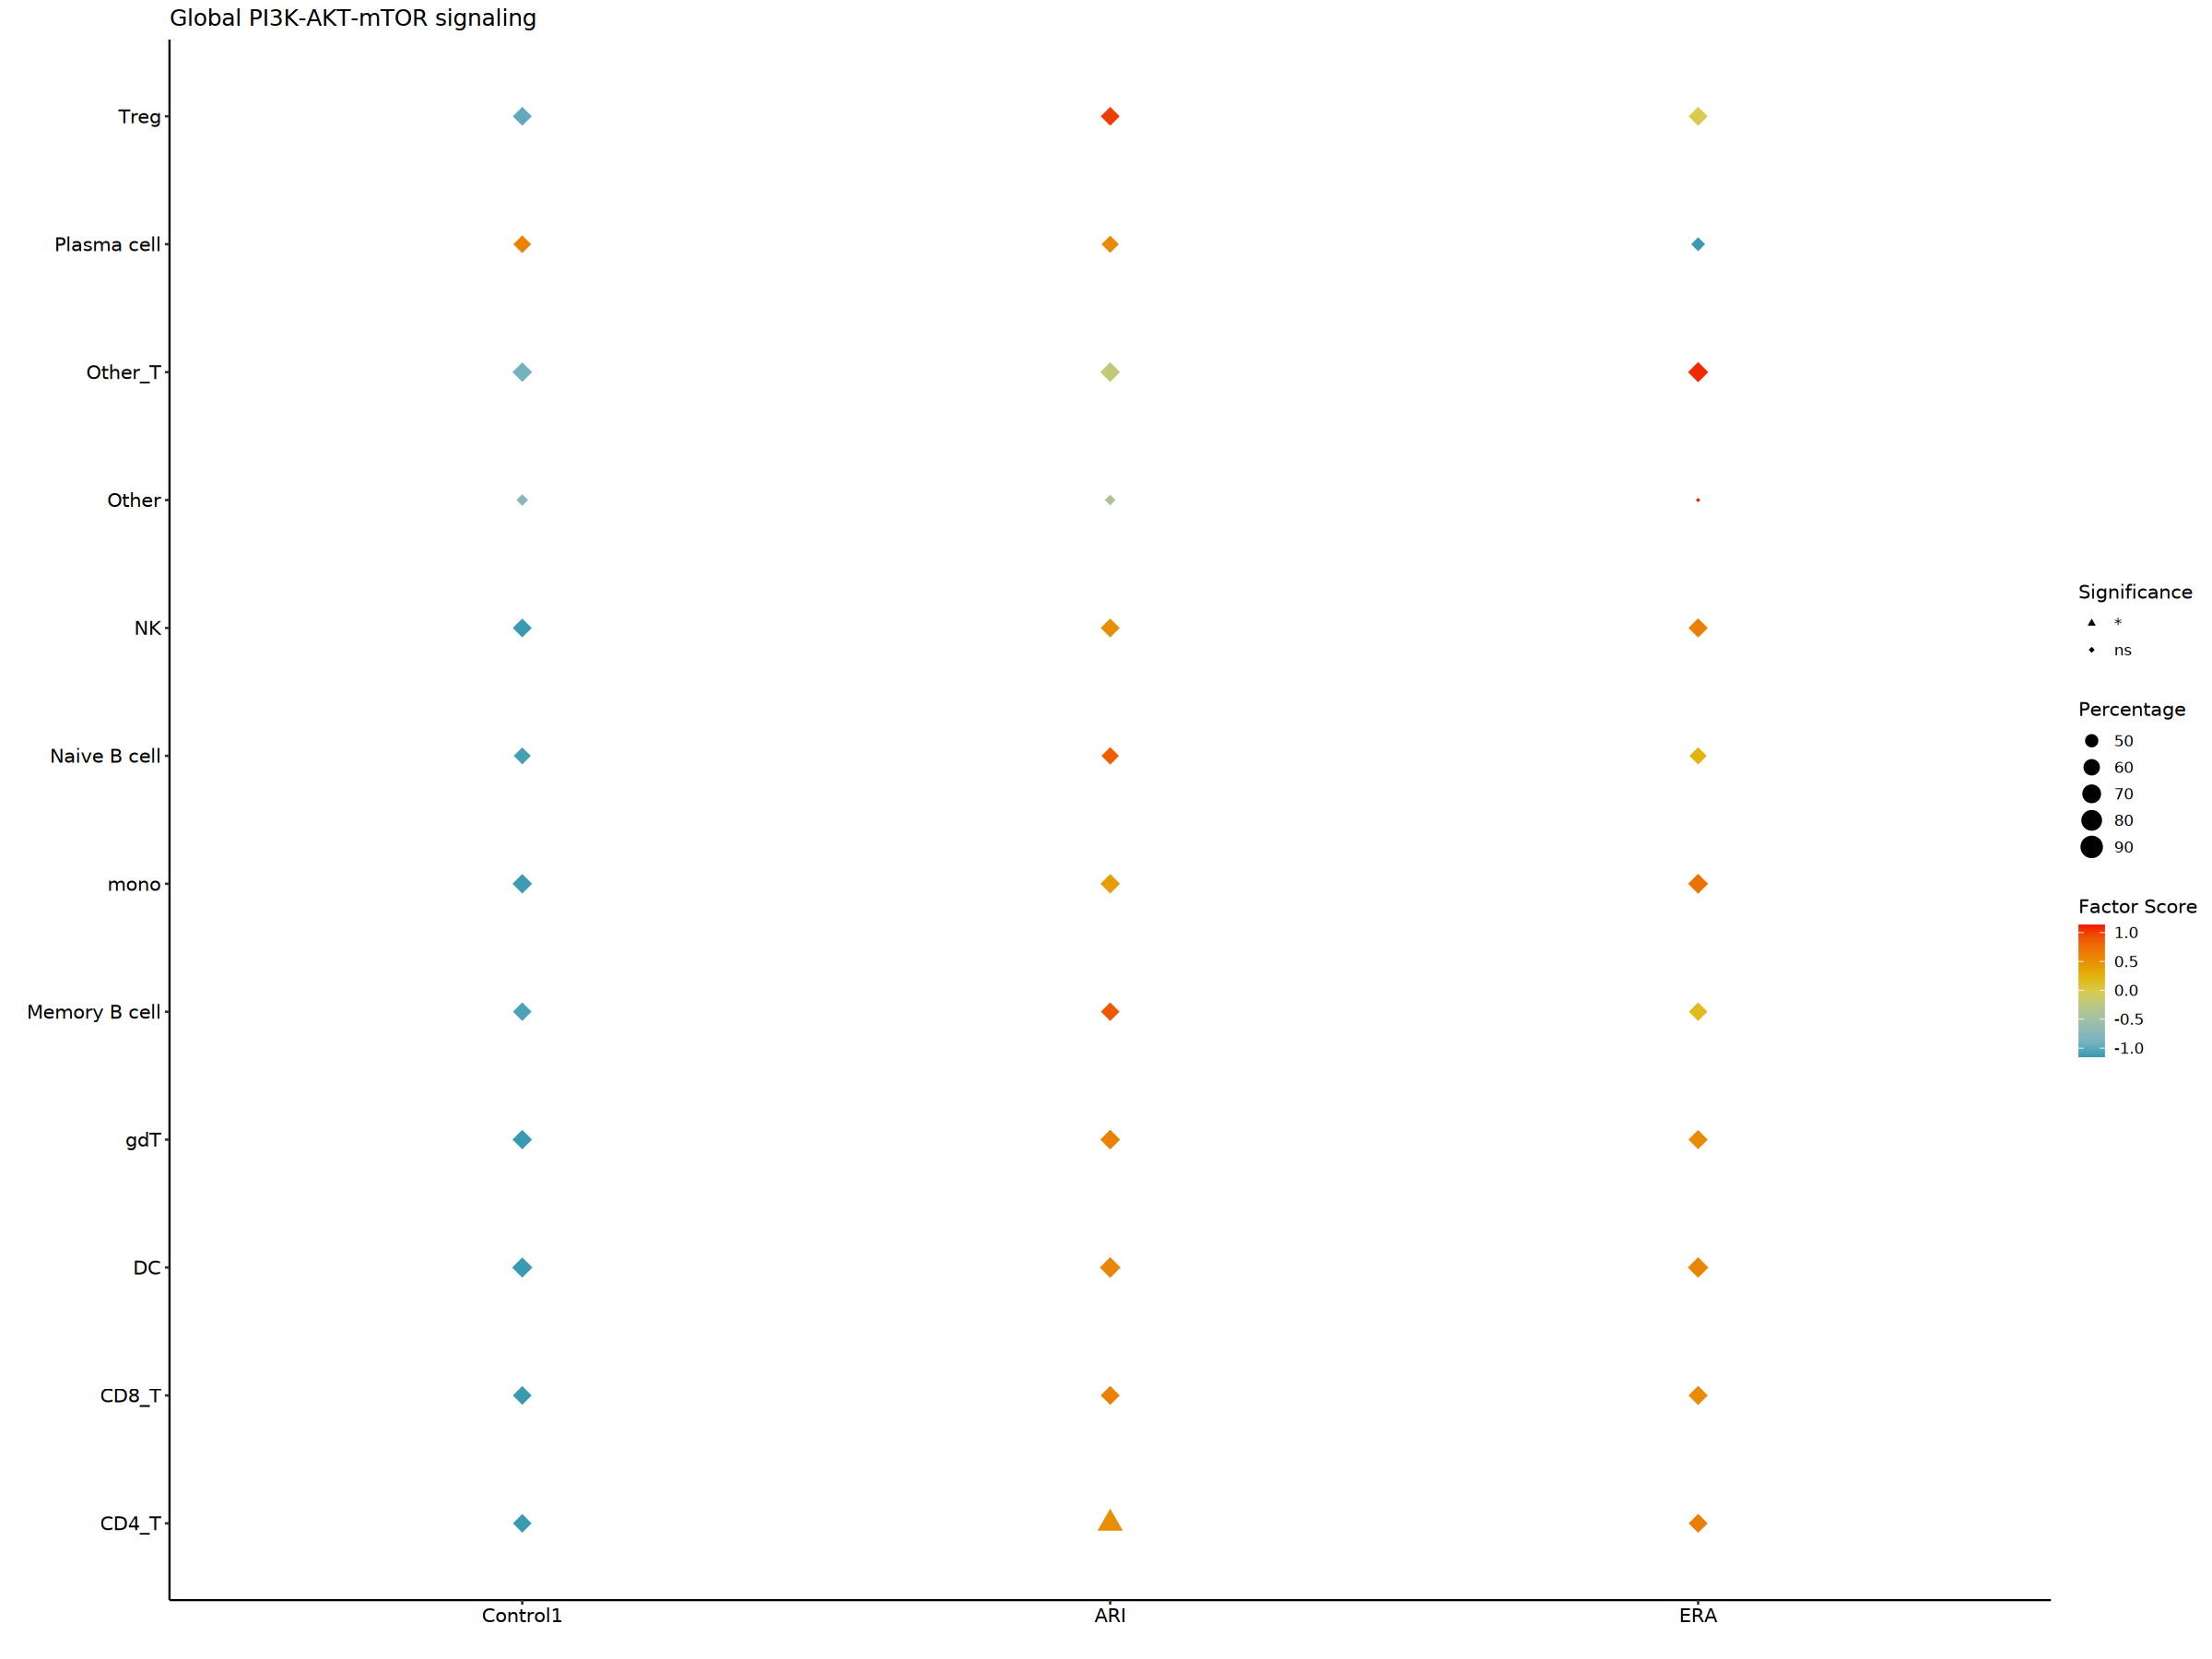

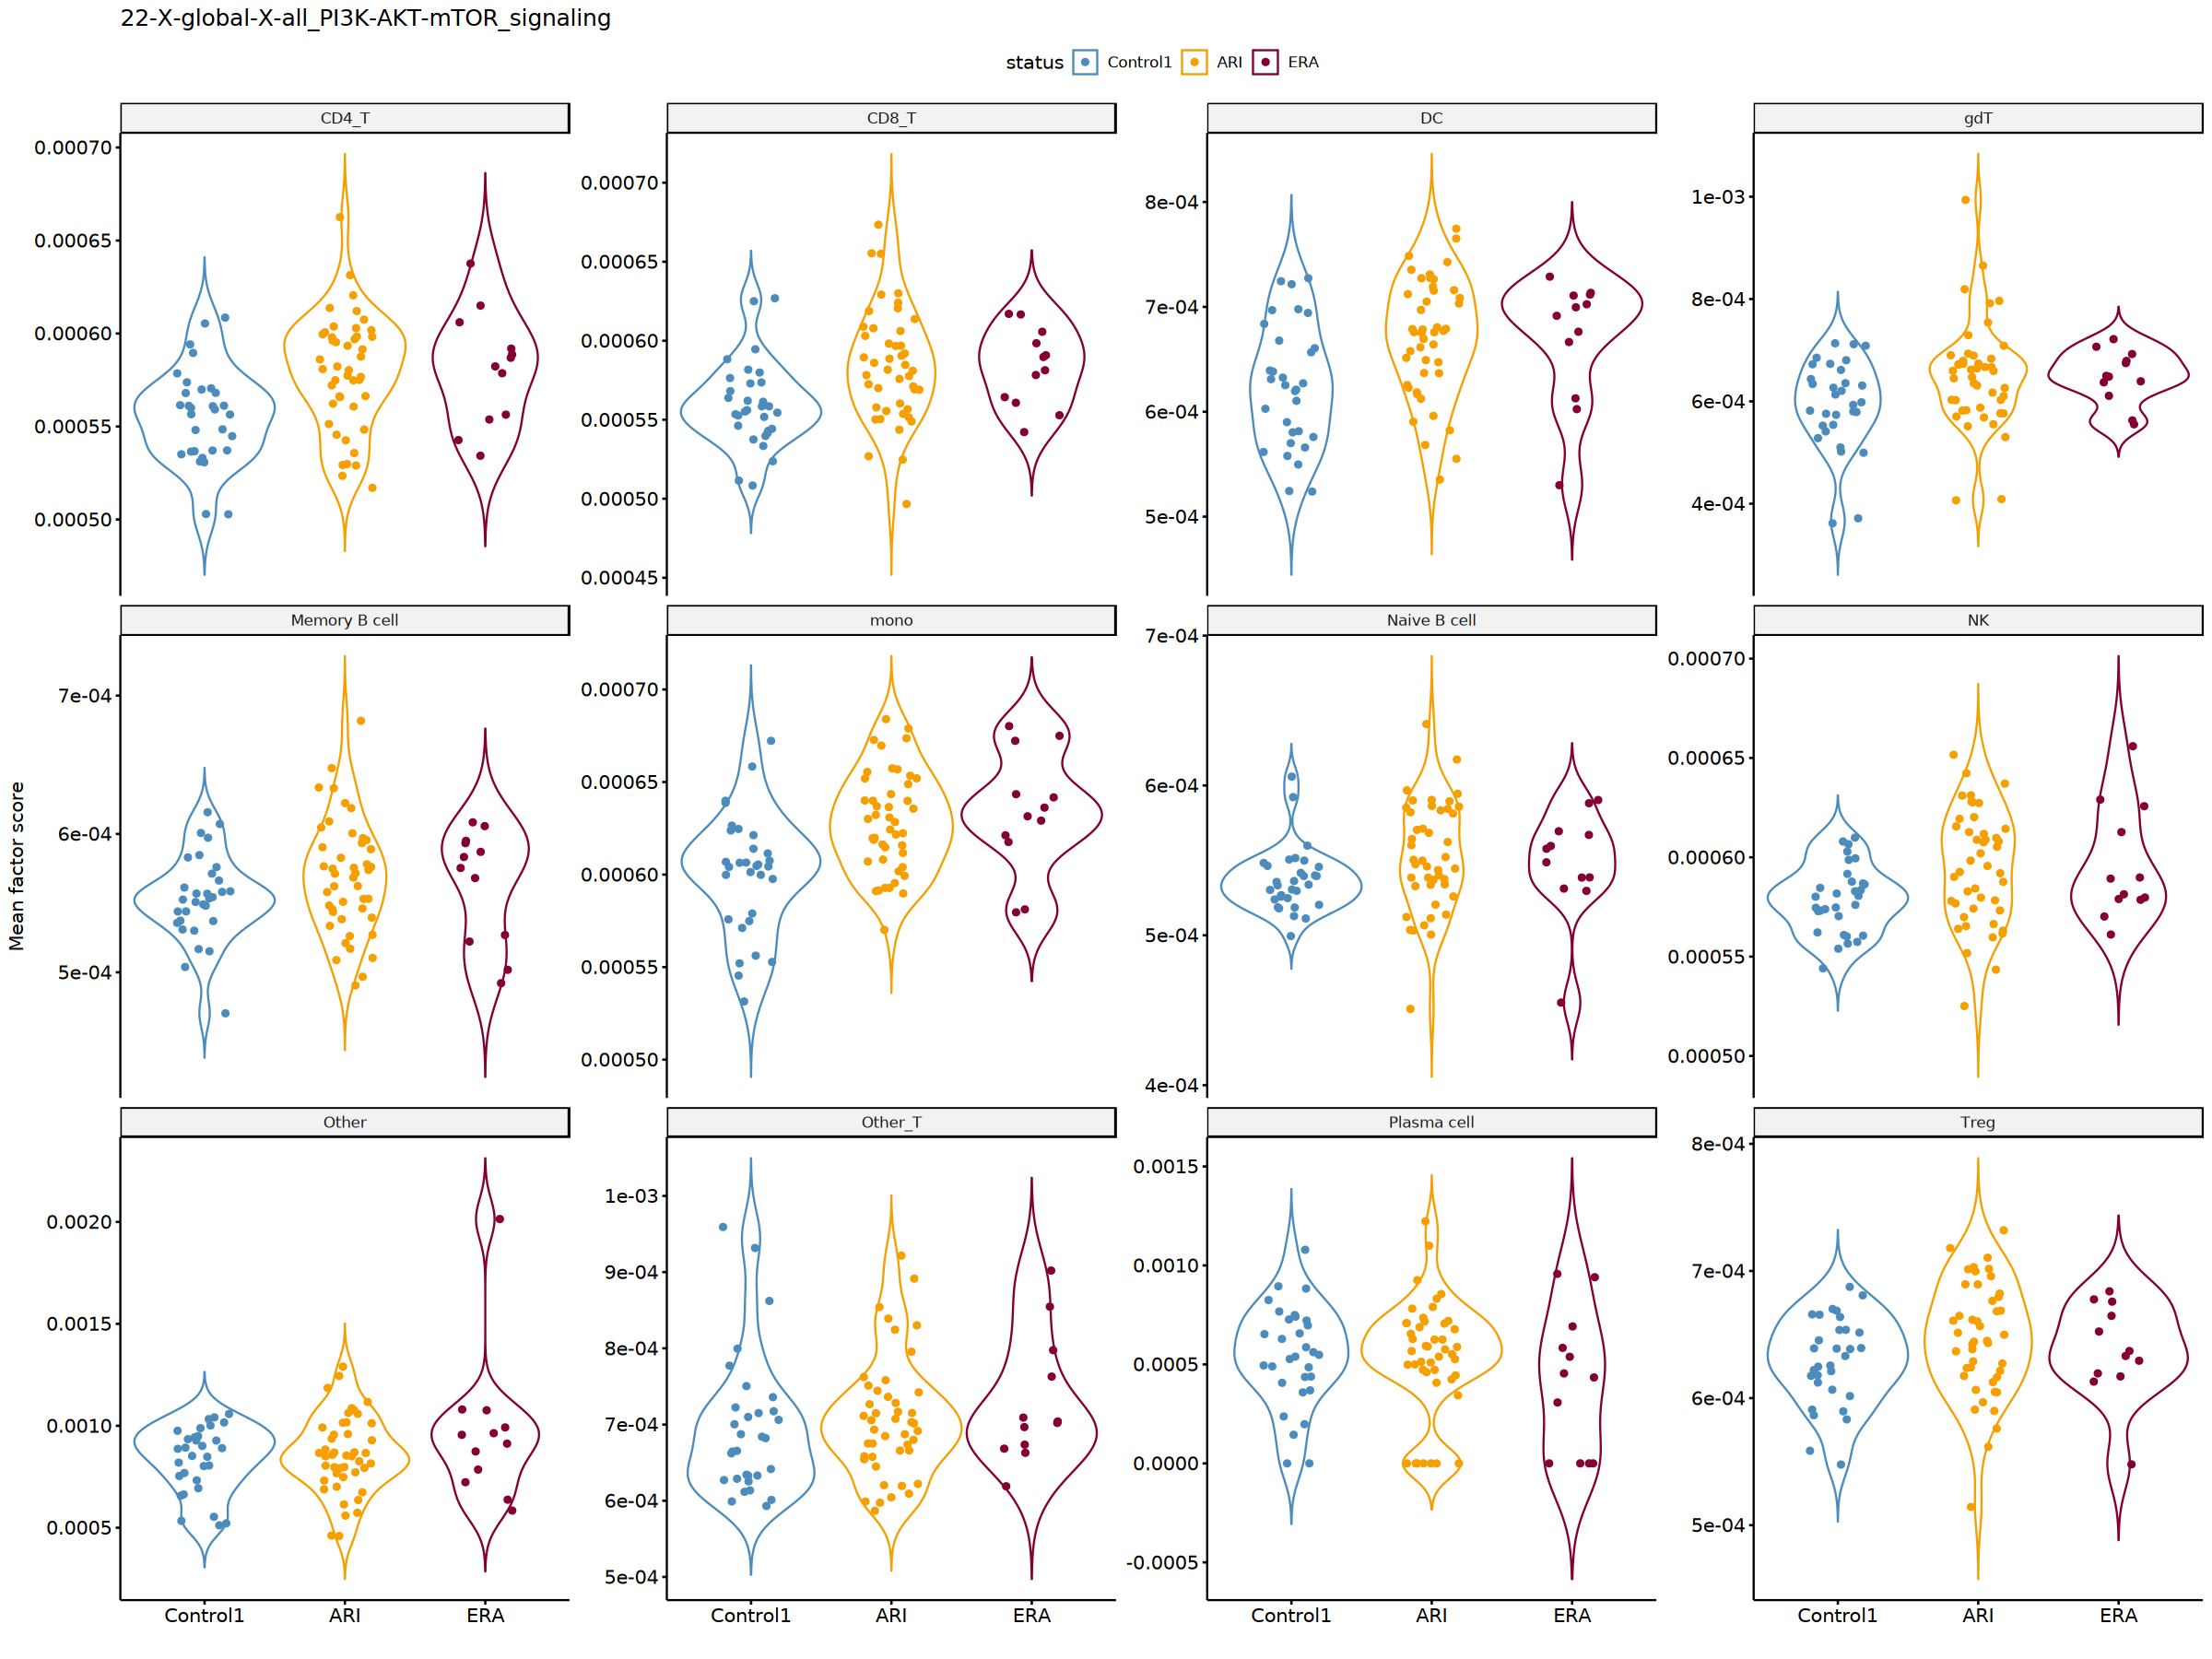

In [214]:
factor_name <- "22-X-global-X-all_PI3K-AKT-mTOR_signaling"
p1 <- PlotFactorDot(spec_scores_fl,
    stats_table = glm_results_status,
    factor_name = factor_name
) + ggtitle("Global PI3K-AKT-mTOR signaling")
p1
# Save the plot
ggsave(file.path(fig_path, paste0(proj_name, factor_name, "_pathway_enrichment.pdf")),
    plot = p1, width = 5, height = 5
)
# Save the plot
p2 <- PlotFactor(spec_scores_fl,
    factor_name = factor_name, fig_path, proj_name
)
p2


`summarise()` has grouped output by 'status'. You can override using the
`.groups` argument.


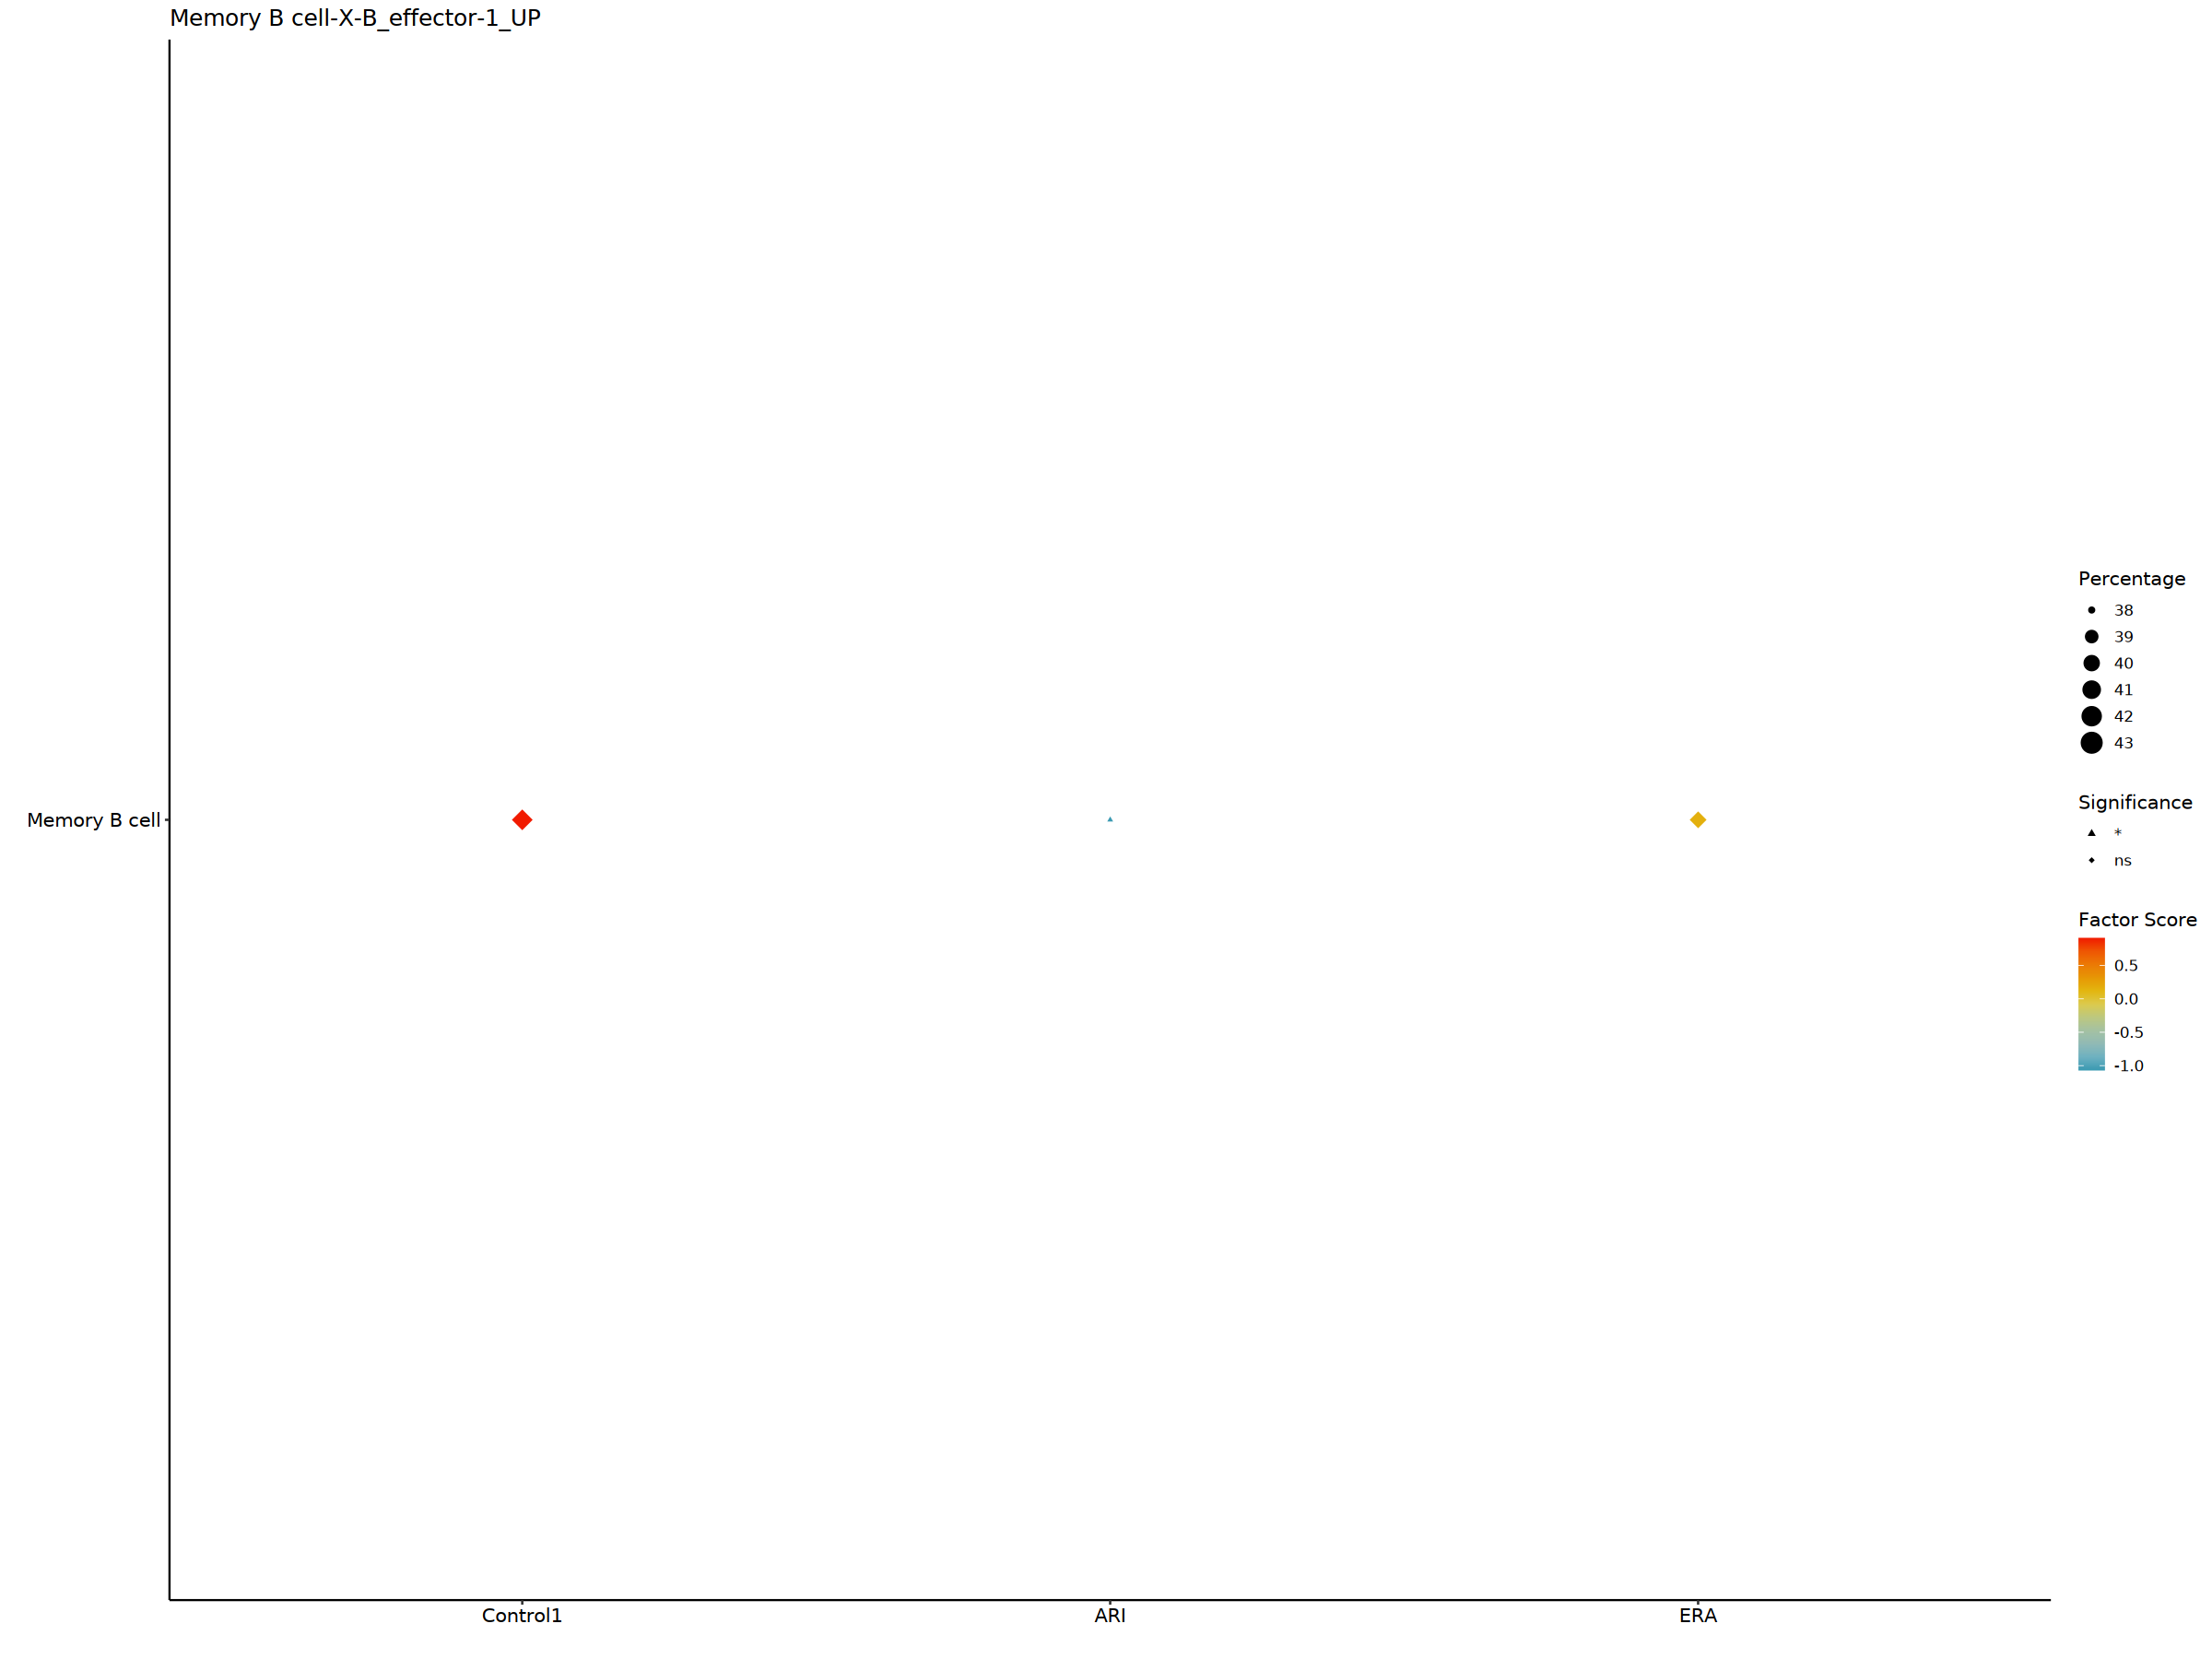

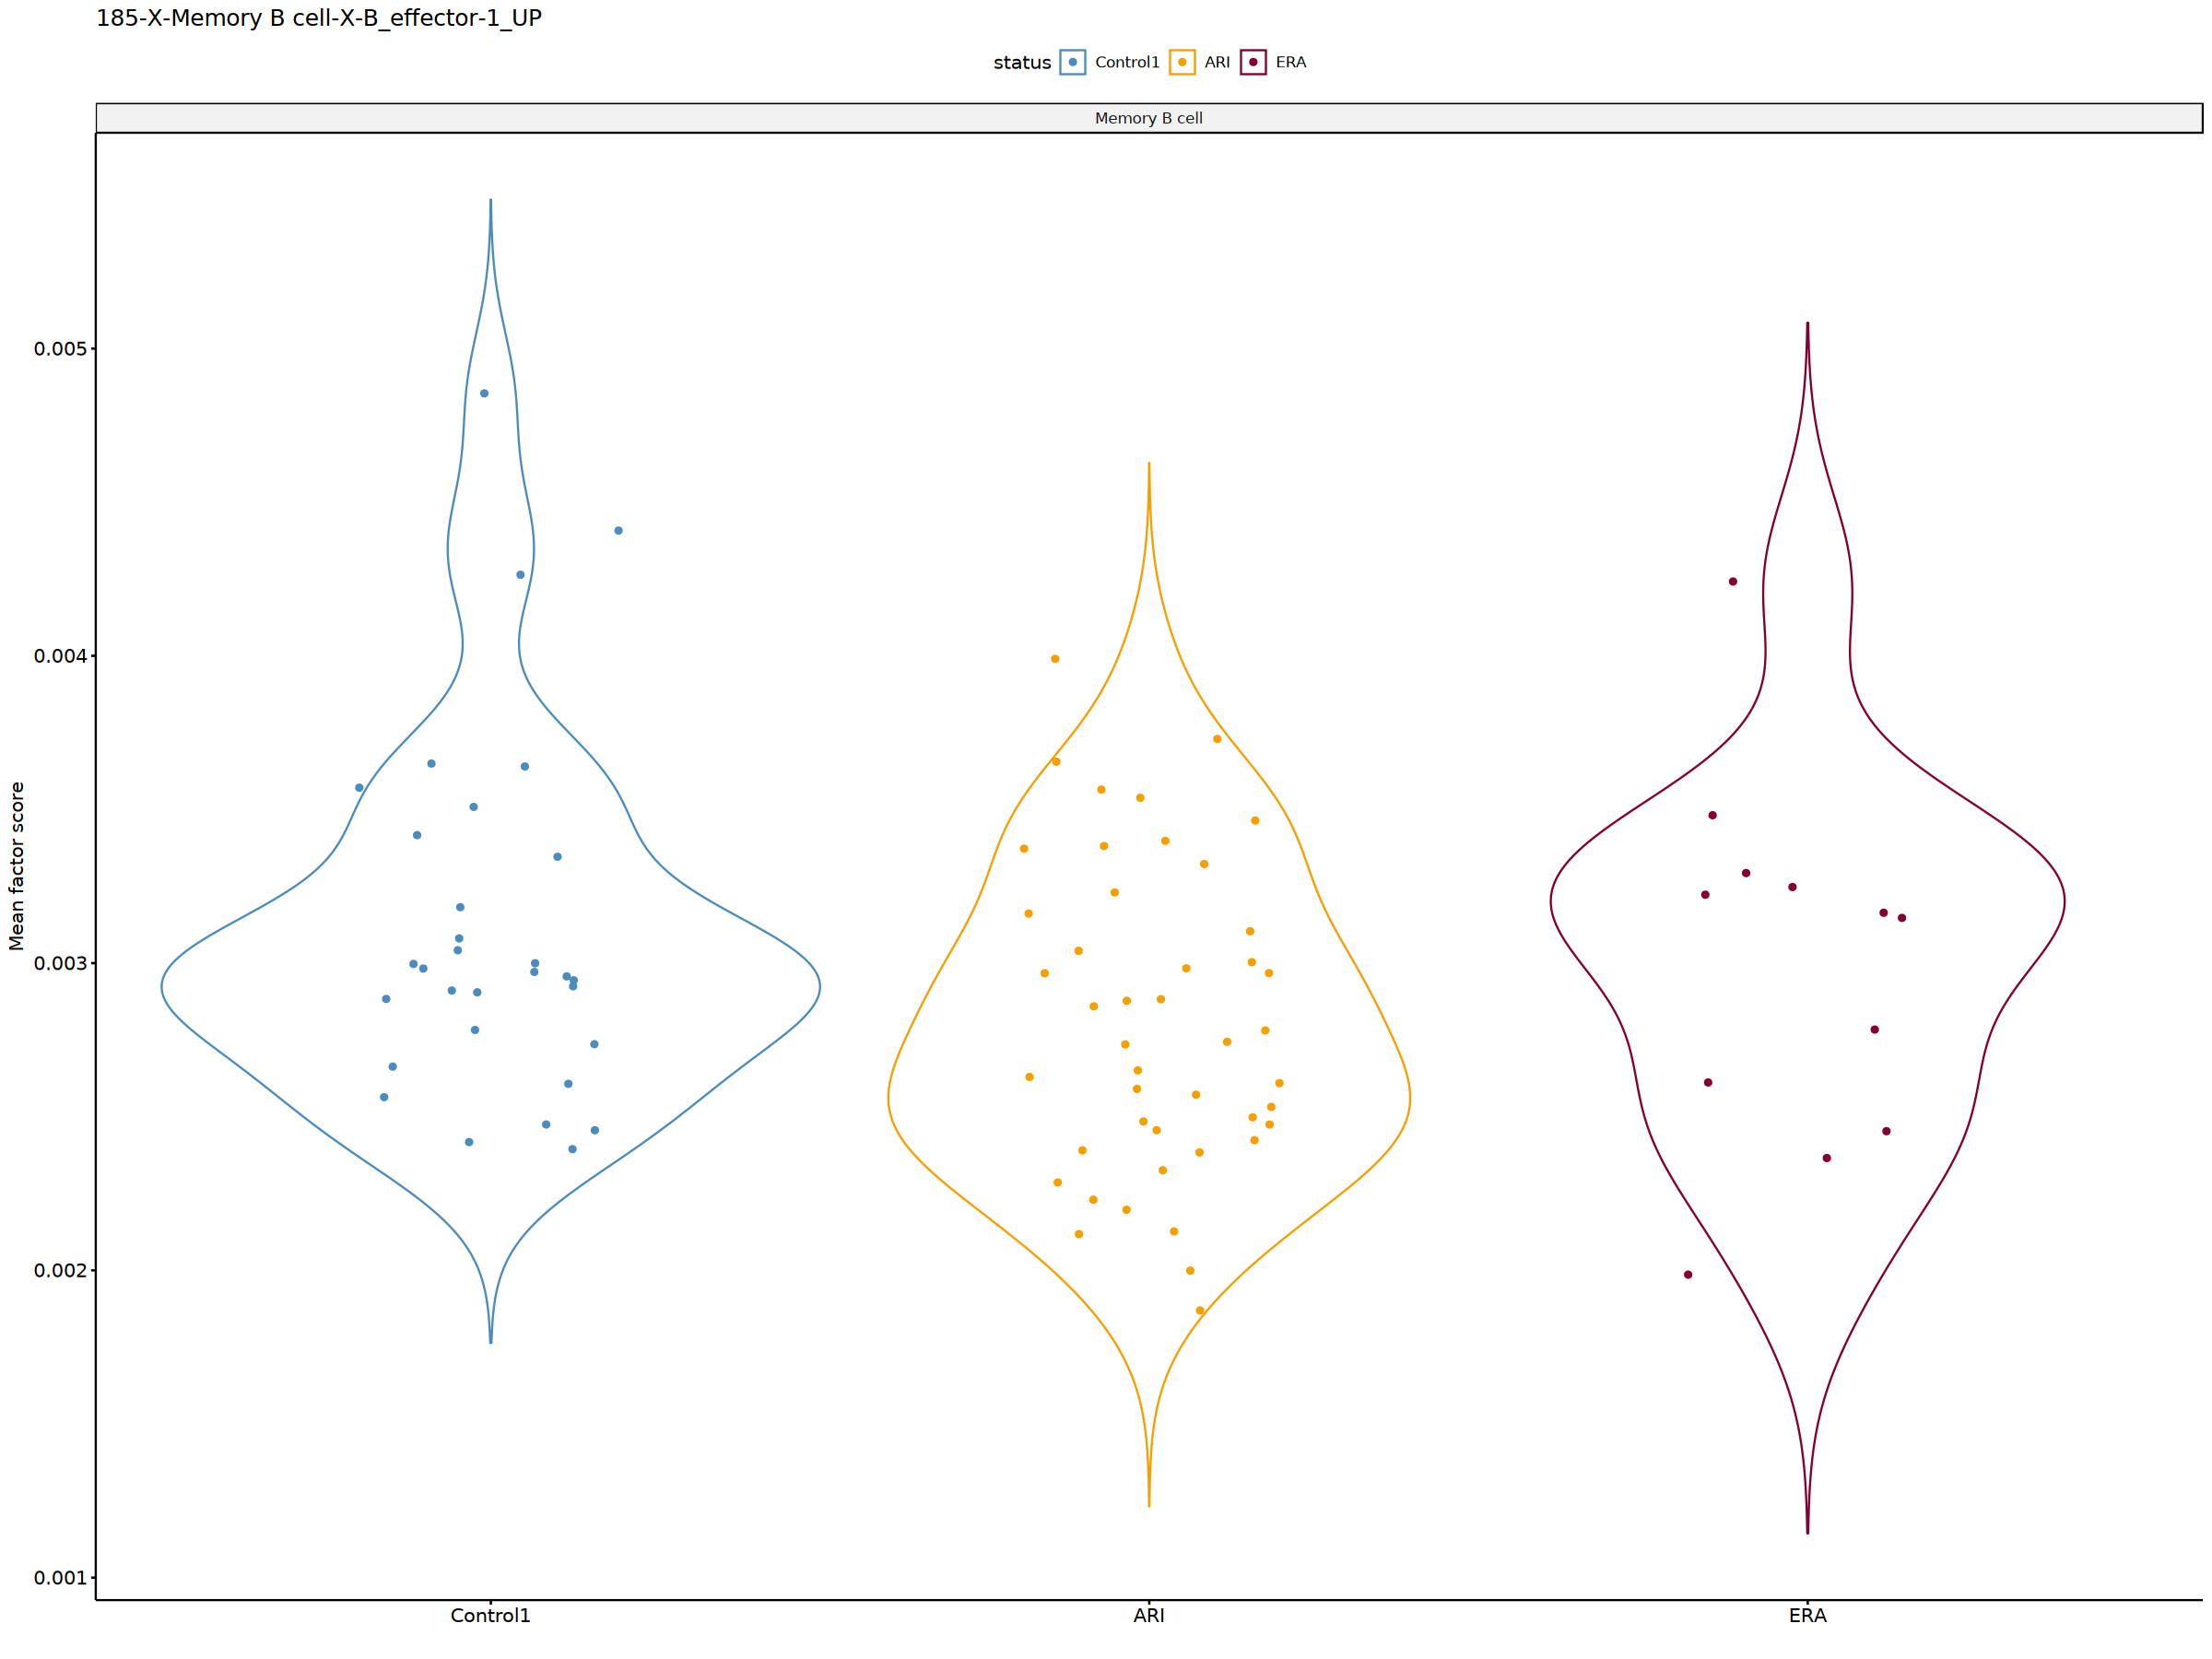

In [50]:
factor_name <- "185-X-Memory B cell-X-B_effector-1_UP"
p1 <- PlotFactorDot(spec_scores_fl %>% filter(AIFI_L1_5 == "Memory B cell"),
    stats_table = glm_results_status,
    factor_name = factor_name
) + ggtitle("Memory B cell-X-B_effector-1_UP")
p1
# Save the plot
ggsave(file.path(fig_path, paste0(proj_name, factor_name, "_pathway_enrichment.pdf")),
    plot = p1, width = 5, height = 5
)
# Save the plot
p2 <- PlotFactor(spec_scores_fl %>% filter(AIFI_L1_5 == "Memory B cell"),
    factor_name = factor_name, fig_path, proj_name, width = 4, height = 4
)
p2


## plot heatmap for all significant global pathways

In [ ]:
quiet_library("ComplexHeatmap")


In [ ]:
spec_scores %>% head()


In [ ]:
spec_scores


In [ ]:
# select the signifcant global scores
spec_gb_sig <- spec_scores %>%
    filter(!AIFI_L1_5 %in% c("ILC", "Other", "Other_T")) %>%
    select_if(str_detect(colnames(spec_scores), "X-global") &
        colnames(spec_scores) %in% anova_test_sig$Spectra_factor) %>%
    as.matrix() %>%
    t()
spec_gb_sig %>% head()


In [ ]:
# get metadata
spec_meta <- spec_scores %>%
    filter(!AIFI_L1_5 %in% c("ILC", "Other", "Other_T")) %>%
    select(c(
        sample.sampleKitGuid, file.batchID, AIFI_L1_5, Status_Xsec,
        Status_Long, BMI, subject.biologicalSex,
        CMV_Status_Subj, age, status, anti_ccp3_finalCombined
    )) %>%
    mutate(sex = subject.biologicalSex)
spec_meta %>% head()


In [ ]:
spec_gb_sig %>% dim()
spec_meta %>% dim()


In [ ]:
# cluster within the cell type in columns
col_data <- spec_meta
celltypes <- col_data$AIFI_L1_5
fa_col <- table(col_data$AIFI_L1_5) %>% as.list()
dend2 <- cluster_within_group(spec_gb_sig, celltypes)
# cluster within the cell type in rows
celltypes <- col_data$AIFI_L1_5
fa_col <- table(col_data$AIFI_L1_5) %>% as.list()

cell_type_colors <- cluster_colors[1:length(unique(col_data$AIFI_L1_5))]
names(cell_type_colors) <- unique(col_data$AIFI_L1_5)
batch_colors <- cluster_colors[1:length(unique(col_data$file.batchID))]
names(batch_colors) <- unique(col_data$file.batchID)


color_fun <- circlize::colorRamp2(c(0, 100), c("white", "#20854EFF"))
col_anno <- HeatmapAnnotation(
  cohort = col_data$Status_Xsec, age = anno_barplot(col_data$age),
  sex = col_data$sex,
  cell_type = col_data$AIFI_L1_5,
  batch = col_data$file.batchID,
  col = list(
    cohort = c(
      "ALTRA_healthy" = nejm_color[[2]],
      "at_risk" = nejm_color[[1]], "early_RA" = nejm_color[[3]]
    ),
    sex = c("Female" = npg_color[1], "Male" = npg_color[2]),
    cell_type = cell_type_colors,
    age = color_fun,
    batch = batch_colors
  )
)
col_fun2 <- circlize::colorRamp2(c(-2, 0, 2), c("blue", "white", "red"))

spec_gb_sig <- t(scale(t(spec_gb_sig)))

p1 <- ComplexHeatmap::Heatmap(spec_gb_sig,
  #  col = col_fun2,
  top_annotation = col_anno,
  # left_annotation = row_anno,
  #  cluster_columns = TRUE,
  show_column_names = FALSE,
  cluster_columns = dend2,
  column_split = length(celltypes),
  column_title_rot = 45,
  row_title_rot = 0,
  row_names_gp = gpar(fontsize = 6),
  heatmap_legend_param = list(
    title = "avg.expression"
  ), use_raster = TRUE
)
p1
# p2 <- ComplexHeatmap::Heatmap(norm_counts,
#         col = col_fun2,
#         top_annotation = col_anno,
#         #left_annotation = row_anno,
#         cluster_columns = FALSE,
#         show_column_names = FALSE,
#        # cluster_columns = dend2,
#         column_split = celltypes,
#         row_split = gene_cat,
#         column_title_rot = 45,
#         row_title_rot = 0,
#         row_names_gp = gpar(fontsize = 6),
#         heatmap_legend_param = list(
#             title = "avg.expression"
#         ), use_raster=TRUE
# )


In [ ]:
png(
        filename = file.path(fig_path, paste0(proj_name, "_spectre_scores_heatmap.png")),
        units = "in", res = 300, width = 18, height = 18
)
draw(p1)
dev.off()


In [ ]:
# PseudobulkHeatmap is a function that generates a heatmap visualization for pseudobulk data analysis.
#
# Arguments:
#   - cell.type: A character string specifying the cell type to analyze.
#   - pseudo: A SingleCellExperiment object containing the pseudobulk data.
#   - deg_list: A data frame containing the list of differentially expressed genes (DEGs) for each cell type.
#   - figname: An optional character string specifying the name of the output figure file.
#   - scale: A logical value indicating whether to scale the data matrix. Default is TRUE.
#   - plot: A logical value indicating whether to plot the heatmap. Default is TRUE.
#   - width: An integer specifying the width of the output plot. Default is 12.
#   - height: An integer specifying the height of the output plot. Default is 8.
#
# Returns:
#   A ComplexHeatmap object representing the pseudobulk heatmap.
#
# Example usage:
#   PseudobulkHeatmap("T cell", pseudo_data, deg_list, figname = "heatmap.png", scale = TRUE, plot = TRUE, width = 12, height = 8)
#
PseudoScoresHeatmap <- function(scores_df, pseudo, factors, figname = NULL, assay_name = "normalized_counts",
                                scale = TRUE, plot = TRUE, width = 12, height = 8) {
    suppressPackageStartupMessages(library(ComplexHeatmap))
    # subset the deg list
    deg_fl <- deg_list %>% dplyr::filter(cell_type == cell.type)
    # subset the pseudobulk
    pseudo_subset <- subset(
        pseudo, rownames(rowData(pseudo)) %in% degs$genes,
        cell_type == cell.type
    )

    # set up the column annotation
    col_data <- colData(pseudo_subset) %>%
        as_tibble() %>%
        distinct(subject.subjectGuid, age, status, batch_corr) %>%
        arrange(subject.subjectGuid)
    color_fun <- circlize::colorRamp2(c(0, 100), c("white", "#20854EFF"))
    col_anno <- HeatmapAnnotation(
        cohort = col_data$status, age = col_data$age,
        col = list(
            cohort = c("ALTRA Healthy" = "#BC3C29FF", "ACPA+ at_risk" = "#0072B5FF"),
            age = color_fun
        )
    )
    # # set up the data matrix
    logcounts <- assay(pseudo_subset, assay_name)
    colnames(logcounts) <- colData(pseudo_subset)$subject.subjectGuid
    # return(deg_fl)
    logcounts <- logcounts %>% as.data.frame() # %>% filter(rownames(logcounts) %in% deg_fl$gene)
    # all(rownames(col_anno)==colnames(logcounts))
    # # set up the row annotation
    # row_anno <- rowAnnotation(Celltype=pseudo$celltype,
    #                           col = list(Celltype=l2_ct_levs_color))
    if (scale) {
        logcounts <- t(scale(t(logcounts)))
    }
    col_fun2 <- circlize::colorRamp2(c(-2, 0, 2), c("blue", "white", "red"))
    p1 <- ComplexHeatmap::Heatmap(logcounts,
        col = col_fun2,
        top_annotation = col_anno,
        column_title = cell.type,
        # left_annotation = row_anno,
        # cluster_rows = FALSE,
        row_names_gp = gpar(fontsize = 8),
        heatmap_legend_param = list(
            title = "avg.expression"
        )
    )
    # if(plot){
    # pdf(file.path(fig_path, paste(proj_name, 'pseudobulk',
    # figname,cell.type,'Heatmap.pdf', sep='_')),
    # width=width, height=height)
    # draw(p1)
    # dev.off()
    # }

    return(p1)
}
